# **Introduction**

In this section, two machine learning models will be used to classify the `vivo_ano5` column, Random Forest and XGBoost, for both datasets, São Paulo and other states.

The label is 1 if the patient is alive after five years of treatment and 0 if not.

The first approach is using the "raw data", the second is without the `EC` column, the third one is without `EC` and `HORMONIO`, the fourth is using the grouped years and without the column `EC` and the fifth is also with the years gruped and without `EC` and `HORMONIO`.

The years will be grouped as follows: 2000 to 2003, 2004 to 2007, 2008 to 2011, 2012 to 2015 and 2016 until the end. So we will have 5 datasets for SP and another 5 for other states.

Reading the data from SP and other states.

We can see that we still have some missing values in both datasets, but the columns `DTRECIDIVA`, `delta_t4`, `delta_t5` and `delta_t6` will not be used in this approach.

In [ ]:
df_SP = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_SP_labels.csv')
df_fora = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_foraSP_labels.csv')

(506037, 77)
(32891, 77)


Here we have the correlations between the label and the other columns, the columns with higher correlations will not be used as features of the models, because they may have been used to create the label, such as the ``ULTINFO`` column, or they can be used as label for other machine learning models.

In [ ]:
# SP
corr_matrix = df_SP.corr()
abs(corr_matrix['vivo_ano5']).sort_values(ascending = False).head(20)

vivo_ano5       1.000000
ULTIDIAG        0.829202
ULTITRAT        0.824152
ULTICONS        0.823421
vivo_ano3       0.688613
vivo_ano1       0.379191
obito_cancer    0.332117
ANODIAG         0.324126
obito_geral     0.294475
HORMONIO        0.198900
CATEATEND       0.177011
CIRURGIA        0.166085
MORFO           0.150870
ULTINFO         0.145083
G               0.118027
QUIMIO          0.098815
PSA             0.093765
GLEASON         0.092859
REGISTRADO      0.089388
CLINICA         0.072913
Name: vivo_ano5, dtype: float64

In [ ]:
# Other states
corr_matrix = df_fora.corr()
abs(corr_matrix['vivo_ano5']).sort_values(ascending = False).head(20)

vivo_ano5       1.000000
ULTIDIAG        0.818812
ULTICONS        0.816039
ULTITRAT        0.814230
vivo_ano3       0.667262
ANODIAG         0.378213
vivo_ano1       0.365313
obito_cancer    0.314455
obito_geral     0.301465
CATEATEND       0.271218
CIRURGIA        0.182209
HORMONIO        0.173752
ULTINFO         0.169878
REGISTRADO      0.149369
MORFO           0.132414
GLEASON         0.119970
PSA             0.118843
QUIMIO          0.089366
TRATCONS        0.083623
RADIO           0.064680
Name: vivo_ano5, dtype: float64

Here we have the number of examples for each category of the label, it is clear that there is an imbalance, similar to the previous classification. 

In [ ]:
df_SP.vivo_ano5.value_counts()

0    350104
1    155933
Name: vivo_ano5, dtype: int64

In [ ]:
df_fora.vivo_ano5.value_counts()

0    23443
1     9448
Name: vivo_ano5, dtype: int64

Years of diagnosis present in the data.

In [ ]:
np.sort(df_SP.ANODIAG.unique())

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021])

In [ ]:
np.sort(df_fora.ANODIAG.unique())

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])

Before dividing the datasets, it is necessary to select only the patients who have been followed up for at least five years.

In [ ]:
df_SP_ano5 = df_SP[~((df_SP.obito_geral == 0) & (df_SP.vivo_ano5 == 0))]
df_SP_ano5.shape

(348678, 77)

In [ ]:
df_fora_ano5 = df_fora[~((df_fora.obito_geral == 0) & (df_fora.vivo_ano5 == 0))]
df_fora_ano5.shape

(20559, 77)

# **First approach**

Approach with "raw data".

## **Preprocessing**

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation.

First, it is necessary to define the columns that will be used as features and the label. We will not use some columns of the datasets: `UFRESID`, because we already have the division between SP and other states in the two datasets. 

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`. Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'FAIXAETAR', 'ULTICONS', 'ULTIDIAG', 'ULTITRAT', 
             'obito_geral', 'obito_cancer', 'vivo_ano1', 'vivo_ano3', 'ULTINFO']

# 'RECNENHUM', 'RECLOCAL', 'RECREGIO', 'REC01', 'REC02', 'REC03', 'RECDIST'

lb = 'vivo_ano5'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
X_train_SP, X_test_SP, y_train_SP, y_test_SP, feat_cols_SP = preprocessing(df_SP_ano5, list_drop, lb, 
                                                                           random_state=seed,
                                                                           balance_data=False,
                                                                           encoder_type='LabelEncoder', 
                                                                           norm_name='StandardScaler')

X_train = (261508, 66), X_test = (87170, 66)
y_train = (261508,), y_test = (87170,)


**Other states**

In [ ]:
X_train_OS, X_test_OS, y_train_OS, y_test_OS, feat_cols_OS = preprocessing(df_fora_ano5, list_drop, lb, 
                                                                           random_state=seed,
                                                                           balance_data=False,
                                                                           encoder_type='LabelEncoder', 
                                                                           norm_name='StandardScaler')

X_train = (15419, 66), X_test = (5140, 66)
y_train = (15419,), y_test = (5140,)


## **Training machine learning models**

After dividing the data into training and testing, using the encoder and normalizing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model that will be tested is the Random Forest, for this test the parameter `random_state` will be used, to obtain the same training values of the model every time it is runned.

The hyperparameter `class_weight` was also used, because the model has difficulty learning the class with fewer examples, so using this parameter this class will have a higher weight in the training of the model.

In [ ]:
# SP 
rf_sp = RandomForestClassifier(class_weight={0:1, 1:1.05}, 
                               random_state=seed,
                               criterion='entropy',
                               max_depth=10)

rf_sp.fit(X_train_SP, y_train_SP)

RandomForestClassifier(class_weight={0: 1, 1: 1.05}, criterion='entropy',
                       max_depth=10, random_state=10)

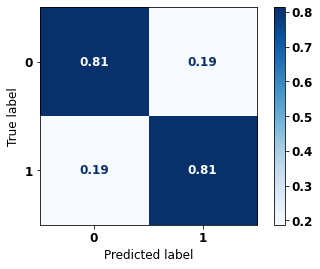

In [ ]:
display_confusion_matrix(rf_sp, X_test_SP, y_test_SP)

> The confusion matrix obtained for the Random Forest, with SP data, shows a good performance of the model, with 81% of accuracy.


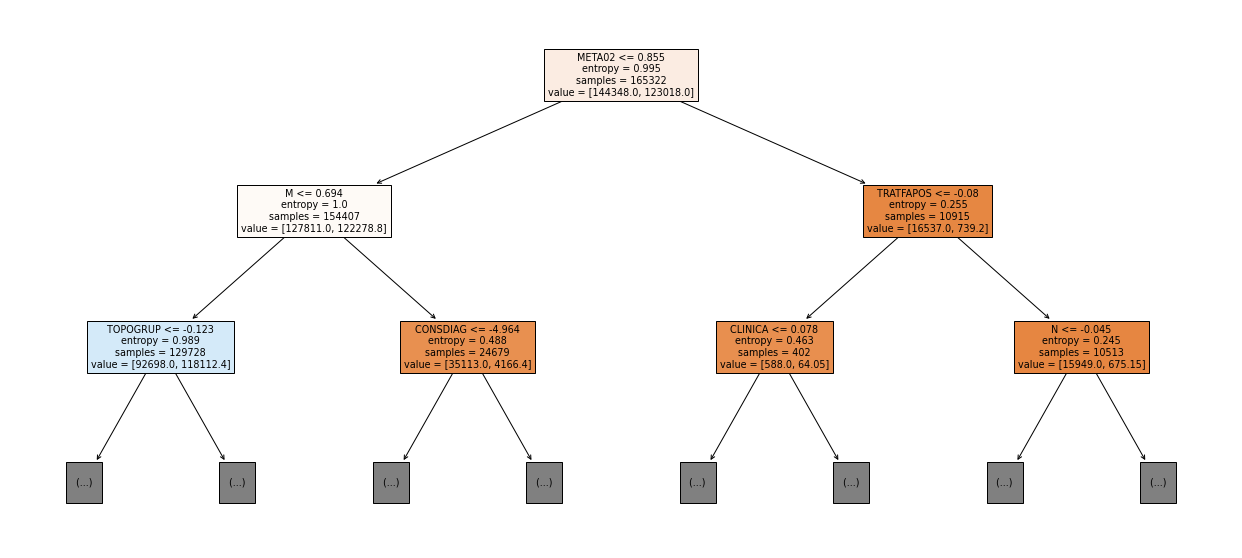

In [ ]:
show_tree(rf_sp, feat_cols_SP, 2)

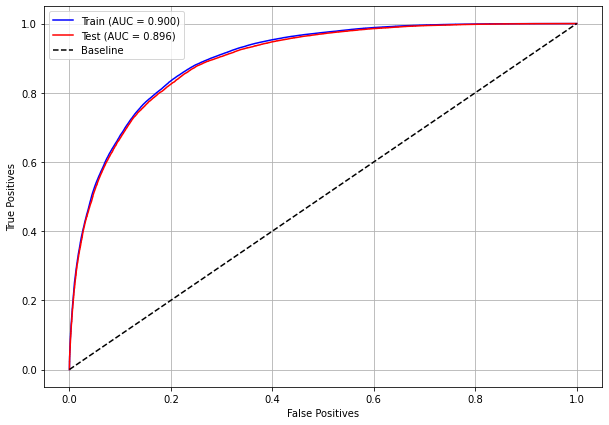

In [ ]:
plot_roc_curve(rf_sp, X_train_SP, X_test_SP, y_train_SP, y_test_SP)

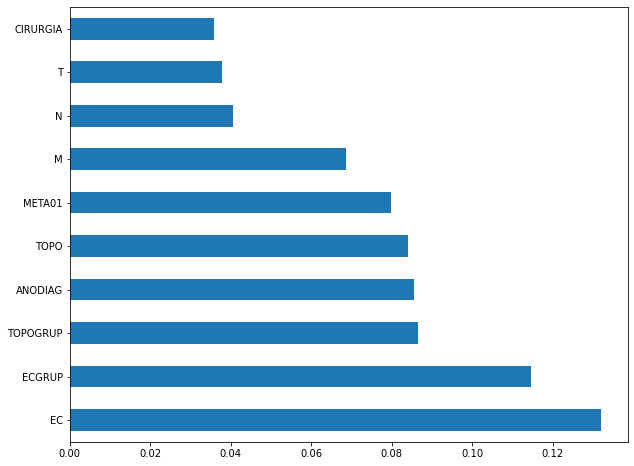

In [ ]:
plot_feat_importances(rf_sp, feat_cols_SP)

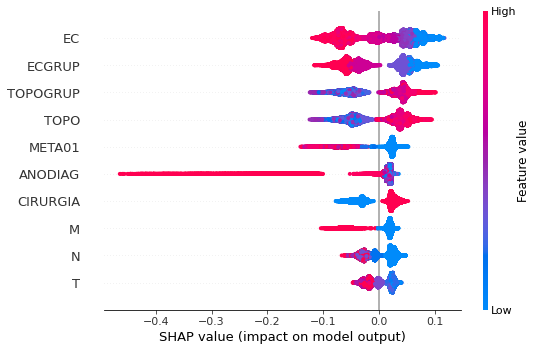

In [ ]:
plot_shap_values(rf_sp, X_test_SP, feat_cols_SP)

> The four most important features in the model were `EC`, `ECGRUP`, `TOPOGRUP` and `ANODIAG`.

In [ ]:
# Other states
rf_fora = RandomForestClassifier(class_weight={0:1.05, 1:1}, 
                                 random_state=seed,
                                 criterion='entropy',
                                 max_depth=10)

rf_fora.fit(X_train_OS, y_train_OS)

RandomForestClassifier(class_weight={0: 1.05, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

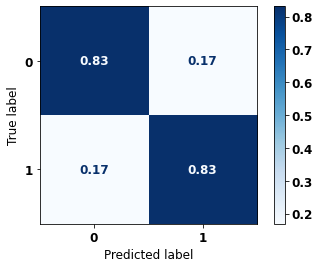

In [ ]:
display_confusion_matrix(rf_fora, X_test_OS, y_test_OS)

> The confusion matrix obtained for the Random Forest algorithm, with other states data, shows a good performance of the model, because the model achieves a 83% of accuracy.


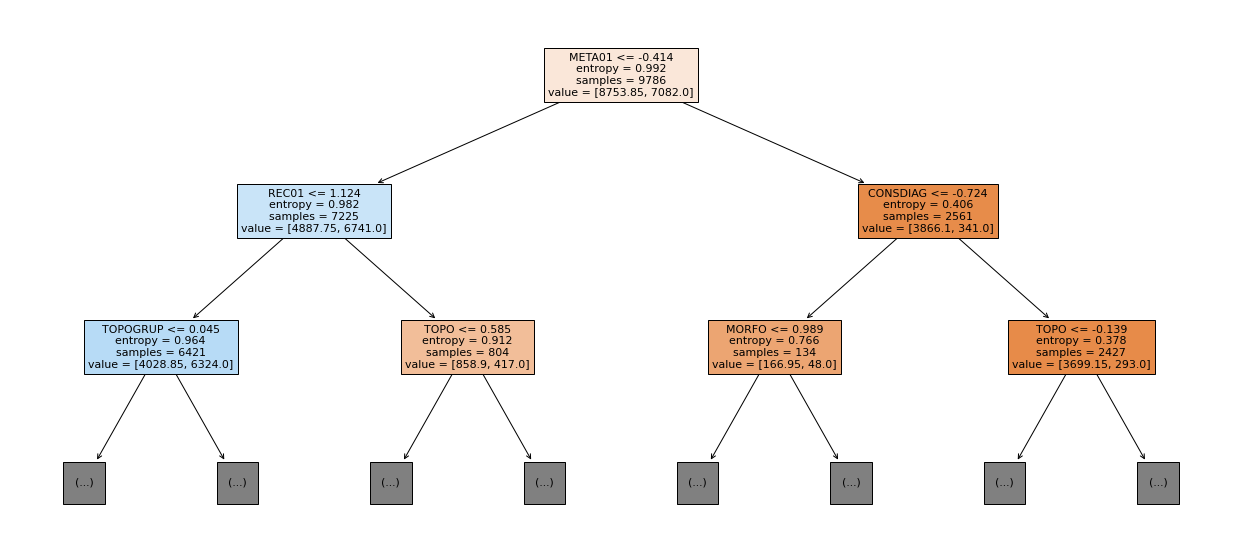

In [ ]:
show_tree(rf_fora, feat_cols_OS, 2)

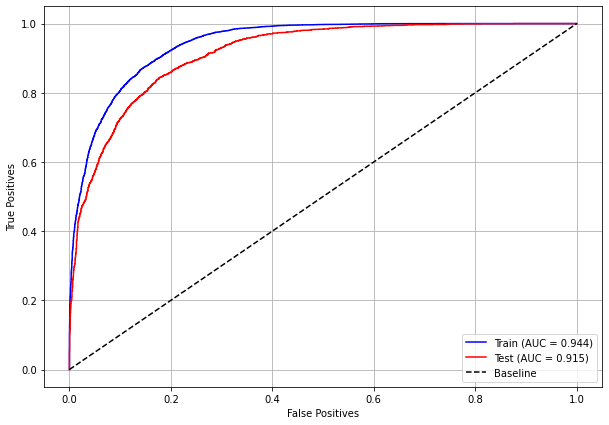

In [ ]:
plot_roc_curve(rf_fora, X_train_OS, X_test_OS, y_train_OS, y_test_OS)

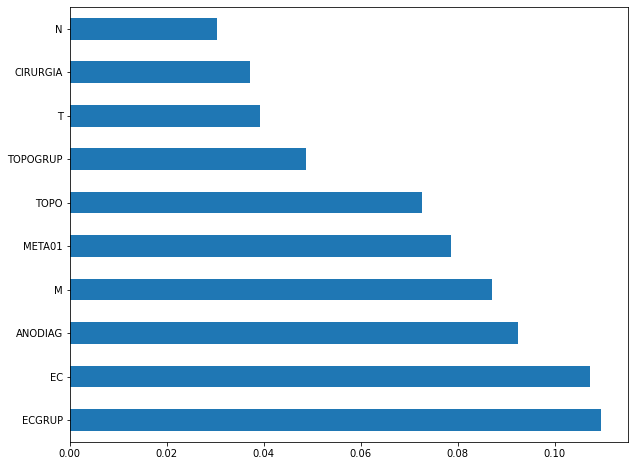

In [ ]:
plot_feat_importances(rf_fora, feat_cols_OS)

> The four most important features in the model were `ECGRUP`, `EC`, `ANODIAG` and `M`.

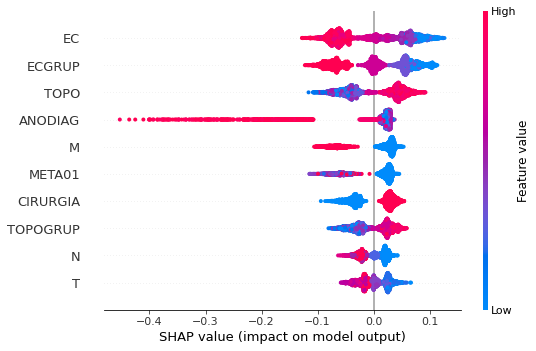

In [ ]:
plot_shap_values(rf_fora, X_test_OS, feat_cols_OS)

### **XGBoost**


The training of the XGBoost model follows the same pattern with `random_state`. A higher weight was also used for the class with fewer examples, using the hyperparameter `scale_pos_weight`.

The hyperparameter `max_depth` was chosen as 10 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

In [ ]:
# SP
xgboost_sp = xgb.XGBClassifier(max_depth=10, 
                               scale_pos_weight=1.13,
                               random_state=seed)

xgboost_sp.fit(X_train_SP, y_train_SP)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=1.13)

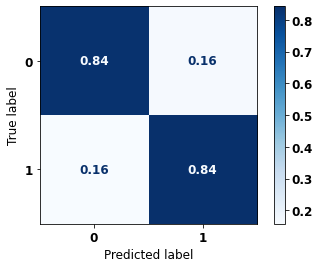

In [ ]:
display_confusion_matrix(xgboost_sp, X_test_SP, y_test_SP)

> The confusion matrix obtained for the XGBoost, with SP data, shows a good performance of the model, with 84% of accuracy.


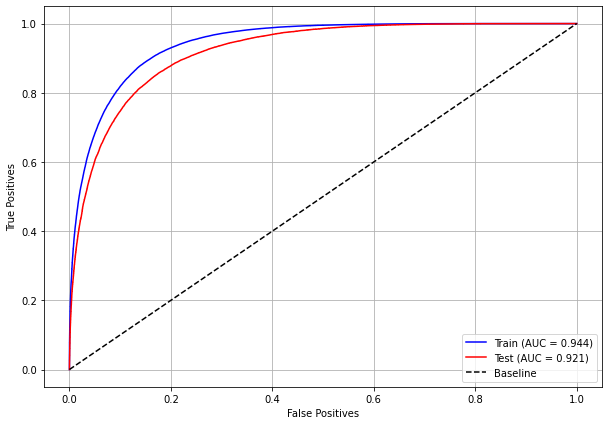

In [ ]:
plot_roc_curve(xgboost_sp, X_train_SP, X_test_SP, y_train_SP, y_test_SP)

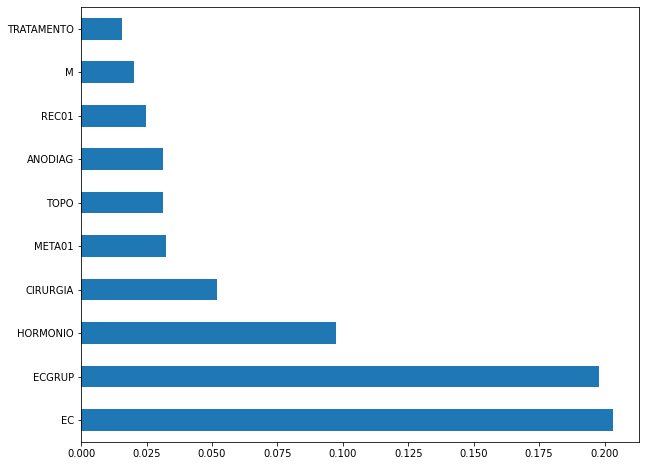

In [ ]:
plot_feat_importances(xgboost_sp, feat_cols_SP)

> The four most important features in the model were `EC`, `ECGRUP`, `HORMONIO` and `CIRURGIA`.

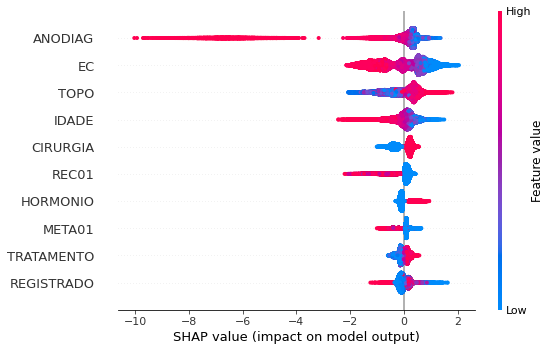

In [ ]:
plot_shap_values(xgboost_sp, X_test_SP, feat_cols_SP)

In [ ]:
# Other states 
xgboost_fora = xgb.XGBClassifier(max_depth=10, 
                                 scale_pos_weight=1.1,
                                 random_state=seed)

xgboost_fora.fit(X_train_OS, y_train_OS)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=1.1)

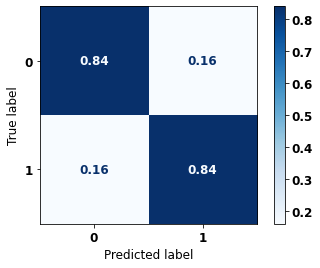

In [ ]:
display_confusion_matrix(xgboost_fora, X_test_OS, y_test_OS)

> The confusion matrix obtained for the XGBoost algorithm, with other states data, shows a good performance of the model, because the model achieves a 84% of accuracy.


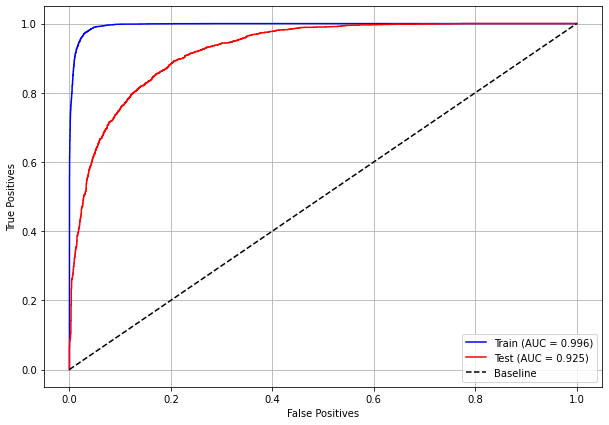

In [ ]:
plot_roc_curve(xgboost_fora, X_train_OS, X_test_OS, y_train_OS, y_test_OS)

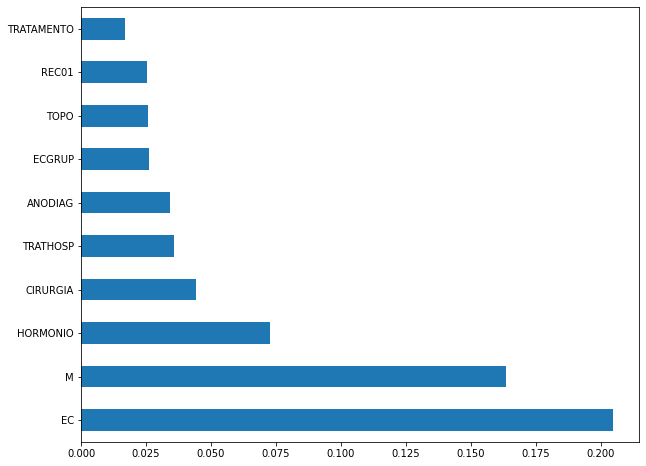

In [ ]:
plot_feat_importances(xgboost_fora, feat_cols_OS)

> The four most important features in the model were `EC`, `M`, `HORMONIO` and `CIRURGIA`.

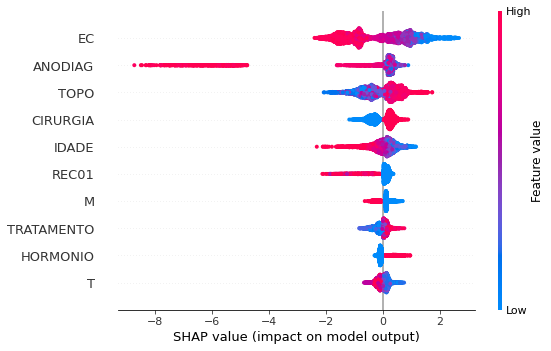

In [ ]:
plot_shap_values(xgboost_fora, X_test_OS, feat_cols_OS)

# **Second approach**

Approach without column `EC` as a feature.

## **Preprocessing**

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation.

First, it is necessary to define the columns that will be used as features and the label. We will not use some columns of the datasets: `UFRESID`, because we already have the division between SP and other states in the two datasets. 

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`, as well as the column `ECGRUP` and not the column `EC`. Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'FAIXAETAR', 'ULTICONS', 'ULTIDIAG', 'ULTITRAT', 
             'obito_geral', 'obito_cancer', 'vivo_ano1', 'vivo_ano3',
             'ULTINFO', 'EC']

# 'RECNENHUM', 'RECLOCAL', 'RECREGIO', 'REC01', 'REC02', 'REC03', 'RECDIST'

lb = 'vivo_ano5'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
X_train_SP, X_test_SP, y_train_SP, y_test_SP, feat_cols_SP = preprocessing(df_SP_ano5, list_drop, lb, 
                                                                           random_state=seed,
                                                                           balance_data=False,
                                                                           encoder_type='LabelEncoder', 
                                                                           norm_name='StandardScaler')

X_train = (261508, 65), X_test = (87170, 65)
y_train = (261508,), y_test = (87170,)


**Other states**

In [ ]:
X_train_OS, X_test_OS, y_train_OS, y_test_OS, feat_cols_OS = preprocessing(df_fora_ano5, list_drop, lb, 
                                                                           random_state=seed,
                                                                           balance_data=False,
                                                                           encoder_type='LabelEncoder', 
                                                                           norm_name='StandardScaler')

X_train = (15419, 65), X_test = (5140, 65)
y_train = (15419,), y_test = (5140,)


## **Training machine learning models**

After dividing the data into training and testing, using the encoder and normalizing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model that will be tested is the Random Forest, for this test the parameter `random_state` will be used, to obtain the same training values of the model every time it is runned.

The hyperparameter `class_weight` was also used, because the model has difficulty learning the class with fewer examples, so using this parameter this class will have a higher weight in the training of the model.

In [ ]:
# SP 
rf_sp = RandomForestClassifier(class_weight={0:1, 1:1.05}, 
                               random_state=seed,
                               criterion='entropy',
                               max_depth=10)

rf_sp.fit(X_train_SP, y_train_SP)

RandomForestClassifier(class_weight={0: 1, 1: 1.05}, criterion='entropy',
                       max_depth=10, random_state=10)

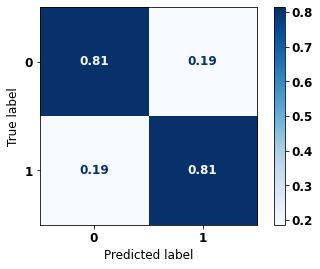

In [ ]:
display_confusion_matrix(rf_sp, X_test_SP, y_test_SP)

> The confusion matrix obtained for the Random Forest, with SP data, shows a good performance of the model, with 81% of accuracy.


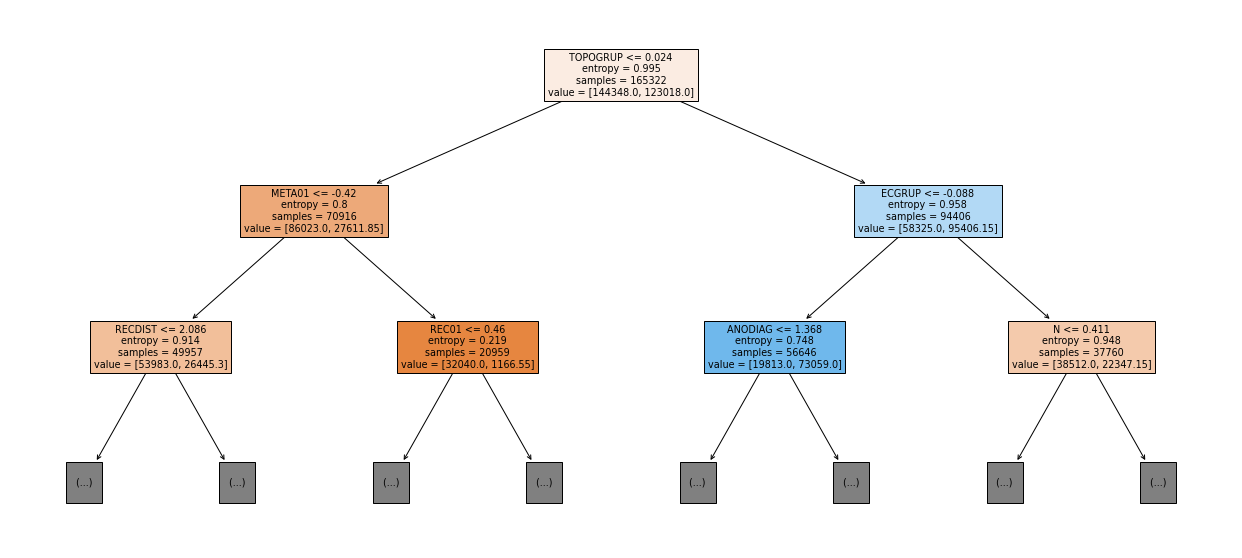

In [ ]:
show_tree(rf_sp, feat_cols_SP, 2)

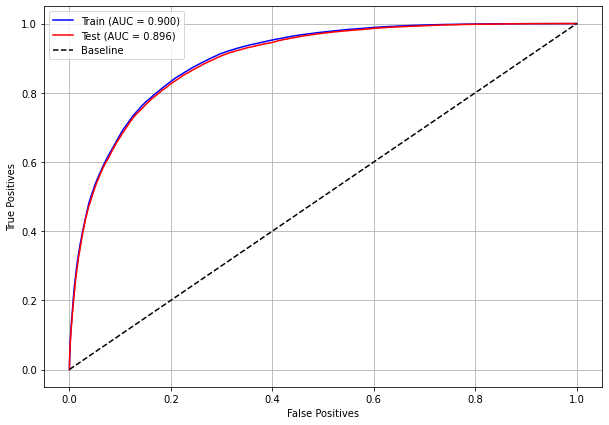

In [ ]:
plot_roc_curve(rf_sp, X_train_SP, X_test_SP, y_train_SP, y_test_SP)

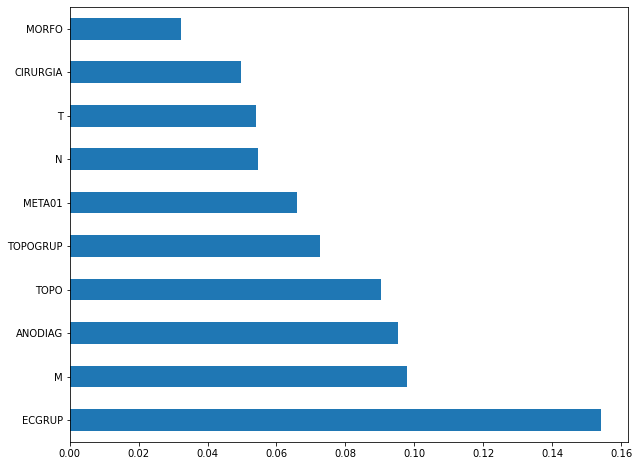

In [ ]:
plot_feat_importances(rf_sp, feat_cols_SP)

> The four most important features in the model were `ECGRUP`, `EC`, `ANODIAG` and `TOPO`.

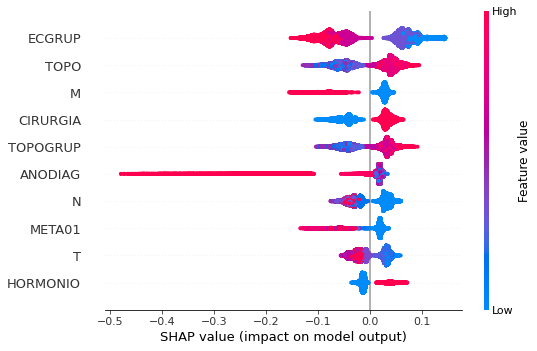

In [ ]:
plot_shap_values(rf_sp, X_test_SP, feat_cols_SP)

In [ ]:
# Other states
rf_fora = RandomForestClassifier(class_weight={0:1.1, 1:1}, 
                                 random_state=seed,
                                 criterion='entropy',
                                 max_depth=10)

rf_fora.fit(X_train_OS, y_train_OS)

RandomForestClassifier(class_weight={0: 1.1, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

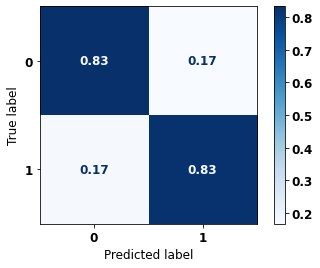

In [ ]:
display_confusion_matrix(rf_fora, X_test_OS, y_test_OS)

> The confusion matrix obtained for the Random Forest algorithm, with other states data, shows a good performance of the model, because the model achieves a 83% of accuracy.


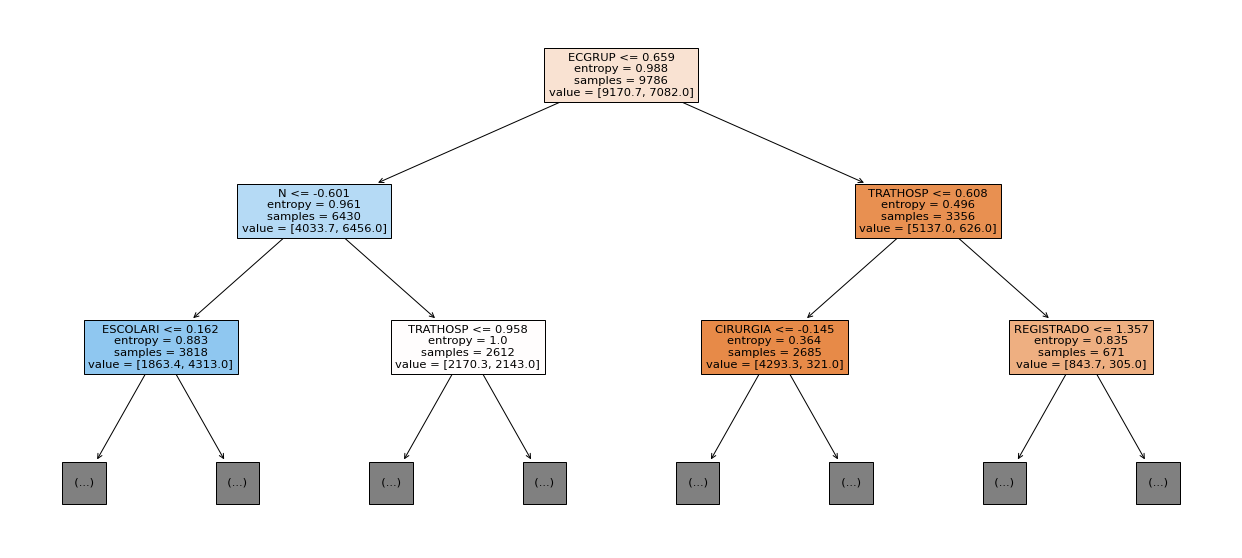

In [ ]:
show_tree(rf_fora, feat_cols_OS, 2)

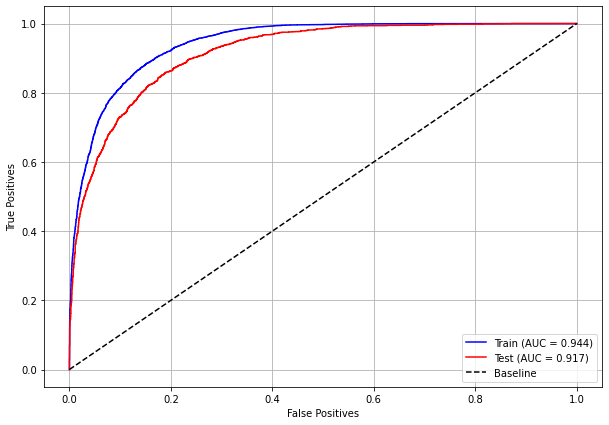

In [ ]:
plot_roc_curve(rf_fora, X_train_OS, X_test_OS, y_train_OS, y_test_OS)

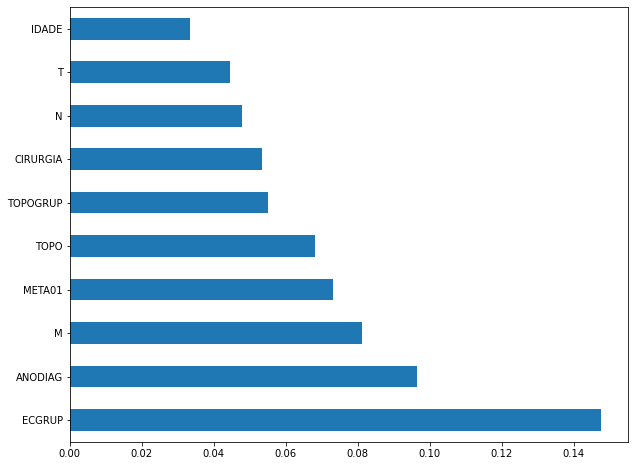

In [ ]:
plot_feat_importances(rf_fora, feat_cols_OS)

> The four most important features in the model were `ECGRUP`, `ANODIAG`, `M` and `META01`.

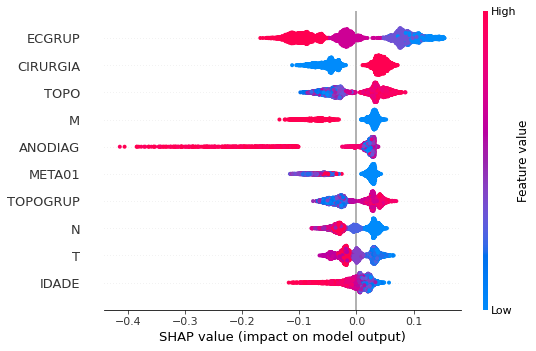

In [ ]:
plot_shap_values(rf_fora, X_test_OS, feat_cols_OS)

### **XGBoost**


The training of the XGBoost model follows the same pattern with `random_state`. A higher weight was also used for the class with fewer examples, using the hyperparameter `scale_pos_weight`.

The hyperparameter `max_depth` was chosen as 10 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

In [ ]:
# SP
xgboost_sp = xgb.XGBClassifier(max_depth=10, 
                               scale_pos_weight=1.1,
                               random_state=seed)

xgboost_sp.fit(X_train_SP, y_train_SP)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=1.1)

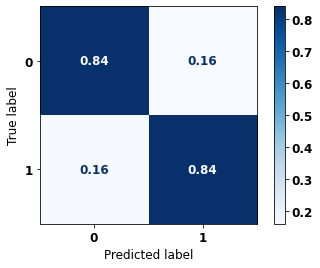

In [ ]:
display_confusion_matrix(xgboost_sp, X_test_SP, y_test_SP)

> The confusion matrix obtained for the XGBoost, with SP data, shows a good performance of the model, with 84% of accuracy.


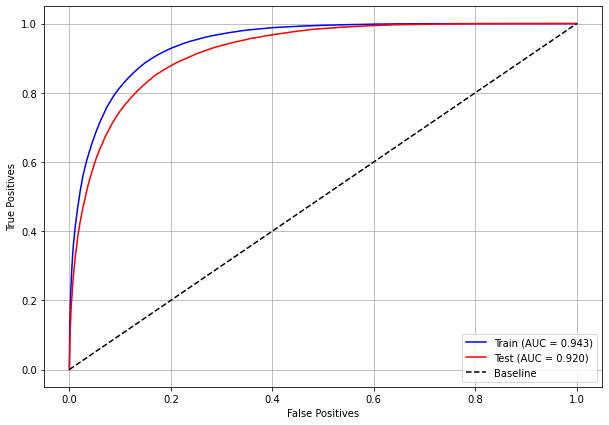

In [ ]:
plot_roc_curve(xgboost_sp, X_train_SP, X_test_SP, y_train_SP, y_test_SP)

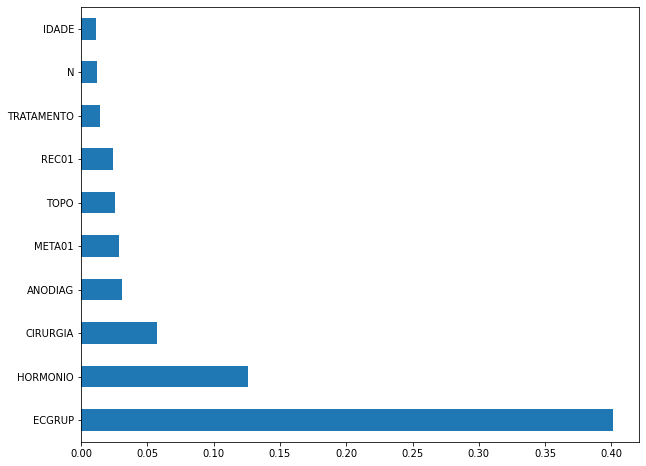

In [ ]:
plot_feat_importances(xgboost_sp, feat_cols_SP)

> The four most important features in the model were `ECGRUP`, `HORMONIO`, `CIRURGIA` and `ANODIAG`.

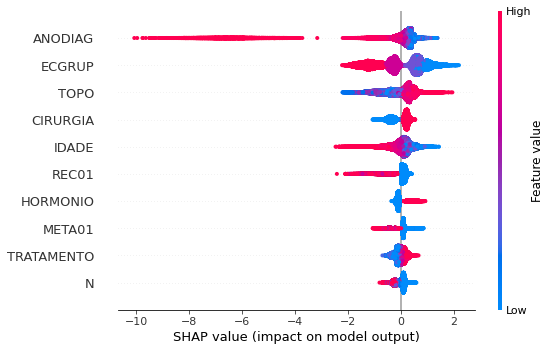

In [ ]:
plot_shap_values(xgboost_sp, X_test_SP, feat_cols_SP)

In [ ]:
# Other states 
xgboost_fora = xgb.XGBClassifier(max_depth=10, 
                                 scale_pos_weight=1.1,
                                 random_state=seed)

xgboost_fora.fit(X_train_OS, y_train_OS)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=1.1)

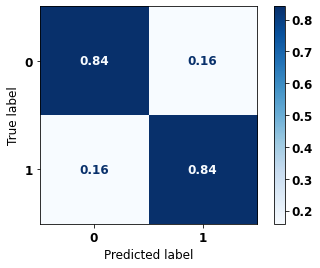

In [ ]:
display_confusion_matrix(xgboost_fora, X_test_OS, y_test_OS)

> The confusion matrix obtained for the XGBoost algorithm, with other states data, shows a good performance of the model, because the model achieves a 84% of accuracy.


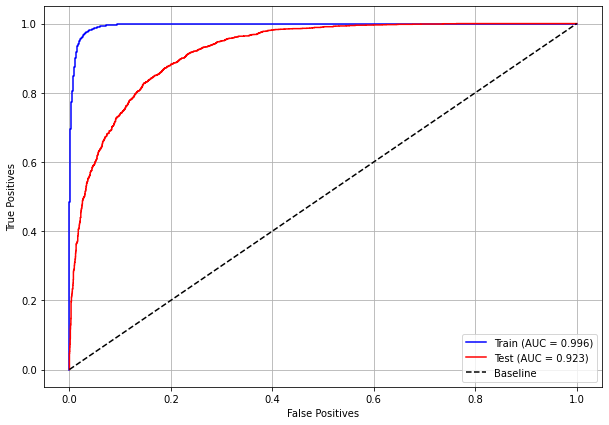

In [ ]:
plot_roc_curve(xgboost_fora, X_train_OS, X_test_OS, y_train_OS, y_test_OS)

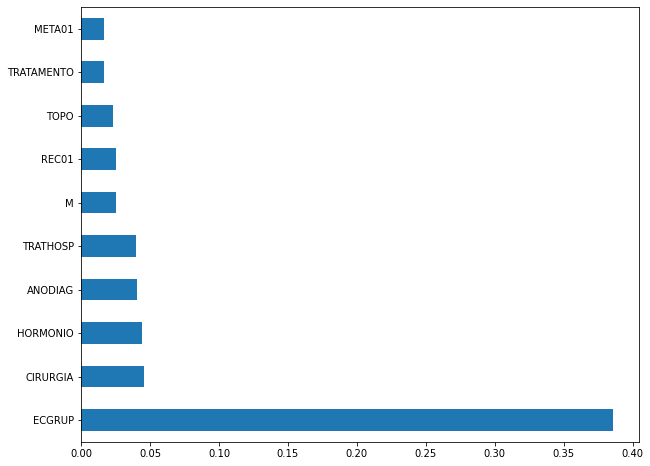

In [ ]:
plot_feat_importances(xgboost_fora, feat_cols_OS)

> The four most important features in the model were `ECGRUP`, with a good advantage, `CIRURGIA`, `HORMONIO` and `ANODIAG`.

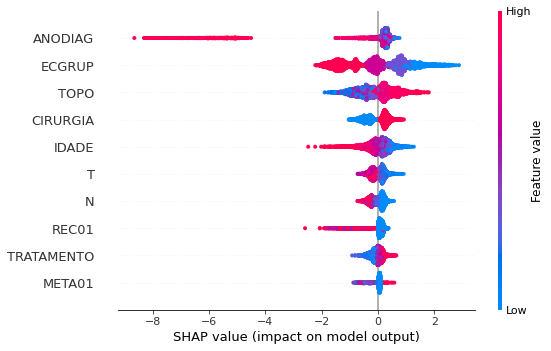

In [ ]:
plot_shap_values(xgboost_fora, X_test_OS, feat_cols_OS)

# **Third approach**

Approach without columns `EC` and `HORMONIO` as features.

## **Preprocessing**

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation.

First, it is necessary to define the columns that will be used as features and the label. We will not use some columns of the datasets: `UFRESID`, because we already have the division between SP and other states in the two datasets.

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`, as well as the column `ECGRUP` and not the column `EC`. Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'FAIXAETAR', 'ULTICONS', 'ULTIDIAG', 'ULTITRAT', 
             'obito_geral', 'obito_cancer', 'vivo_ano1', 'vivo_ano3', 
             'ULTINFO', 'EC', 'HORMONIO']

# 'RECNENHUM', 'RECLOCAL', 'RECREGIO', 'REC01', 'REC02', 'REC03', 'RECDIST'

lb = 'vivo_ano5'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
X_train_SP, X_test_SP, y_train_SP, y_test_SP, feat_cols_SP = preprocessing(df_SP_ano5, list_drop, lb, 
                                                                           random_state=seed,
                                                                           balance_data=False,
                                                                           encoder_type='LabelEncoder', 
                                                                           norm_name='StandardScaler')

X_train = (261508, 64), X_test = (87170, 64)
y_train = (261508,), y_test = (87170,)


**Other states**

In [ ]:
X_train_OS, X_test_OS, y_train_OS, y_test_OS, feat_cols_OS = preprocessing(df_fora_ano5, list_drop, lb, 
                                                                           random_state=seed,
                                                                           balance_data=False,
                                                                           encoder_type='LabelEncoder', 
                                                                           norm_name='StandardScaler')

X_train = (15419, 64), X_test = (5140, 64)
y_train = (15419,), y_test = (5140,)


## **Training machine learning models**

After dividing the data into training and testing, using the encoder and normalizing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model that will be tested is the Random Forest, for this test the parameter `random_state` will be used, to obtain the same training values of the model every time it is runned.

The hyperparameter `class_weight` was also used, because the model has difficulty learning the class with fewer examples, so using this parameter this class will have a higher weight in the training of the model.

In [ ]:
# SP 
rf_sp = RandomForestClassifier(class_weight={0:1, 1:1.03}, 
                               random_state=seed,
                               criterion='entropy',
                               max_depth=10)

rf_sp.fit(X_train_SP, y_train_SP)

RandomForestClassifier(class_weight={0: 1, 1: 1.03}, criterion='entropy',
                       max_depth=10, random_state=10)

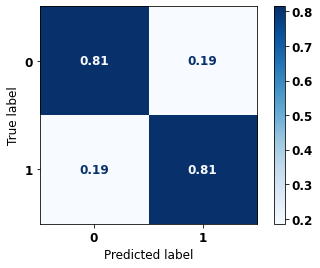

In [ ]:
display_confusion_matrix(rf_sp, X_test_SP, y_test_SP)

> The confusion matrix obtained for the Random Forest, with SP data, shows a good performance of the model, with 81% of accuracy.


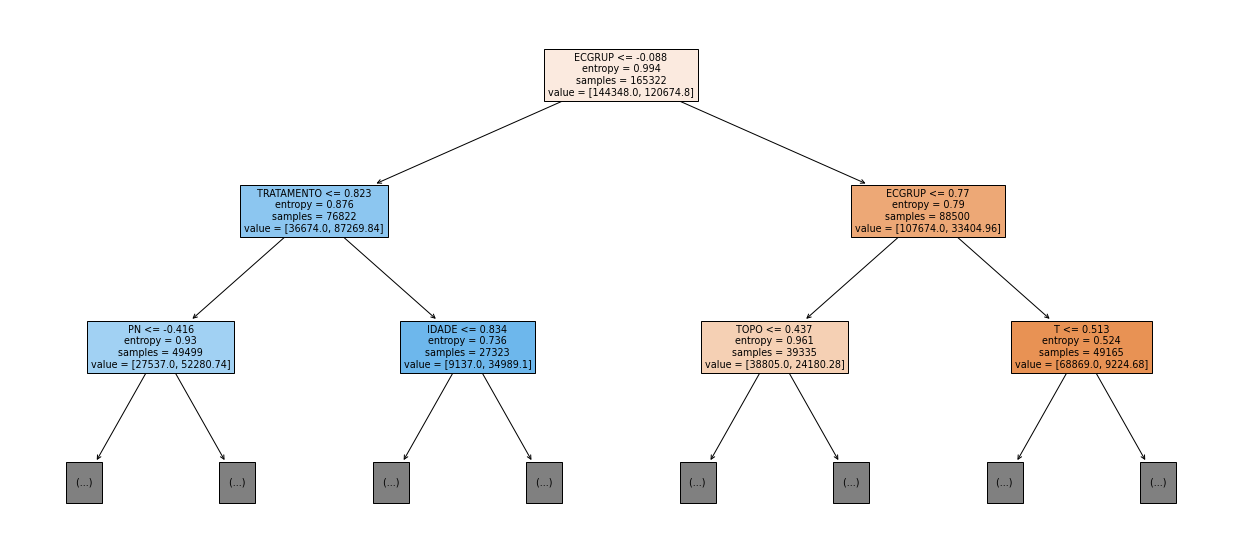

In [ ]:
show_tree(rf_sp, feat_cols_SP, 2)

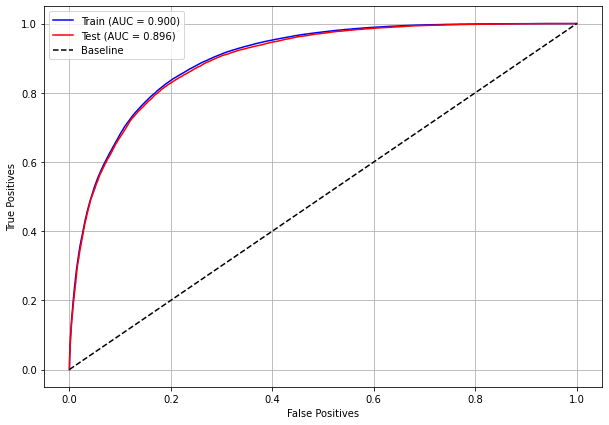

In [ ]:
plot_roc_curve(rf_sp, X_train_SP, X_test_SP, y_train_SP, y_test_SP)

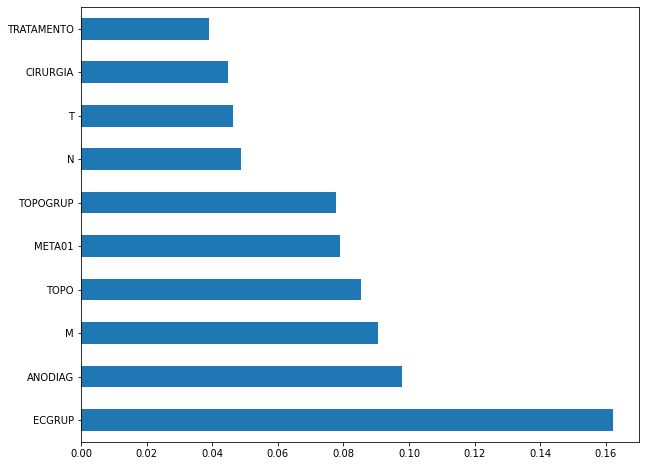

In [ ]:
plot_feat_importances(rf_sp, feat_cols_SP)

> The four most important features in the model were `ECGRUP`, `ANODIAG`, `M` and `TOPO`.

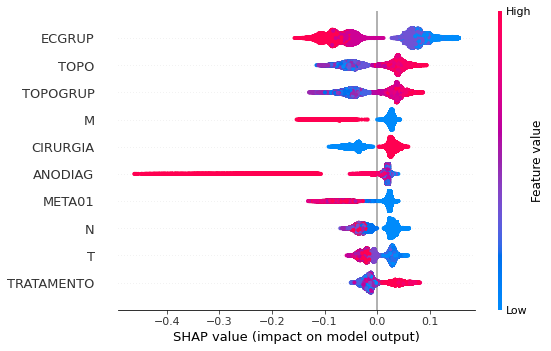

In [ ]:
plot_shap_values(rf_sp, X_test_SP, feat_cols_SP)

In [ ]:
# Other states
rf_fora = RandomForestClassifier(class_weight={0:1.1, 1:1}, 
                                 random_state=seed,
                                 criterion='entropy',
                                 max_depth=10)

rf_fora.fit(X_train_OS, y_train_OS)

RandomForestClassifier(class_weight={0: 1.1, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

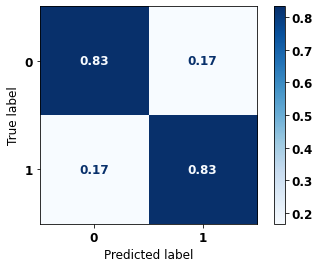

In [ ]:
display_confusion_matrix(rf_fora, X_test_OS, y_test_OS)

> The confusion matrix obtained for the Random Forest algorithm, with other states data, shows a good performance of the model, because the model achieves a 83% of accuracy.


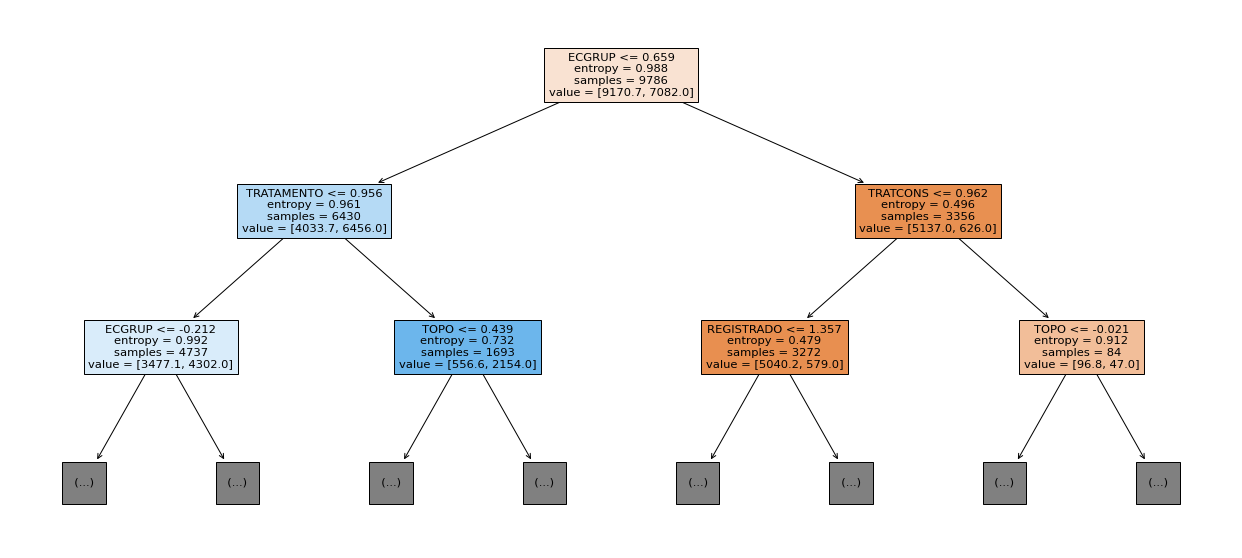

In [ ]:
show_tree(rf_fora, feat_cols_OS, 2)

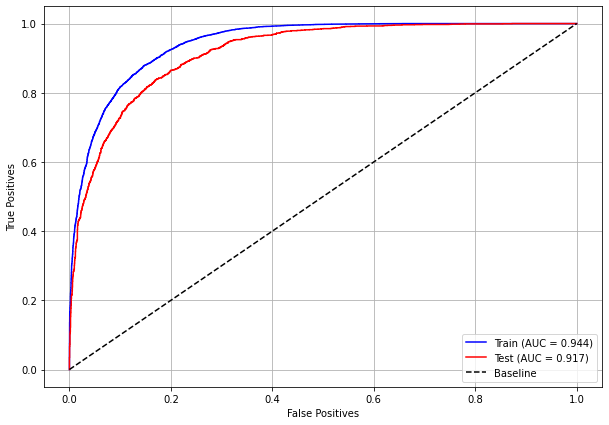

In [ ]:
plot_roc_curve(rf_fora, X_train_OS, X_test_OS, y_train_OS, y_test_OS)

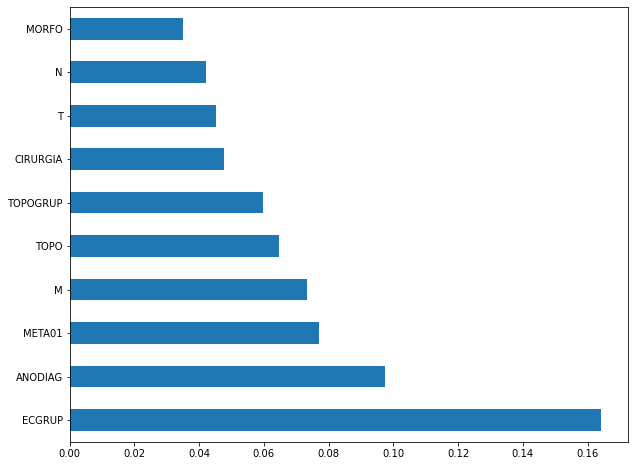

In [ ]:
plot_feat_importances(rf_fora, feat_cols_OS)

> The four most important features in the model were `ECGRUP`, `ANODIAG`, `META01` and `M`.

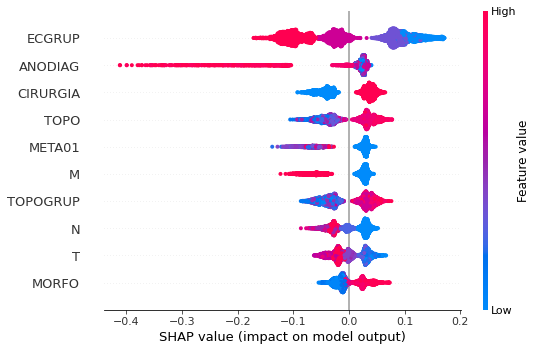

In [ ]:
plot_shap_values(rf_fora, X_test_OS, feat_cols_OS)

### **XGBoost**


The training of the XGBoost model follows the same pattern with `random_state`. A higher weight was also used for the class with fewer examples, using the hyperparameter `scale_pos_weight`.

The hyperparameter `max_depth` was chosen as 10 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

In [ ]:
# SP
xgboost_sp = xgb.XGBClassifier(max_depth=10, 
                               scale_pos_weight=1.1,
                               random_state=seed)

xgboost_sp.fit(X_train_SP, y_train_SP)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=1.1)

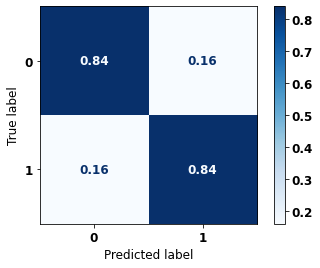

In [ ]:
display_confusion_matrix(xgboost_sp, X_test_SP, y_test_SP)

> The confusion matrix obtained for the XGBoost, with SP data, shows a good performance of the model, with 84% of accuracy.


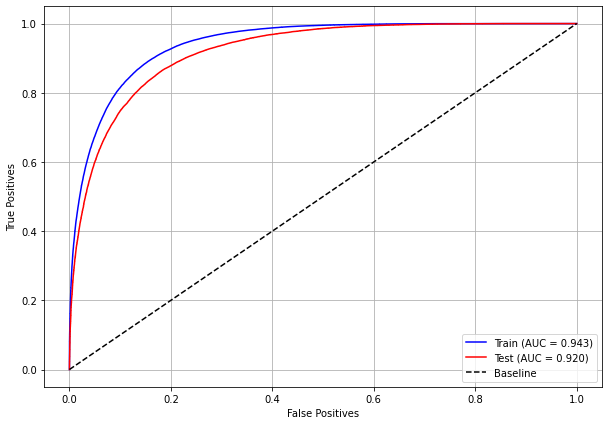

In [ ]:
plot_roc_curve(xgboost_sp, X_train_SP, X_test_SP, y_train_SP, y_test_SP)

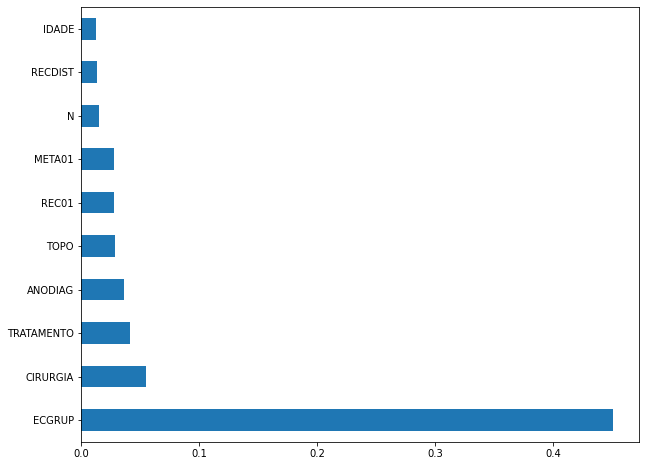

In [ ]:
plot_feat_importances(xgboost_sp, feat_cols_SP)

> The four most important features in the model were `ECGRUP`, `CIRURGIA`, `TRATAMENTO` and `ANODIAG`.

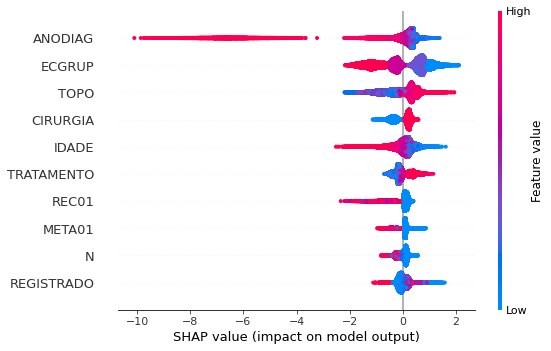

In [ ]:
plot_shap_values(xgboost_sp, X_test_SP, feat_cols_SP)

In [ ]:
# Other states 
xgboost_fora = xgb.XGBClassifier(max_depth=10, 
                                 scale_pos_weight=1,
                                 random_state=seed)

xgboost_fora.fit(X_train_OS, y_train_OS)

XGBClassifier(max_depth=10, random_state=10)

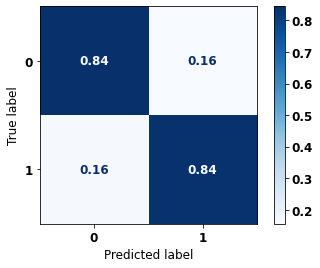

In [ ]:
display_confusion_matrix(xgboost_fora, X_test_OS, y_test_OS)

> The confusion matrix obtained for the XGBoost algorithm, with other states data, shows a good performance of the model, because the model achieves a 84% of accuracy.


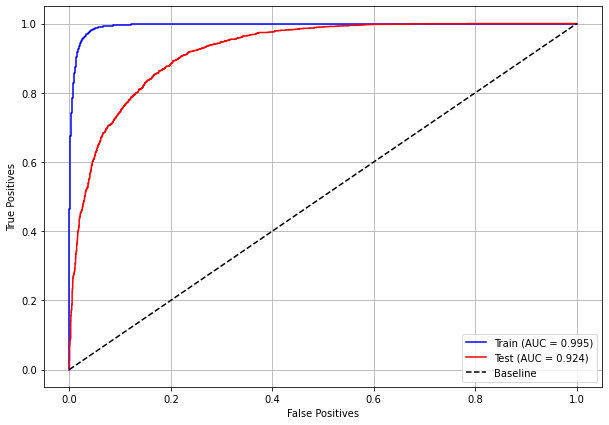

In [ ]:
plot_roc_curve(xgboost_fora, X_train_OS, X_test_OS, y_train_OS, y_test_OS)

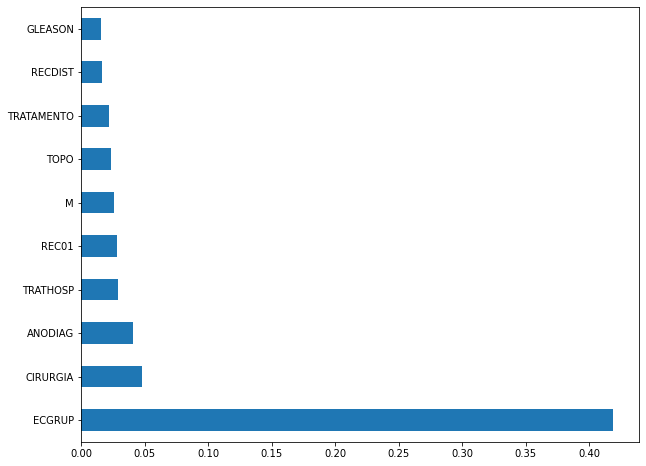

In [ ]:
plot_feat_importances(xgboost_fora, feat_cols_OS)

> The four most important features in the model were `ECGRUP`, `CIRURGIA`, `ANODIAG` and `TRATHOSP`.

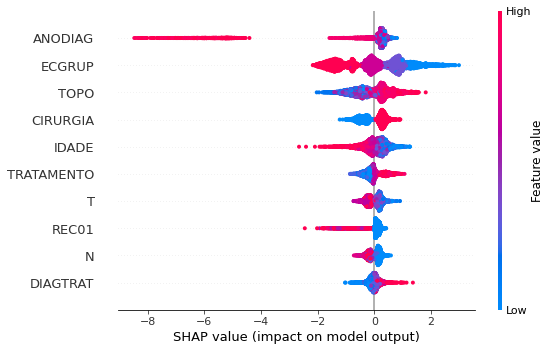

In [ ]:
plot_shap_values(xgboost_fora, X_test_OS, feat_cols_OS)

# **Fourth approach**

Approach with grouped years and without the column `EC`.

## **Preprocessing**

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation. We will use the years grouped too, resulting in 5 datasets for SP and more 5 for other states.

First, it is necessary to define the columns that will be used as features and the label. We will not use some columns of the datasets: `UFRESID`, because we already have the division between SP and other states in the two datasets.

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`, as well as the column `ECGRUP` and not the column `EC`. Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'FAIXAETAR', 'ULTICONS', 'ULTIDIAG', 'ULTITRAT', 
             'obito_geral', 'obito_cancer', 'vivo_ano1', 'vivo_ano3', 'ULTINFO', 
             'EC']

# 'RECNENHUM', 'RECLOCAL', 'RECREGIO', 'REC01', 'REC02', 'REC03', 'RECDIST'

lb = 'vivo_ano5'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

The process will be done 5 times for SP and other states, using the datasets with grouped years.

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

### **SP**

In [ ]:
X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03, feat_SP_00_03 = preprocessing(df_SP_ano5, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2000, 
                                                                                                last_year=2003, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (44789, 65), X_test = (14930, 65)
y_train = (44789,), y_test = (14930,)


In [ ]:
X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07, feat_SP_04_07 = preprocessing(df_SP_ano5, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2004, 
                                                                                                last_year=2007,
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')                                                            

X_train = (55804, 65), X_test = (18602, 65)
y_train = (55804,), y_test = (18602,)


In [ ]:
X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11, feat_SP_08_11 = preprocessing(df_SP_ano5, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2008, 
                                                                                                last_year=2011, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (73620, 65), X_test = (24541, 65)
y_train = (73620,), y_test = (24541,)


In [ ]:
X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15, feat_SP_12_15 = preprocessing(df_SP_ano5, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2012, 
                                                                                                last_year=2015, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (65896, 65), X_test = (21966, 65)
y_train = (65896,), y_test = (21966,)


### **Other states**

In [ ]:
X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03, feat_OS_00_03 = preprocessing(df_fora_ano5, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2000, 
                                                                                                last_year=2003, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (2588, 65), X_test = (863, 65)
y_train = (2588,), y_test = (863,)


In [ ]:
X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07, feat_OS_04_07 = preprocessing(df_fora_ano5, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2004, 
                                                                                                last_year=2007, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (3396, 65), X_test = (1133, 65)
y_train = (3396,), y_test = (1133,)


In [ ]:
X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11, feat_OS_08_11 = preprocessing(df_fora_ano5, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2008, 
                                                                                                last_year=2011, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (3926, 65), X_test = (1309, 65)
y_train = (3926,), y_test = (1309,)


In [ ]:
X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15, feat_OS_12_15 = preprocessing(df_fora_ano5, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2012, 
                                                                                                last_year=2015, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (3814, 65), X_test = (1272, 65)
y_train = (3814,), y_test = (1272,)


## **Training and evaluation of the models**

After dividing the data into training and testing, using the encoder and normalizing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model is the Random Forest, the `random_state` will be used as a parameter, to obtain the same training values of the model every time it is runned.

The hyperparameter `class_weight` was used because the models have difficulty to learn the class with fewer examples.

**SP**

In [ ]:
# SP - 2000 to 2003
rf_sp_00_03 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:1},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_00_03.fit(X_trainSP_00_03, y_trainSP_00_03)

RandomForestClassifier(class_weight={0: 1, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

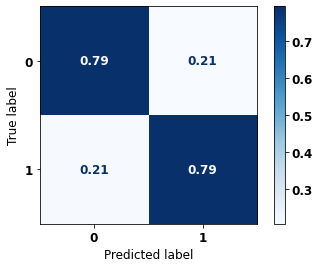

In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_00_03, y_testSP_00_03)

> The confusion matrix obtained for the Random Forest, with SP data from 2000 to 2003, shows a good performance of the model, with 79% of accuracy.


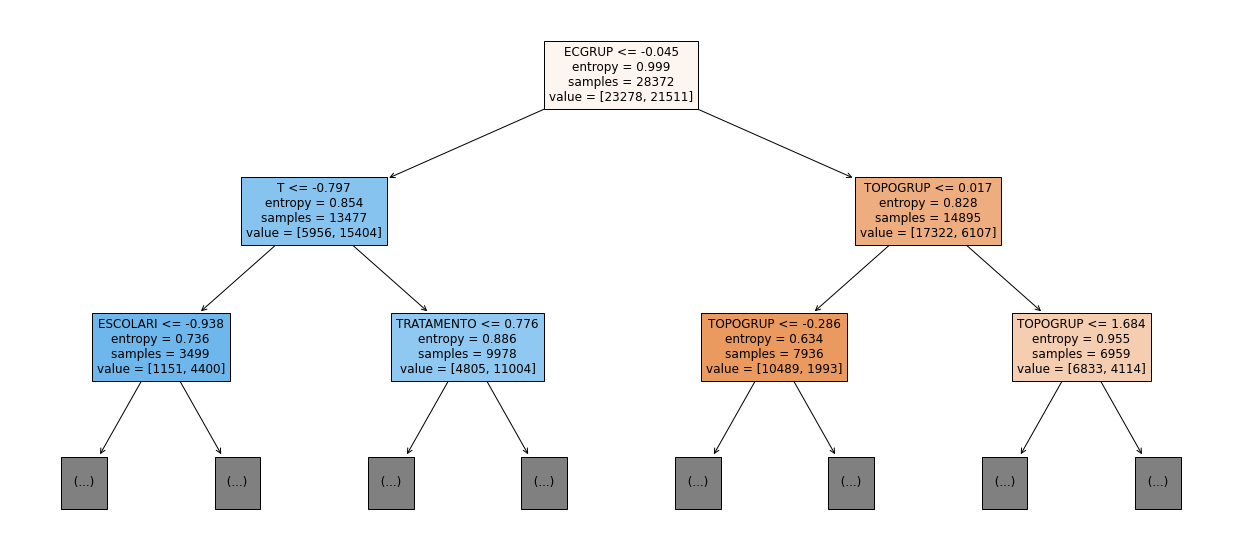

In [ ]:
show_tree(rf_sp_00_03, feat_SP_00_03, 2)

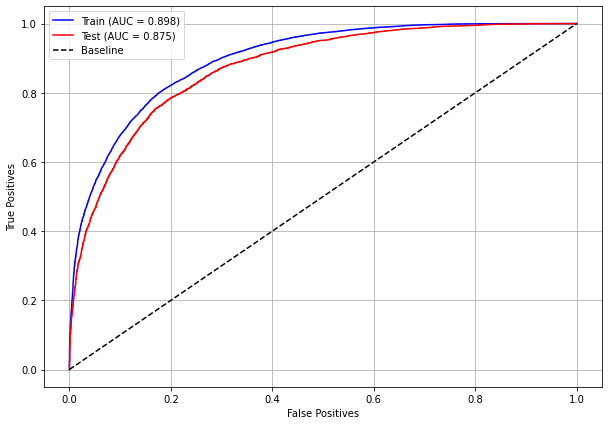

In [ ]:
plot_roc_curve(rf_sp_00_03, X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03)

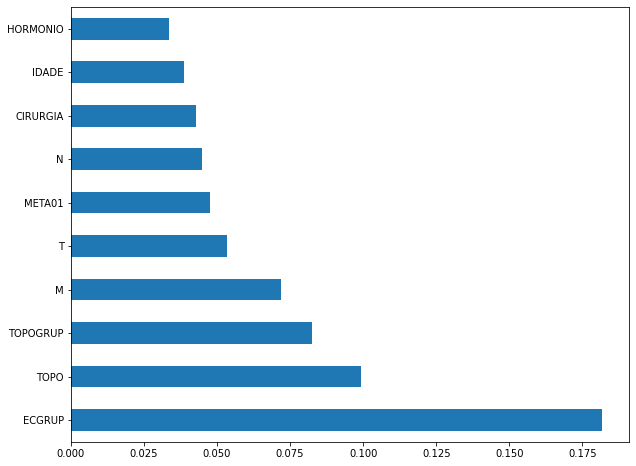

In [ ]:
plot_feat_importances(rf_sp_00_03, feat_SP_00_03)

> The four most important features in the model were `ECGRUP`, `TOPO`, `TOPOGRUP`, and `M`. 

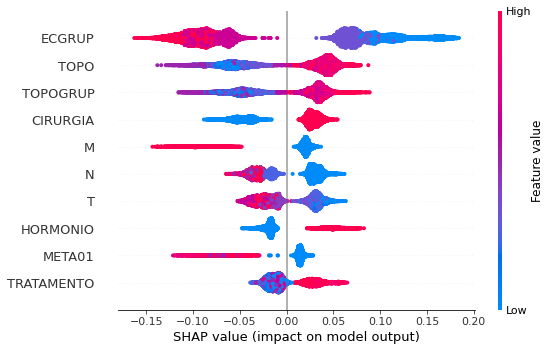

In [ ]:
plot_shap_values(rf_sp_00_03, X_testSP_00_03, feat_SP_00_03)

In [ ]:
# SP - 2004 to 2007
rf_sp_04_07 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1.2, 1:1},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_04_07.fit(X_trainSP_04_07, y_trainSP_04_07)

RandomForestClassifier(class_weight={0: 1.2, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

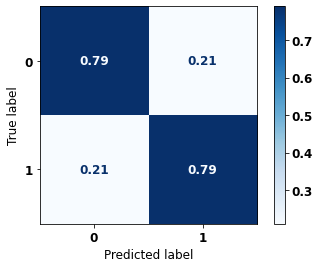

In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_04_07, y_testSP_04_07)

> The confusion matrix obtained for the Random Forest, with SP data from 2004 to 2007, shows a good performance of the model, with 79% of accuracy.

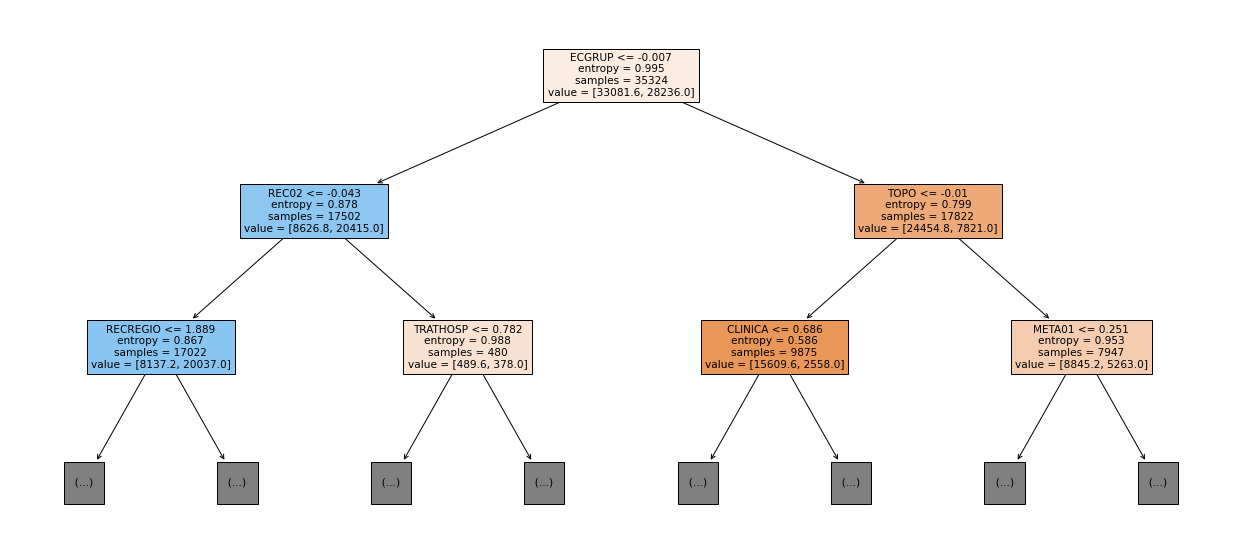

In [ ]:
show_tree(rf_sp_04_07, feat_SP_04_07, 2)

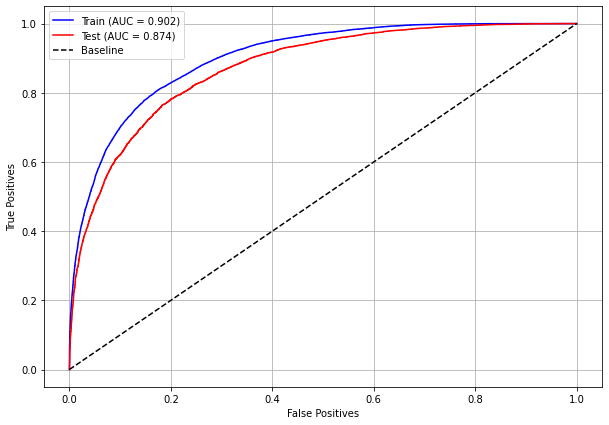

In [ ]:
plot_roc_curve(rf_sp_04_07, X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07)

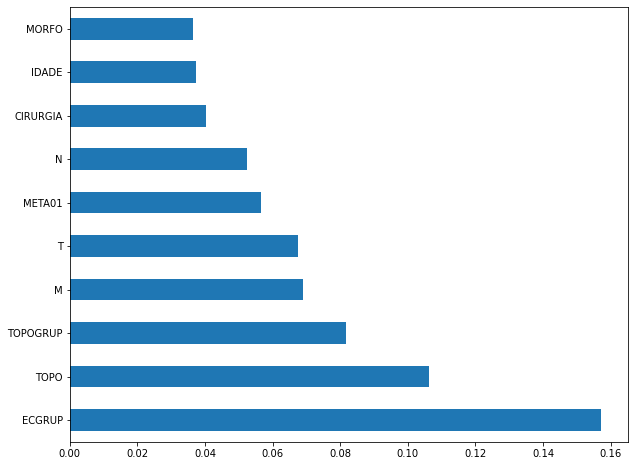

In [ ]:
plot_feat_importances(rf_sp_04_07, feat_SP_04_07)

> The four most important features in the model were `ECGRUP`, `TOPO`, `TOPOGRUP` and `M`.

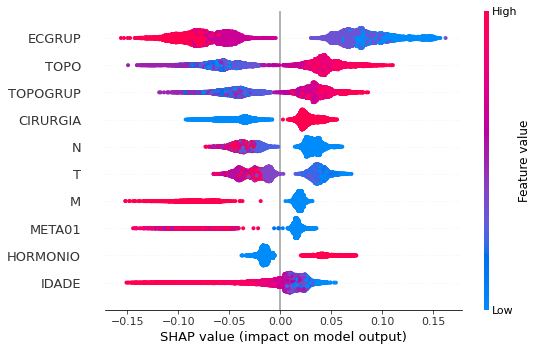

In [ ]:
plot_shap_values(rf_sp_04_07, X_testSP_04_07, feat_SP_04_07)

In [ ]:
# SP - 2008 to 2011
rf_sp_08_11 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1.25, 1:1},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_08_11.fit(X_trainSP_08_11, y_trainSP_08_11)

RandomForestClassifier(class_weight={0: 1.25, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

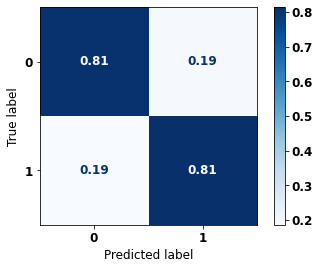

In [ ]:
display_confusion_matrix(rf_sp_08_11, X_testSP_08_11, y_testSP_08_11)

> The confusion matrix obtained for the Random Forest, with SP data from 2008 to 2011, shows a good performance of the model, with 81% of accuracy.

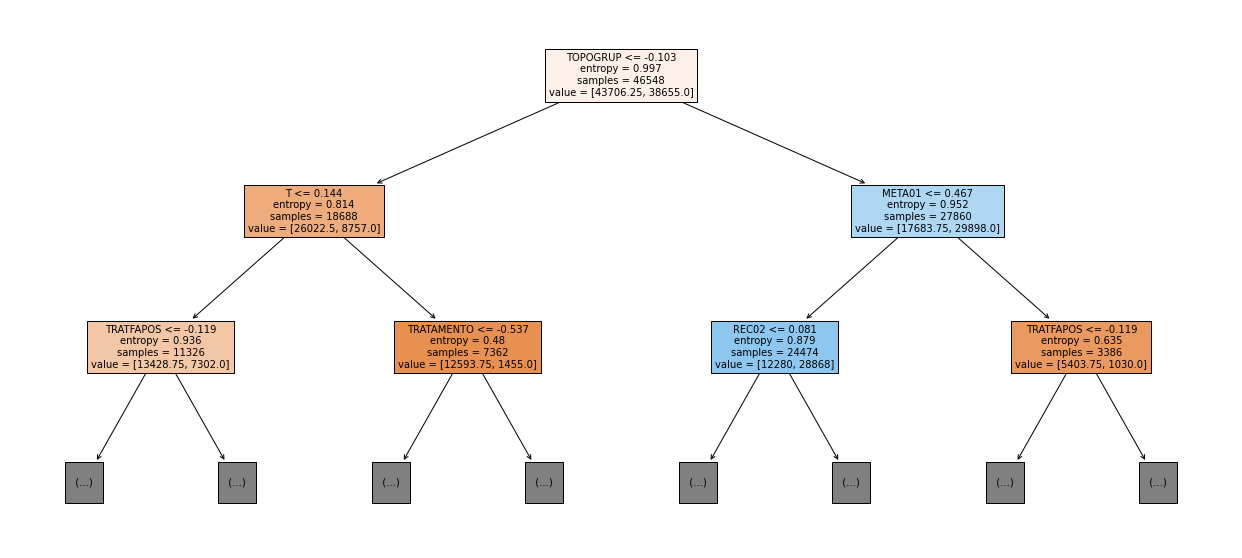

In [ ]:
show_tree(rf_sp_08_11, feat_SP_08_11, 2)

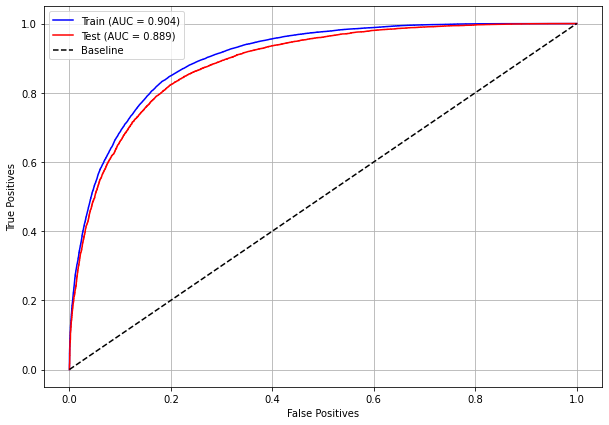

In [ ]:
plot_roc_curve(rf_sp_08_11, X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11)

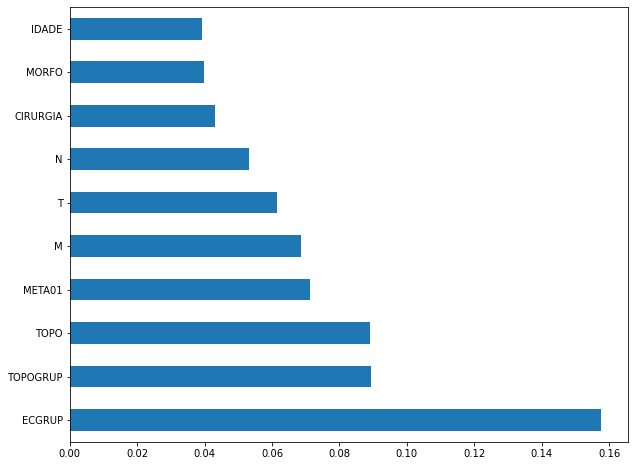

In [ ]:
plot_feat_importances(rf_sp_08_11, feat_SP_08_11)

> The four most important features in the model were `ECGRUP`, `TOPOGRUP`, `TOPO` and `META01`.

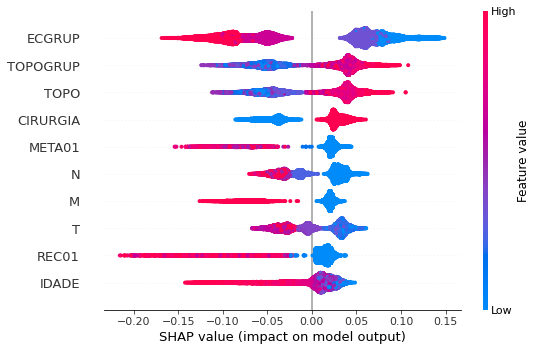

In [ ]:
plot_shap_values(rf_sp_08_11, X_testSP_08_11, feat_SP_08_11)

In [ ]:
# SP - 2012 to 2015
rf_sp_12_15 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:1.137},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_12_15.fit(X_trainSP_12_15, y_trainSP_12_15)

RandomForestClassifier(class_weight={0: 1, 1: 1.137}, criterion='entropy',
                       max_depth=10, random_state=10)

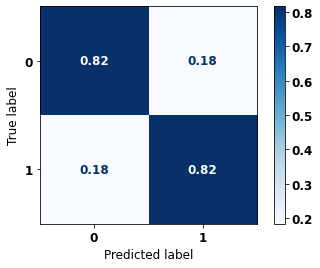

In [ ]:
display_confusion_matrix(rf_sp_12_15, X_testSP_12_15, y_testSP_12_15)

> The confusion matrix obtained for the Random Forest, with SP data from 2012 to 2015, shows a good performance of the model with 82% of accuracy.

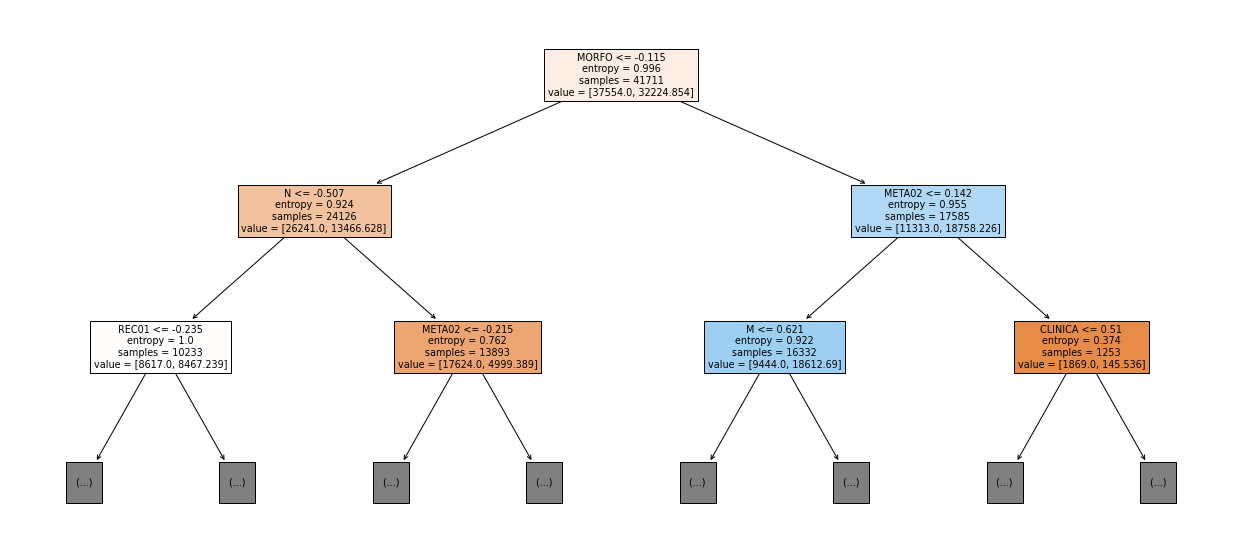

In [ ]:
show_tree(rf_sp_12_15, feat_SP_12_15, 2)

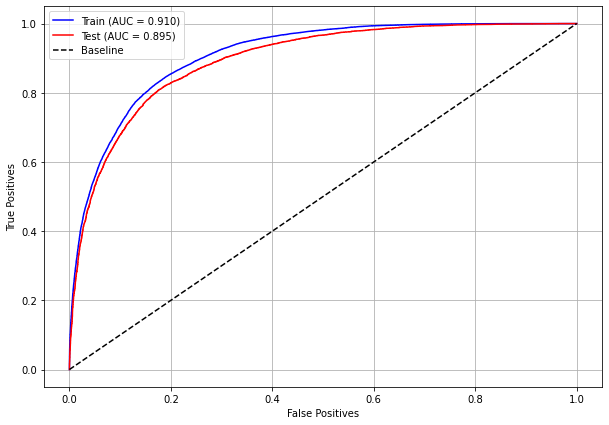

In [ ]:
plot_roc_curve(rf_sp_12_15, X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15)

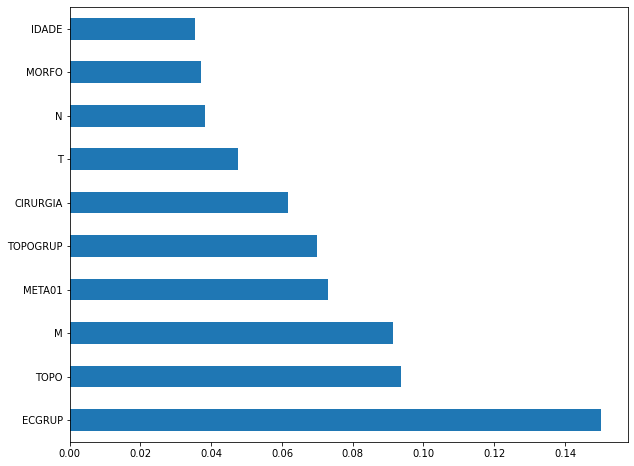

In [ ]:
plot_feat_importances(rf_sp_12_15, feat_SP_12_15)

> The four most important features in the model were `ECGRUP`, `TOPO`, `M` and `META01`.

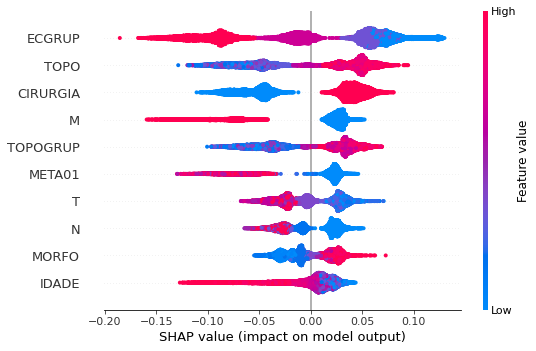

In [ ]:
plot_shap_values(rf_sp_12_15, X_testSP_12_15, feat_SP_12_15)

**Other states**

In [ ]:
# Other states - 2000 to 2003
rf_fora_00_03 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1.45, 1:1},
                                       criterion='entropy',
                                       max_depth=10)

rf_fora_00_03.fit(X_trainOS_00_03, y_trainOS_00_03)

RandomForestClassifier(class_weight={0: 1.45, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

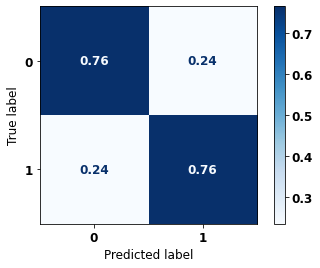

In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_00_03, y_testOS_00_03)

> The confusion matrix obtained for the Random Forest, with other states data from 2000 to 2003, also shows a good performance of the model, and we have a balanced main diagonal with 76% of accuracy.

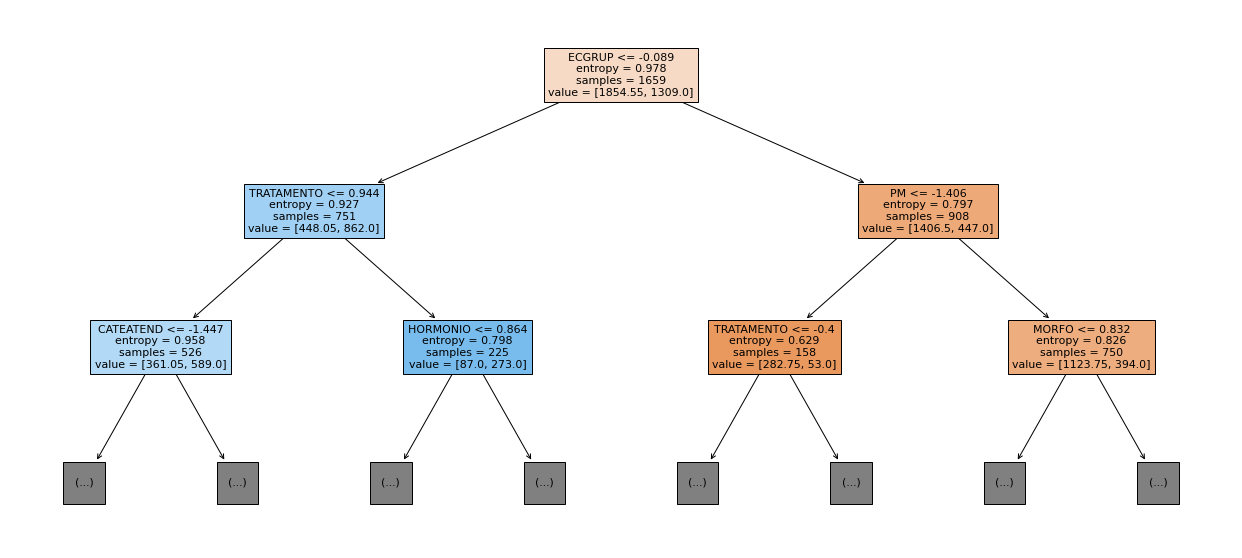

In [ ]:
show_tree(rf_fora_00_03, feat_OS_00_03, 2)

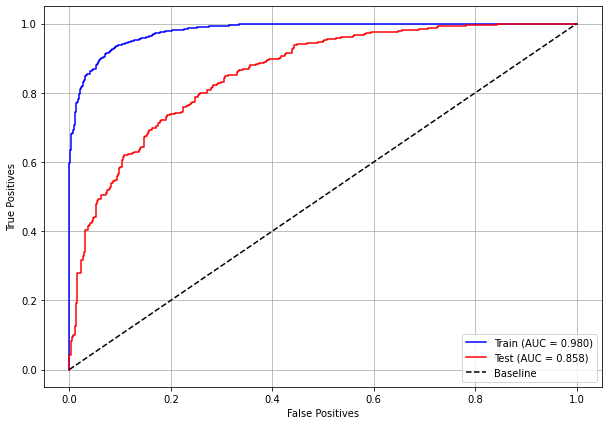

In [ ]:
plot_roc_curve(rf_fora_00_03, X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03)

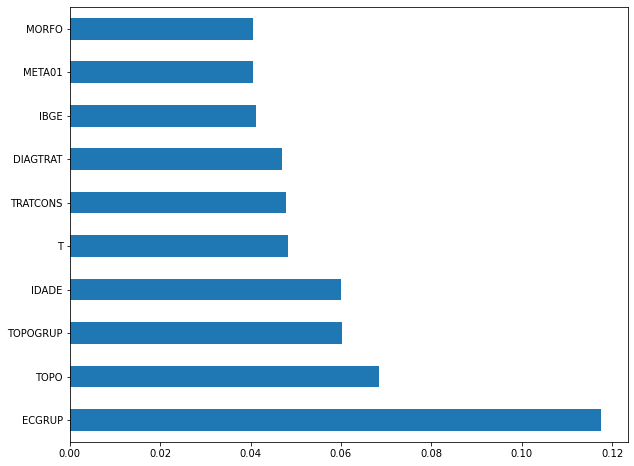

In [ ]:
plot_feat_importances(rf_fora_00_03, feat_OS_00_03)

> The four most important features in the model were `ECGRUP`, `TOPO`, `TOPOGRUP` and `IDADE`.

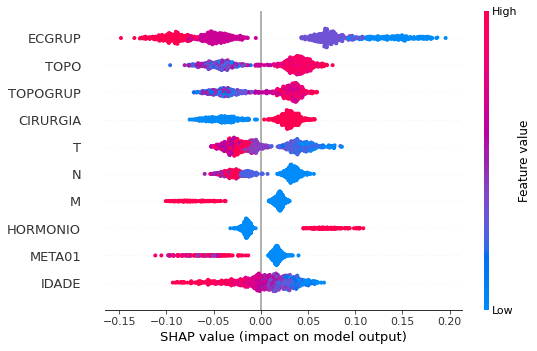

In [ ]:
plot_shap_values(rf_fora_00_03, X_testOS_00_03, feat_OS_00_03)

In [ ]:
# Other states - 2004 to 2007
rf_fora_04_07 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1.45, 1:1},
                                       criterion='entropy',
                                       max_depth=10)

rf_fora_04_07.fit(X_trainOS_04_07, y_trainOS_04_07)

RandomForestClassifier(class_weight={0: 1.45, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

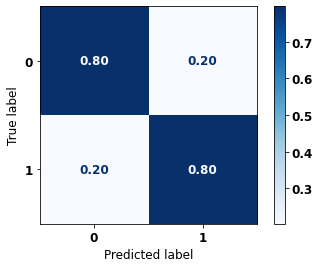

In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_04_07, y_testOS_04_07)

> The confusion matrix obtained for the Random Forest, with other states data from 2004 to 2007, also shows a good performance of the model, with 80% of accuracy.


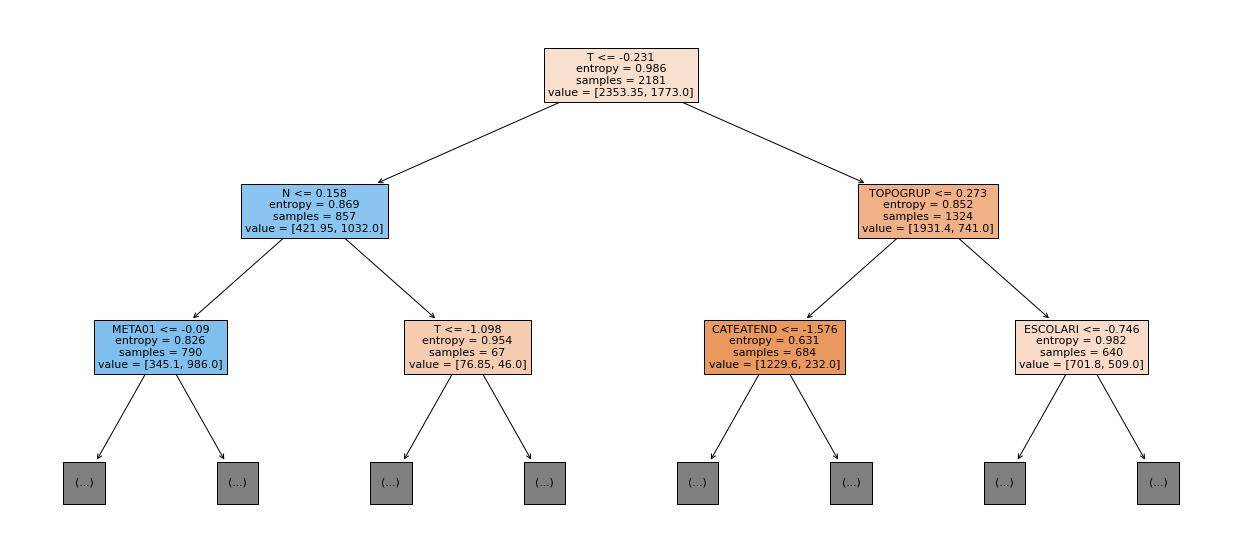

In [ ]:
show_tree(rf_fora_04_07, feat_OS_04_07, 2)

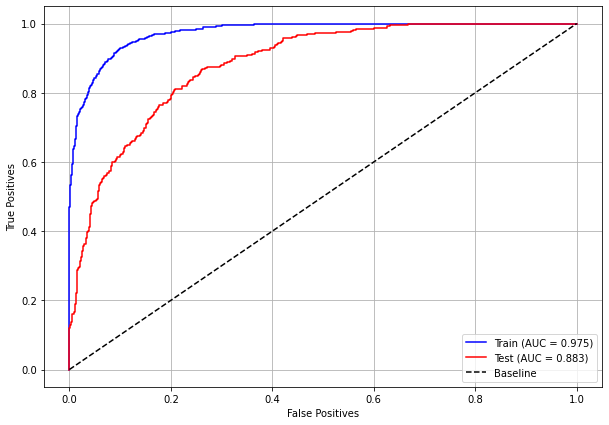

In [ ]:
plot_roc_curve(rf_fora_04_07, X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07)

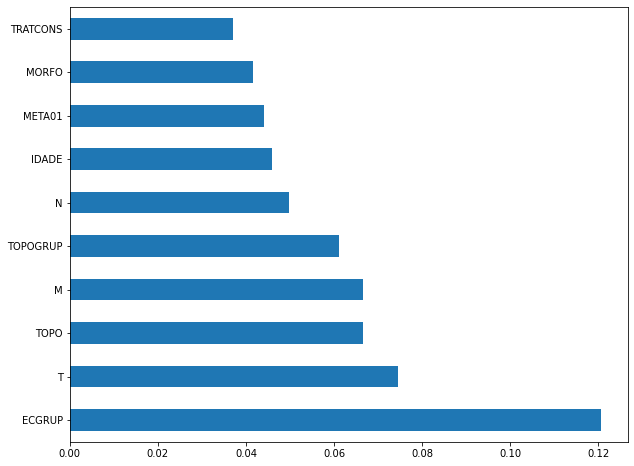

In [ ]:
plot_feat_importances(rf_fora_04_07, feat_OS_04_07)

> The four most important features in the model were `ECGRUP`, `T`, `TOPO` and `M`.

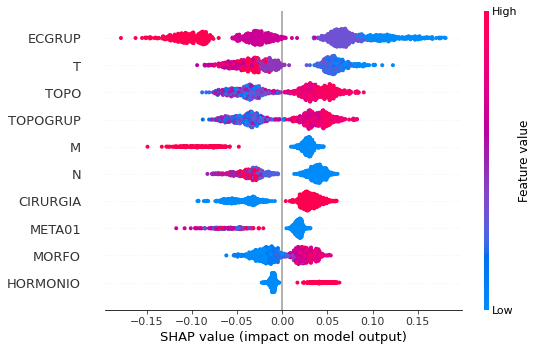

In [ ]:
plot_shap_values(rf_fora_04_07, X_testOS_04_07, feat_OS_04_07)

In [ ]:
# Other states - 2008 to 2011
rf_fora_08_11 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1.5793, 1:1},
                                       criterion='entropy',
                                       max_depth=10)

rf_fora_08_11.fit(X_trainOS_08_11, y_trainOS_08_11)

RandomForestClassifier(class_weight={0: 1.5793, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

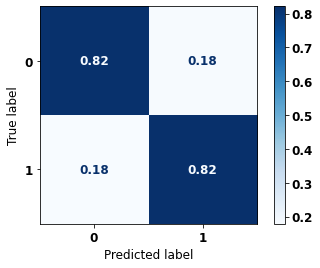

In [ ]:
display_confusion_matrix(rf_fora_08_11, X_testOS_08_11, y_testOS_08_11)

> The confusion matrix obtained for the Random Forest, with other states data from 2008 to 2011, also shows a good performance of the model, presenting 82% of accuracy.


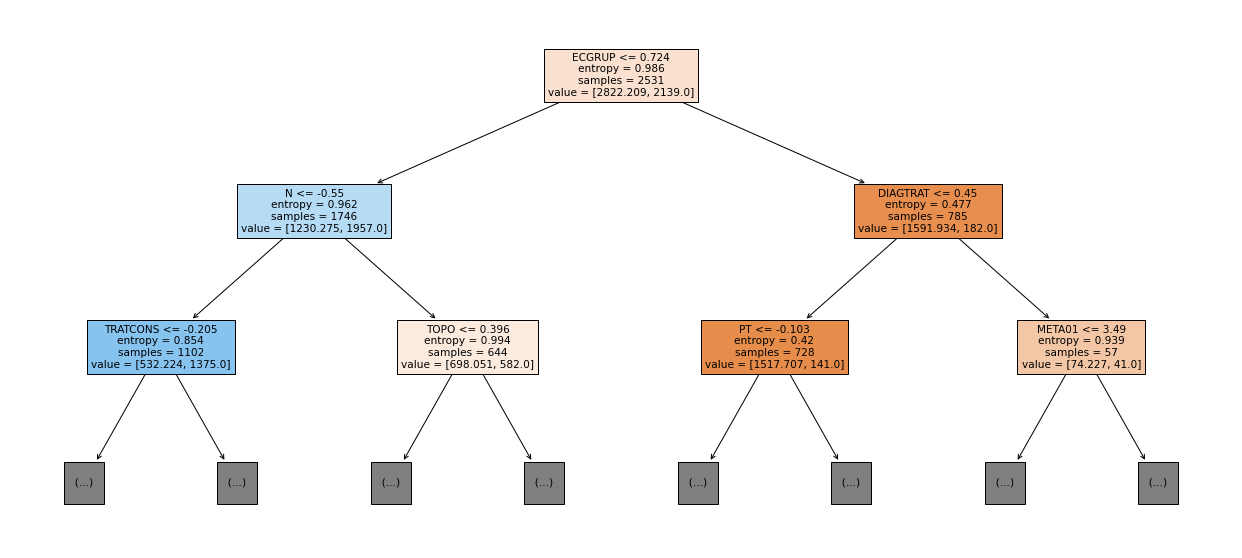

In [ ]:
show_tree(rf_fora_08_11, feat_OS_08_11, 2)

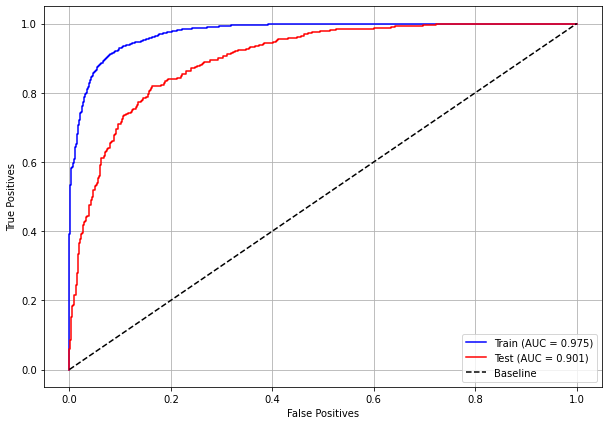

In [ ]:
plot_roc_curve(rf_fora_08_11, X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11)

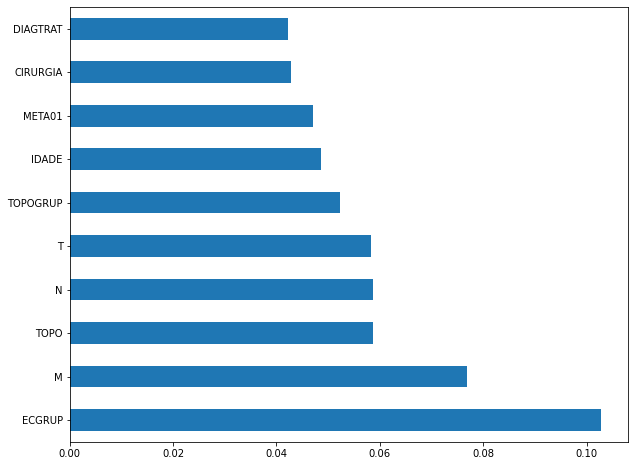

In [ ]:
plot_feat_importances(rf_fora_08_11, feat_OS_08_11)

> The four most important features in the model were `ECGRUP`, `M`, `TOPO` and `N`.

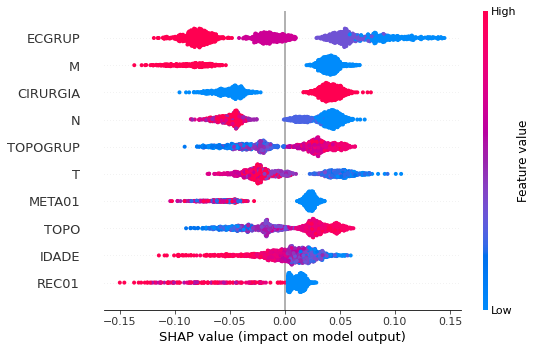

In [ ]:
plot_shap_values(rf_fora_08_11, X_testOS_08_11, feat_OS_08_11)

In [ ]:
# Other states - 2012 to 2015
rf_fora_12_15 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1.15, 1:1},
                                       criterion='entropy',
                                       max_depth=10)

rf_fora_12_15.fit(X_trainOS_12_15, y_trainOS_12_15)

RandomForestClassifier(class_weight={0: 1.15, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

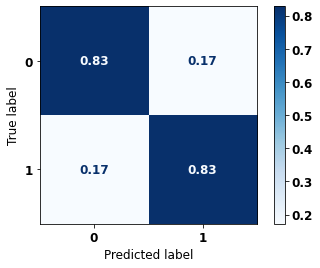

In [ ]:
display_confusion_matrix(rf_fora_12_15, X_testOS_12_15, y_testOS_12_15)

> The confusion matrix obtained for the Random Forest, with other states data from 2012 to 2015, also shows a good performance of the model, presenting 83% of accuracy.


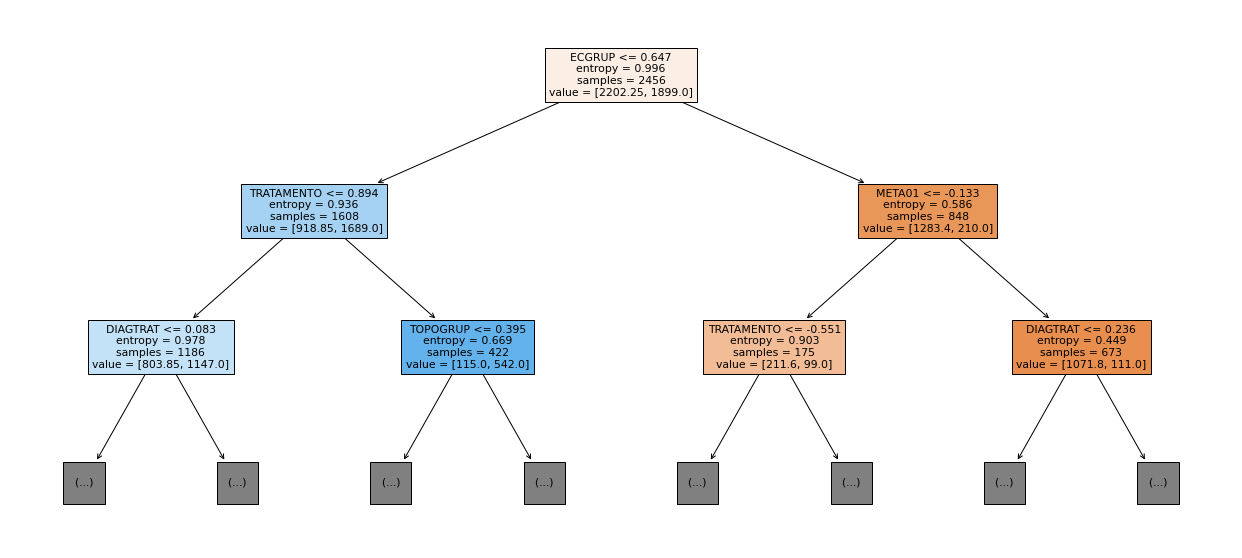

In [ ]:
show_tree(rf_fora_12_15, feat_OS_12_15, 2)

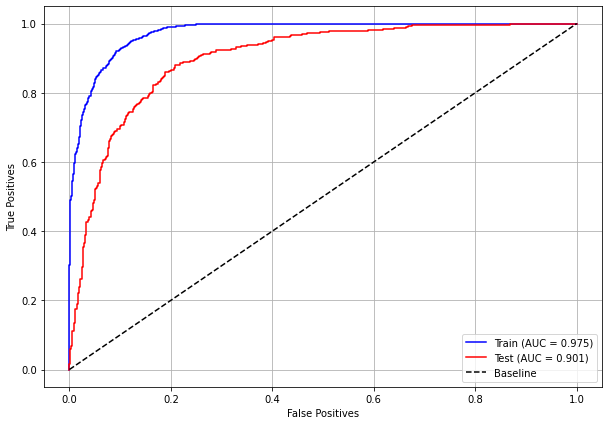

In [ ]:
plot_roc_curve(rf_fora_12_15, X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15)

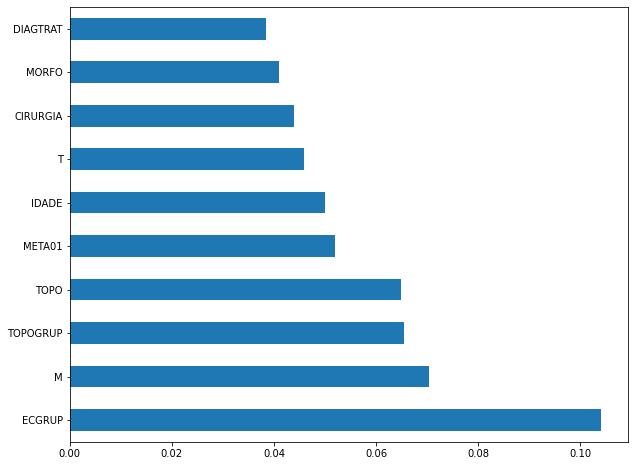

In [ ]:
plot_feat_importances(rf_fora_12_15, feat_OS_12_15)

> The four most important features in the model were `ECGRUP`, `M`, `TOPOGRUP` and `TOPO`.

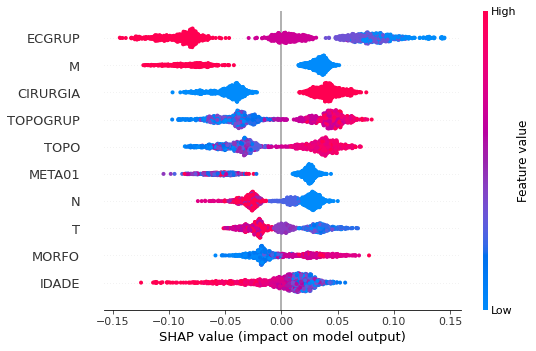

In [ ]:
plot_shap_values(rf_fora_12_15, X_testOS_12_15, feat_OS_12_15)

### **XGBoost**


The training of the XGBoost models follows the same pattern with `random_state`. The hyperparameter `scale_pos_weight` was also used in some trainings, in order to obtain a balanced main diagonal in the confusion matrix.

The hyperparameter `max_depth` was chosen as 10 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

**SP**

In [ ]:
# SP - 2000 to 2003
xgb_sp_00_03 = xgb.XGBClassifier(max_depth=10, 
                                 random_state=seed, 
                                 scale_pos_weight=1.05)

xgb_sp_00_03.fit(X_trainSP_00_03, y_trainSP_00_03)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=1.05)

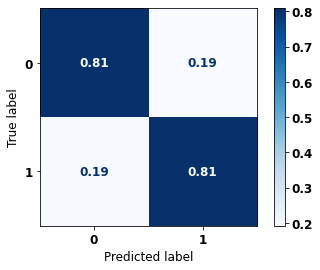

In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_00_03, y_testSP_00_03)

> The confusion matrix obtained for the XGBoost, with SP data from 2000 to 2003, shows a good performance of the model, here with 81% of accuracy.

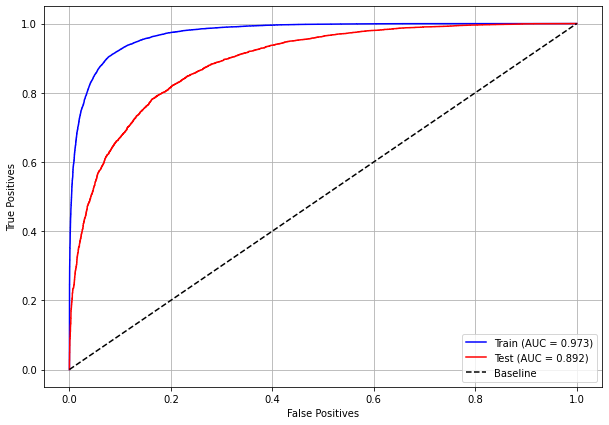

In [ ]:
plot_roc_curve(xgb_sp_00_03, X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03)

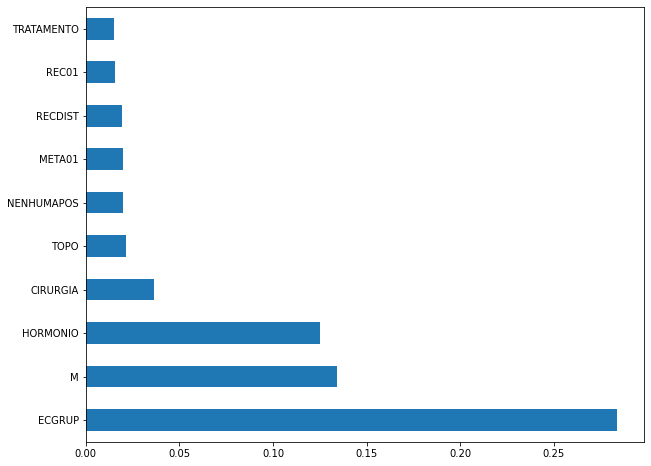

In [ ]:
plot_feat_importances(xgb_sp_00_03, feat_SP_00_03)

> Here we noticed that the most used feature was `ECGRUP`, with a lot advantage over the others. Following we have `M`, `HORMONIO` and `CIRURGIA`.

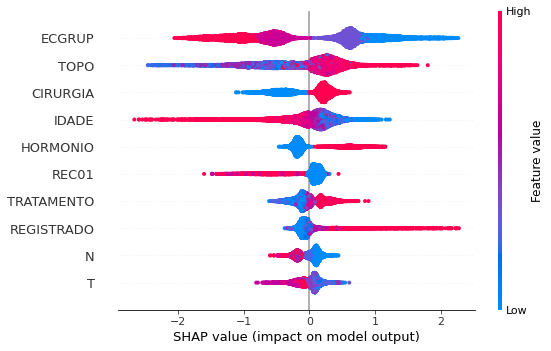

In [ ]:
plot_shap_values(xgb_sp_00_03, X_testSP_00_03, feat_SP_00_03)

In [ ]:
# SP - 2004 to 2007
xgb_sp_04_07 = xgb.XGBClassifier(max_depth=10, 
                                 random_state=seed, 
                                 scale_pos_weight=0.92)

xgb_sp_04_07.fit(X_trainSP_04_07, y_trainSP_04_07)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=0.92)

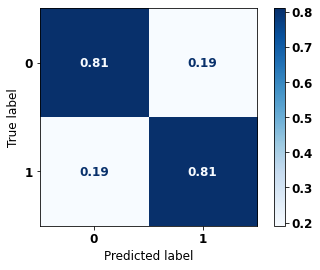

In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_04_07, y_testSP_04_07)

> The confusion matrix obtained for the XGBoost, with SP data from 2004 to 2007, shows a good performance of the model, with 81% of accuracy.


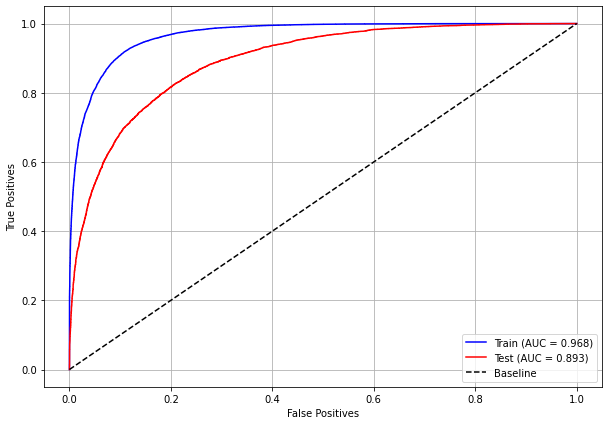

In [ ]:
plot_roc_curve(xgb_sp_04_07, X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07)

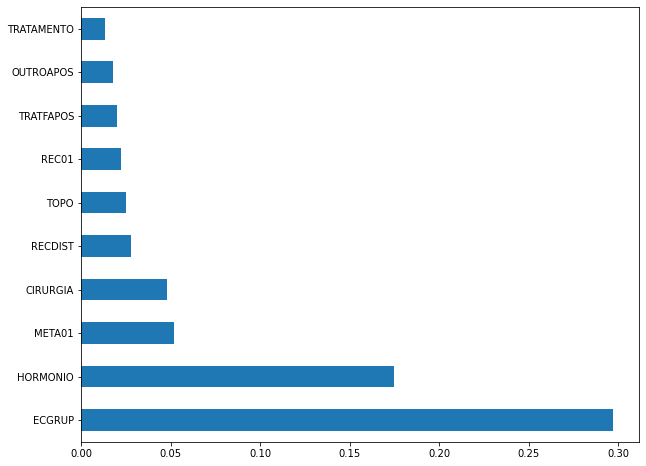

In [ ]:
plot_feat_importances(xgb_sp_04_07, feat_SP_04_07)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage over the others. Following we have `HORMONIO`, `META01` and `CIRURGIA`. 

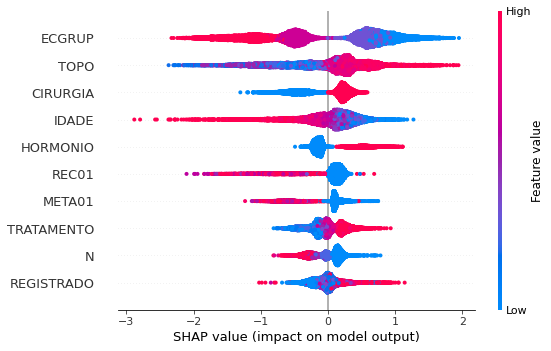

In [ ]:
plot_shap_values(xgb_sp_04_07, X_testSP_04_07, feat_SP_04_07)

In [ ]:
# SP - 2008 to 2011
xgb_sp_08_11 = xgb.XGBClassifier(max_depth=10, 
                                 scale_pos_weight=0.77,
                                 random_state=seed)

xgb_sp_08_11.fit(X_trainSP_08_11, y_trainSP_08_11)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=0.77)

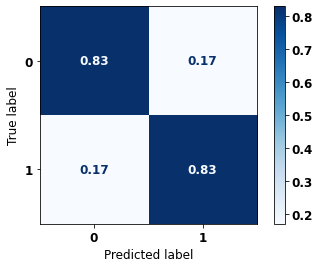

In [ ]:
display_confusion_matrix(xgb_sp_08_11, X_testSP_08_11, y_testSP_08_11)

> The confusion matrix obtained for the XGBoost, with SP data from 2008 to 2011, shows a good performance of the model, with 83% of accuracy.

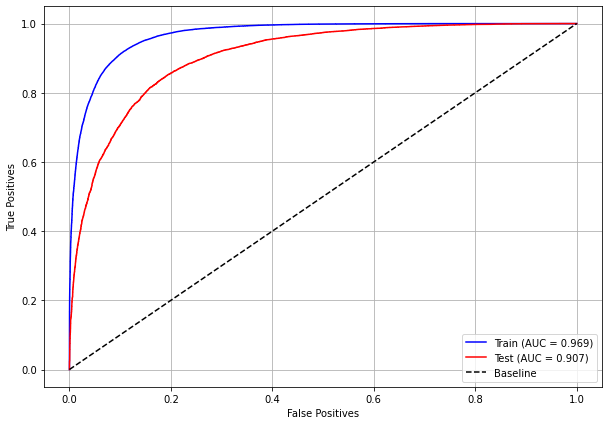

In [ ]:
plot_roc_curve(xgb_sp_08_11, X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11)

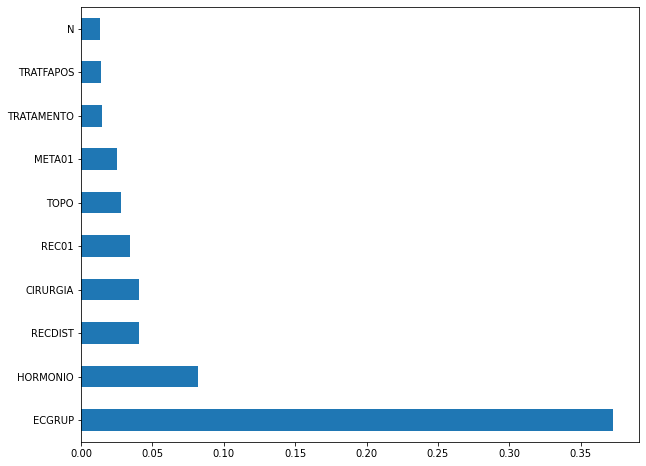

In [ ]:
plot_feat_importances(xgb_sp_08_11, feat_SP_08_11)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage over the others. Following we have `HORMONIO`, `RECDIST` and `CIRURGIA`. 

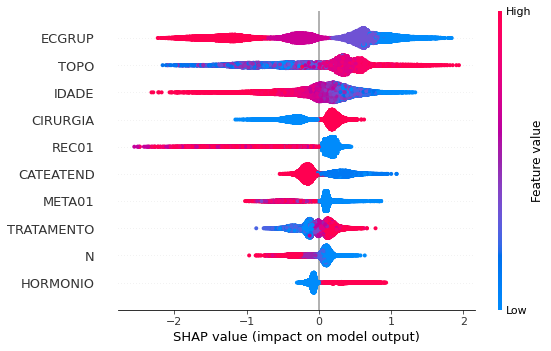

In [ ]:
plot_shap_values(xgb_sp_08_11, X_testSP_08_11, feat_SP_08_11)

In [ ]:
# SP - 2012 to 2015
xgb_sp_12_15 = xgb.XGBClassifier(max_depth=10, 
                                 random_state=seed,
                                 scale_pos_weight=1.25)

xgb_sp_12_15.fit(X_trainSP_12_15, y_trainSP_12_15)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=1.25)

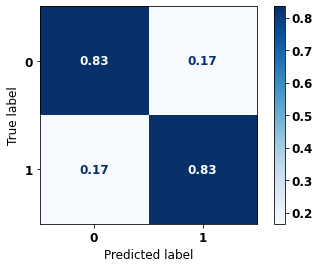

In [ ]:
display_confusion_matrix(xgb_sp_12_15, X_testSP_12_15, y_testSP_12_15)

> The confusion matrix obtained for the XGBoost, with SP data from 2012 to 2015, shows a good performance of the model, with 83% of accuracy.

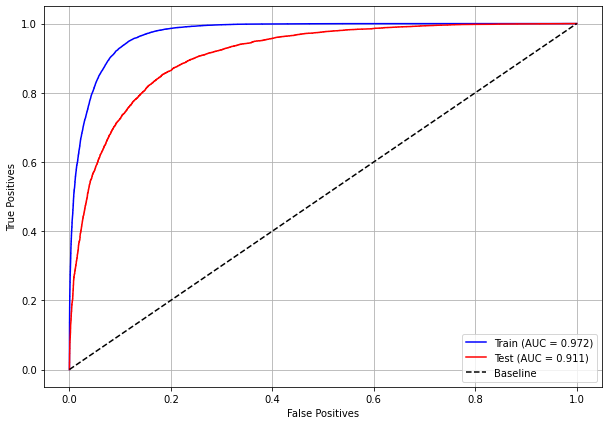

In [ ]:
plot_roc_curve(xgb_sp_12_15, X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15)

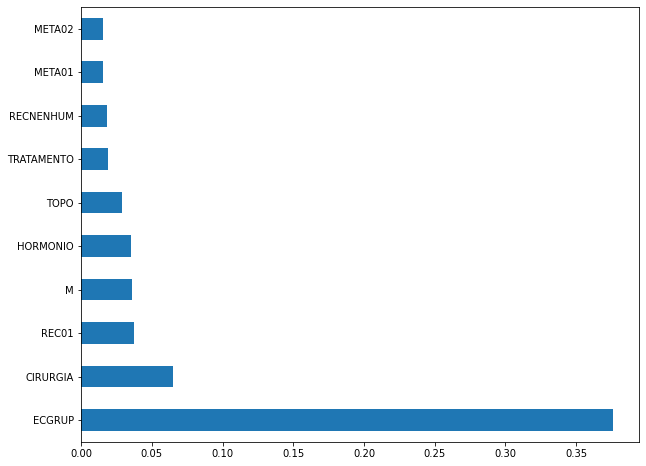

In [ ]:
plot_feat_importances(xgb_sp_12_15, feat_SP_12_15)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage. Following we have `CIRURGIA`, `REC01` and `M`. 

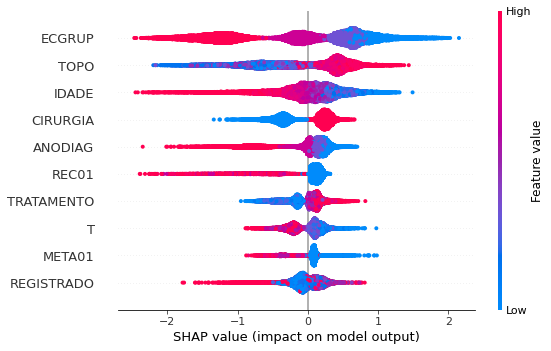

In [ ]:
plot_shap_values(xgb_sp_12_15, X_testSP_12_15, feat_SP_12_15)

**Other states**

In [ ]:
# Other states - 2000 to 2003
xgb_fora_00_03 = xgb.XGBClassifier(max_depth=10, 
                                   scale_pos_weight=0.67,
                                   random_state=seed)

xgb_fora_00_03.fit(X_trainOS_00_03, y_trainOS_00_03)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=0.67)

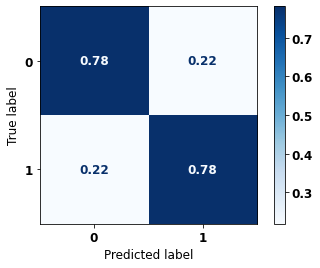

In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_00_03, y_testOS_00_03)

> The confusion matrix obtained for the XGBoost, with other states data from 2000 to 2003, also shows a good performance of the model, with 78% of accuracy.

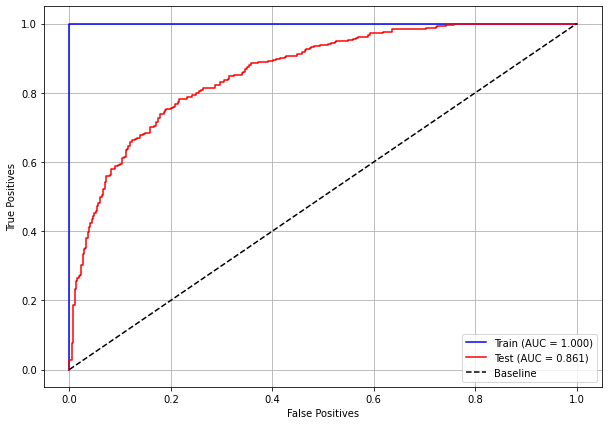

In [ ]:
plot_roc_curve(xgb_fora_00_03, X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03)

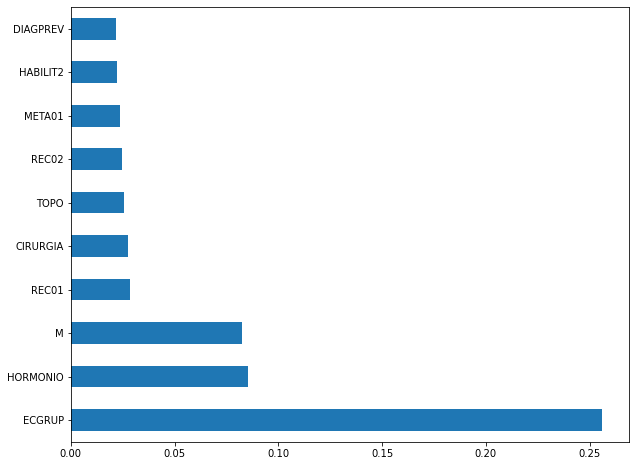

In [ ]:
plot_feat_importances(xgb_fora_00_03, feat_OS_00_03)

> Again we noticed that the most used feature was `ECGRUP`, with a good advantage. The following most important features were `HORMONIO`, `M` and `REC01`.

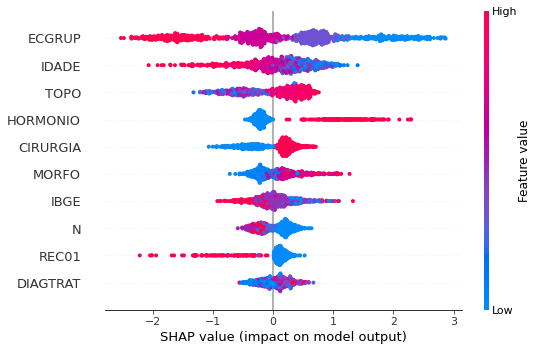

In [ ]:
plot_shap_values(xgb_fora_00_03, X_testOS_00_03, feat_OS_00_03)

In [ ]:
# Other states - 2004 to 2007
xgb_fora_04_07 = xgb.XGBClassifier(max_depth=10, 
                                   scale_pos_weight=0.8,
                                   random_state=seed)

xgb_fora_04_07.fit(X_trainOS_04_07, y_trainOS_04_07)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=0.8)

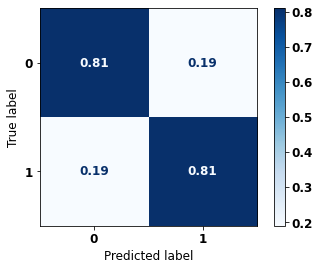

In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_04_07, y_testOS_04_07)

> The confusion matrix obtained for the XGBoost, with other states data from 2004 to 2007, also shows a good performance of the model with 81% of accuracy.

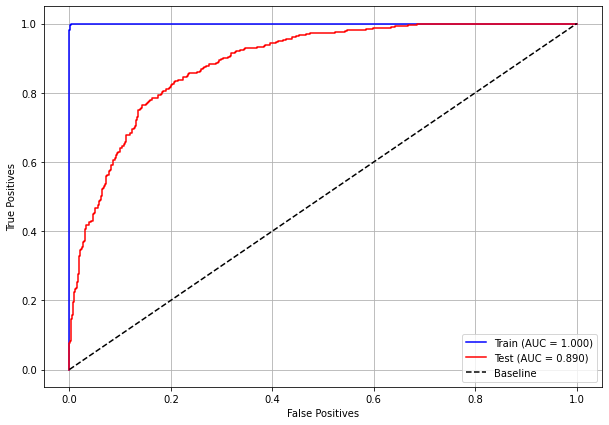

In [ ]:
plot_roc_curve(xgb_fora_04_07, X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07)

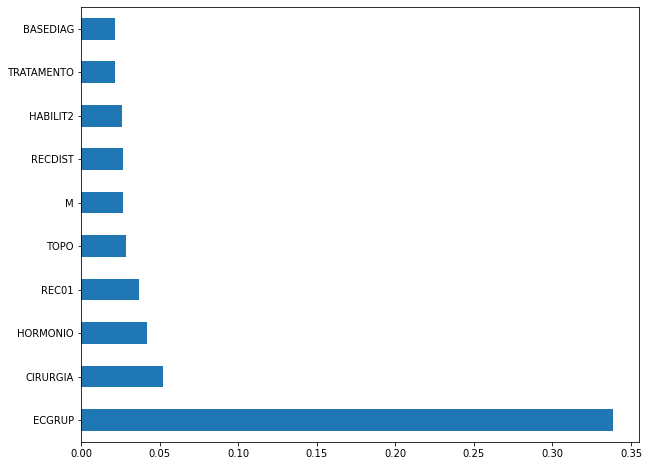

In [ ]:
plot_feat_importances(xgb_fora_04_07, feat_OS_04_07)

> Again we noticed that the most used feature was `ECGRUP`, with a good advantage. The following most important features were `CIRURGIA`, `HORMONIO` and `REC01`.

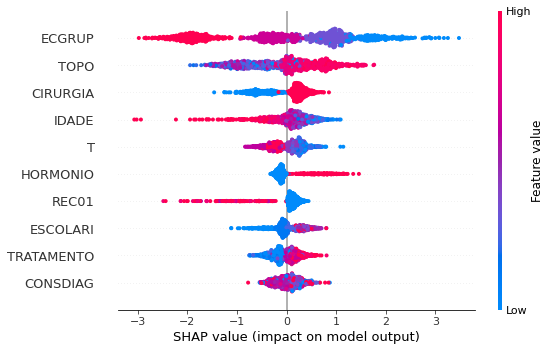

In [ ]:
plot_shap_values(xgb_fora_04_07, X_testOS_04_07, feat_OS_04_07)

In [ ]:
# Other states - 2008 to 2011
xgb_fora_08_11 = xgb.XGBClassifier(max_depth=10, 
                                   scale_pos_weight=0.65,
                                   random_state=seed)

xgb_fora_08_11.fit(X_trainOS_08_11, y_trainOS_08_11)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=0.65)

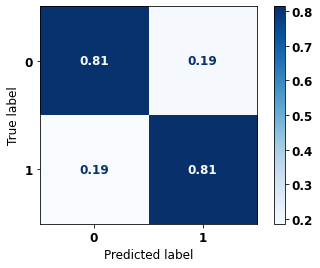

In [ ]:
display_confusion_matrix(xgb_fora_08_11, X_testOS_08_11, y_testOS_08_11)

> The confusion matrix obtained for the XGBoost, with other states data from 2008 to 2011, also shows a good performance of the model with 81% of accuracy.

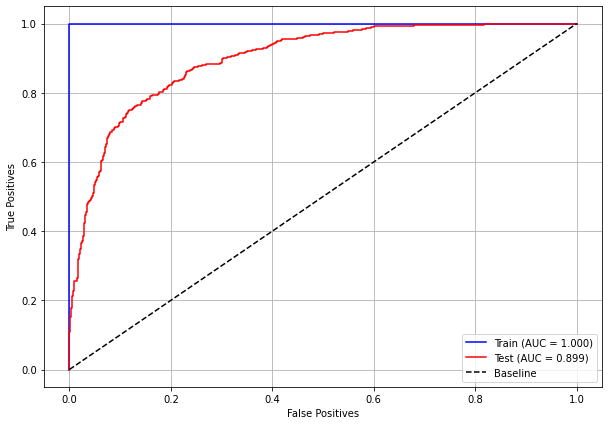

In [ ]:
plot_roc_curve(xgb_fora_08_11, X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11)

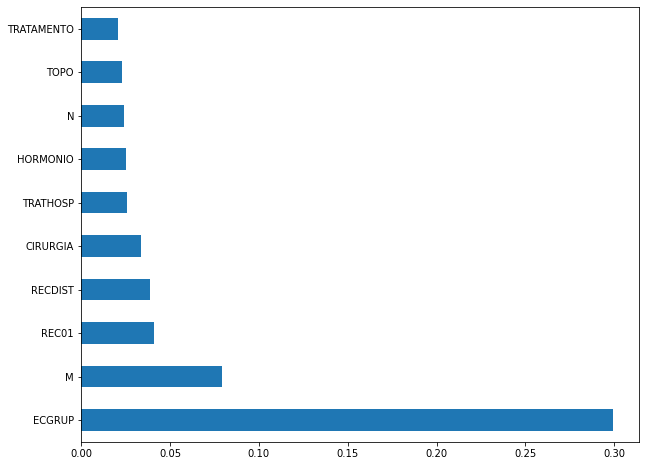

In [ ]:
plot_feat_importances(xgb_fora_08_11, feat_OS_08_11)

> Again we noticed that the most used feature was `ECGRUP`, but not with a lot of advantage. The following most important features were `M`, `REC01` and `RECDIST`.

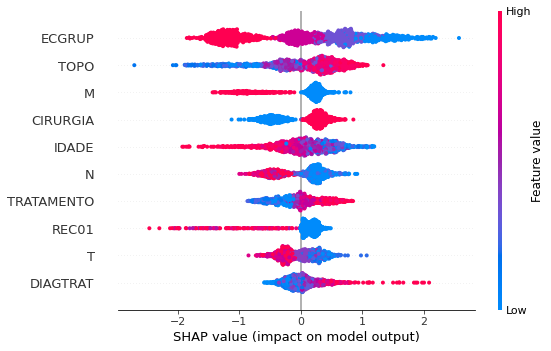

In [ ]:
plot_shap_values(xgb_fora_08_11, X_testOS_08_11, feat_OS_08_11)

In [ ]:
# Other states - 2012 to 2015
xgb_fora_12_15 = xgb.XGBClassifier(max_depth=10, 
                                   scale_pos_weight=1.05,
                                   random_state=seed)

xgb_fora_12_15.fit(X_trainOS_12_15, y_trainOS_12_15)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=1.05)

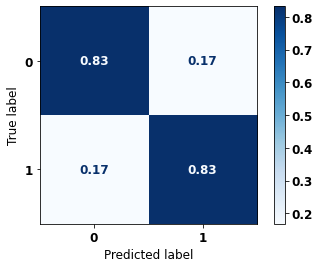

In [ ]:
display_confusion_matrix(xgb_fora_12_15, X_testOS_12_15, y_testOS_12_15)

> The confusion matrix obtained for the XGBoost, with other states data from 2012 to 2015, also shows a good performance of the model with 83% of accuracy.

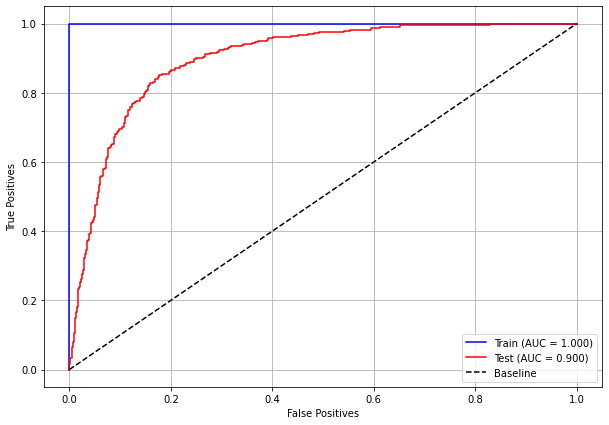

In [ ]:
plot_roc_curve(xgb_fora_12_15, X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15)

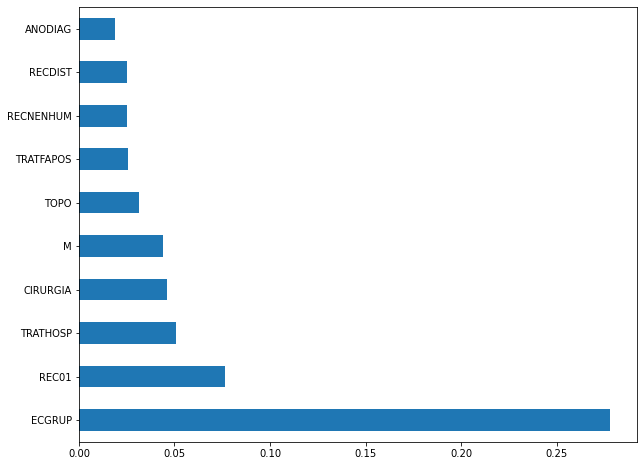

In [ ]:
plot_feat_importances(xgb_fora_12_15, feat_OS_12_15)

> The four most important features were `ECGRUP`, `REC01`, `TRATHOSP` and `CIRURGIA`.

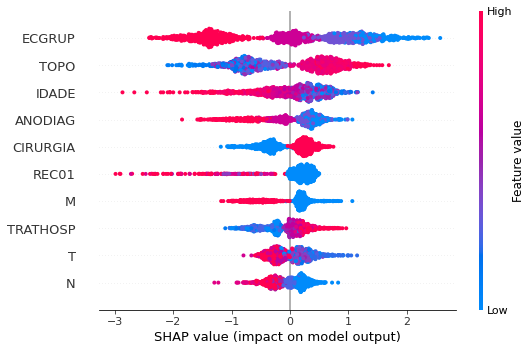

In [ ]:
plot_shap_values(xgb_fora_12_15, X_testOS_12_15, feat_OS_12_15)

## **Testing models with data from other years**

We will use test data from the following years in the trained models for each set of years grouped together.

### **Random Forest SP for years 2000 to 2003**

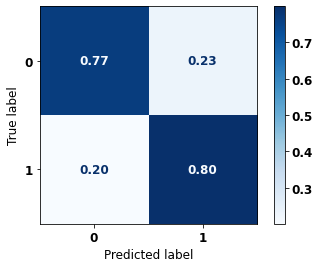

In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_04_07, y_testSP_04_07)

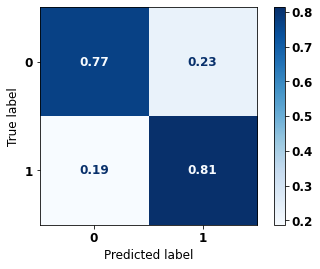

In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_08_11, y_testSP_08_11)

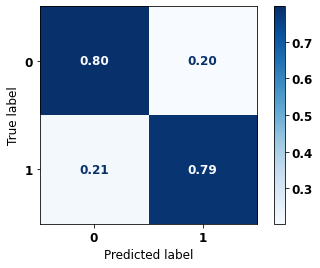

In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_12_15, y_testSP_12_15)

### **XGBoost SP for years 2000 to 2003**

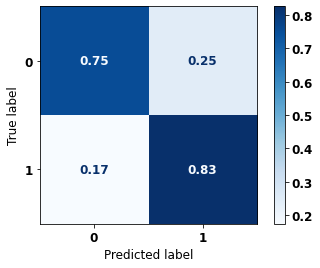

In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_04_07, y_testSP_04_07)

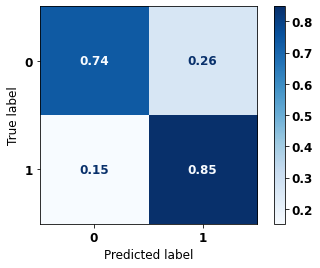

In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_08_11, y_testSP_08_11)

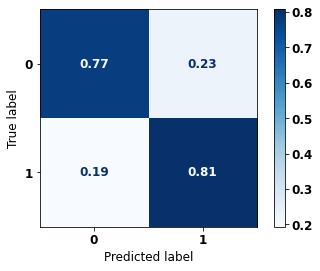

In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_12_15, y_testSP_12_15)

### **Random Forest SP for years 2004 to 2007**

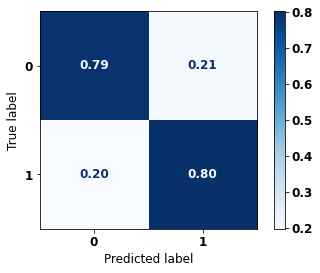

In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_08_11, y_testSP_08_11)

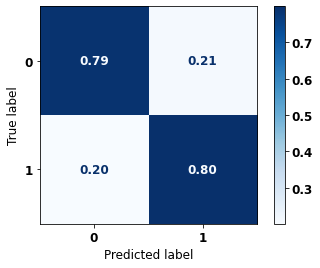

In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_12_15, y_testSP_12_15)

### **XGBoost SP for years 2004 to 2007**

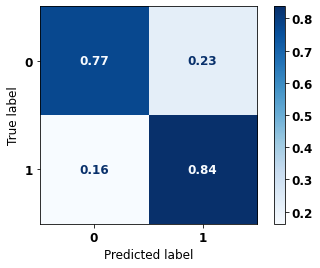

In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_08_11, y_testSP_08_11)

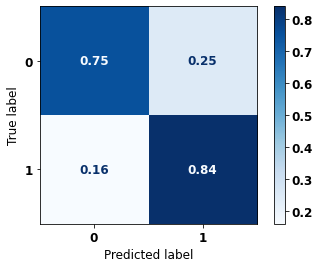

In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_12_15, y_testSP_12_15)

### **Random Forest SP for years 2008 to 2011**

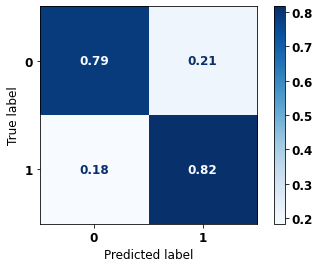

In [ ]:
display_confusion_matrix(rf_sp_08_11, X_testSP_12_15, y_testSP_12_15)

### **XGBoost SP for years 2008 to 2011**

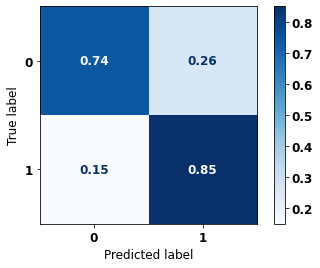

In [ ]:
display_confusion_matrix(xgb_sp_08_11, X_testSP_12_15, y_testSP_12_15)

### **Random Forest Other states for years 2000 to 2003**

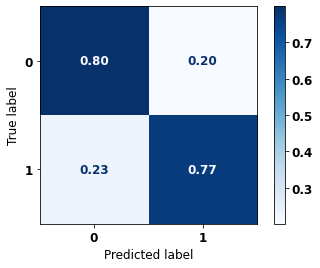

In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_04_07, y_testOS_04_07)

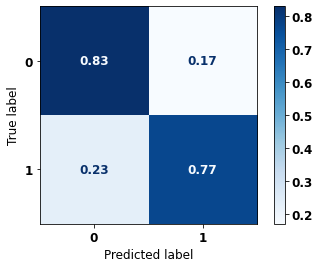

In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_08_11, y_testOS_08_11)

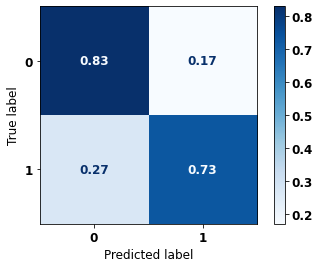

In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_12_15, y_testOS_12_15)

### **XGBoost Other states for years 2000 to 2003**

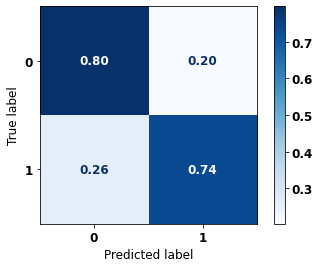

In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_04_07, y_testOS_04_07)

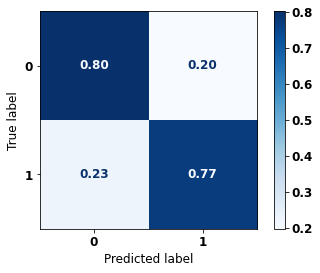

In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_08_11, y_testOS_08_11)

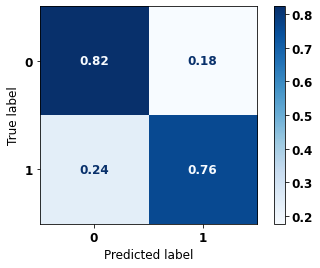

In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_12_15, y_testOS_12_15)

### **Random Forest Other states for years 2004 to 2007**

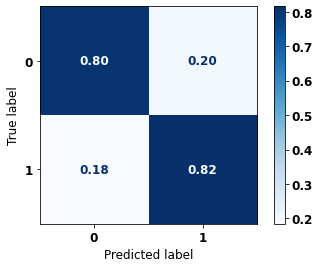

In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_08_11, y_testOS_08_11)

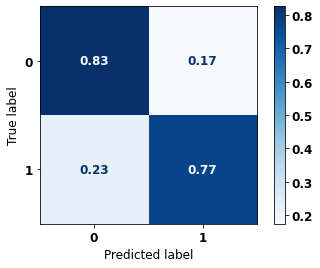

In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_12_15, y_testOS_12_15)

### **XGBoost Other states for years 2004 to 2007**

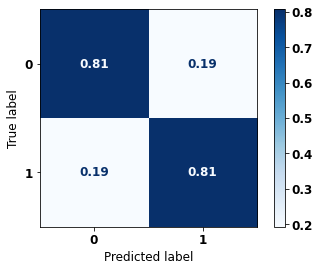

In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_08_11, y_testOS_08_11)

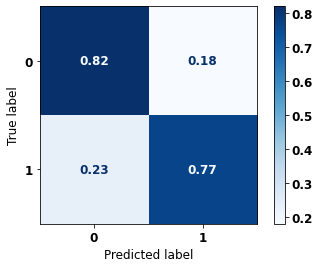

In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_12_15, y_testOS_12_15)

### **Random Forest Other states for years 2008 to 2011**

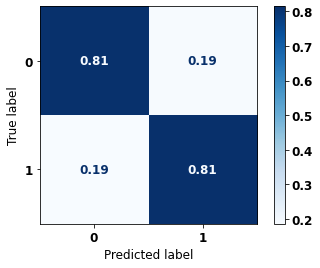

In [ ]:
display_confusion_matrix(rf_fora_08_11, X_testOS_12_15, y_testOS_12_15)

### **XGBoost Other states for years 2008 to 2011**

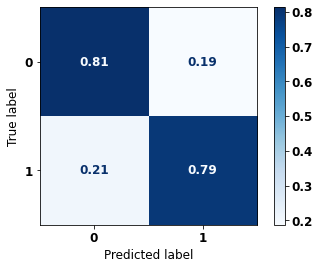

In [ ]:
display_confusion_matrix(xgb_fora_08_11, X_testOS_12_15, y_testOS_12_15)

# **Fifth approach**

Approach with grouped years and without the columns `EC` and `HORMONIO`.

## **Preprocessing**

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation. We will use the years grouped too, resulting in 5 datasets for SP and more 5 for other states.

First, it is necessary to define the columns that will be used as features and the label. We will not use some columns of the datasets: `UFRESID`, because we already have the division between SP and other states in the two datasets. 

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`, as well as the column `ECGRUP` and not the column `EC`. Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'FAIXAETAR', 'ULTICONS', 'ULTIDIAG', 'ULTITRAT', 
             'obito_geral', 'obito_cancer', 'vivo_ano1', 'vivo_ano3',
             'ULTINFO', 'EC', 'HORMONIO']

# 'RECNENHUM', 'RECLOCAL', 'RECREGIO', 'REC01', 'REC02', 'REC03', 'RECDIST'

lb = 'vivo_ano5'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

The process will be done 5 times for SP and other states, using the datasets with grouped years.

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

### **SP**

In [ ]:
X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03, feat_SP_00_03 = preprocessing(df_SP_ano5, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2000, 
                                                                                                last_year=2003, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (44789, 64), X_test = (14930, 64)
y_train = (44789,), y_test = (14930,)


In [ ]:
X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07, feat_SP_04_07 = preprocessing(df_SP_ano5, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2004, 
                                                                                                last_year=2007,
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')                                                            

X_train = (55804, 64), X_test = (18602, 64)
y_train = (55804,), y_test = (18602,)


In [ ]:
X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11, feat_SP_08_11 = preprocessing(df_SP_ano5, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2008, 
                                                                                                last_year=2011, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (73620, 64), X_test = (24541, 64)
y_train = (73620,), y_test = (24541,)


In [ ]:
X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15, feat_SP_12_15 = preprocessing(df_SP_ano5, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2012, 
                                                                                                last_year=2015, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (65896, 64), X_test = (21966, 64)
y_train = (65896,), y_test = (21966,)


### **Other states**

In [ ]:
X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03, feat_OS_00_03 = preprocessing(df_fora_ano5, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2000, 
                                                                                                last_year=2003, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (2588, 64), X_test = (863, 64)
y_train = (2588,), y_test = (863,)


In [ ]:
X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07, feat_OS_04_07 = preprocessing(df_fora_ano5, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2004, 
                                                                                                last_year=2007, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (3396, 64), X_test = (1133, 64)
y_train = (3396,), y_test = (1133,)


In [ ]:
X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11, feat_OS_08_11 = preprocessing(df_fora_ano5, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2008, 
                                                                                                last_year=2011, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (3926, 64), X_test = (1309, 64)
y_train = (3926,), y_test = (1309,)


In [ ]:
X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15, feat_OS_12_15 = preprocessing(df_fora_ano5, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2012, 
                                                                                                last_year=2015, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (3814, 64), X_test = (1272, 64)
y_train = (3814,), y_test = (1272,)


## **Training and evaluation of the models**

After dividing the data into training and testing, using the encoder and normalizing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model is the Random Forest, the `random_state` will be used as a parameter, to obtain the same training values of the model every time it is runned.

The hyperparameter `class_weight` was used because the models have difficulty to learn the class with fewer examples.

**SP**

In [ ]:
# SP - 2000 to 2003
rf_sp_00_03 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1.03, 1:1},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_00_03.fit(X_trainSP_00_03, y_trainSP_00_03)

RandomForestClassifier(class_weight={0: 1.03, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

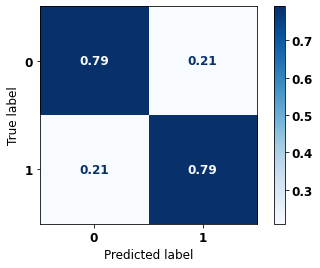

In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_00_03, y_testSP_00_03)

> The confusion matrix obtained for the Random Forest, with SP data from 2000 to 2003, shows a good performance of the model, with 79% of accuracy.


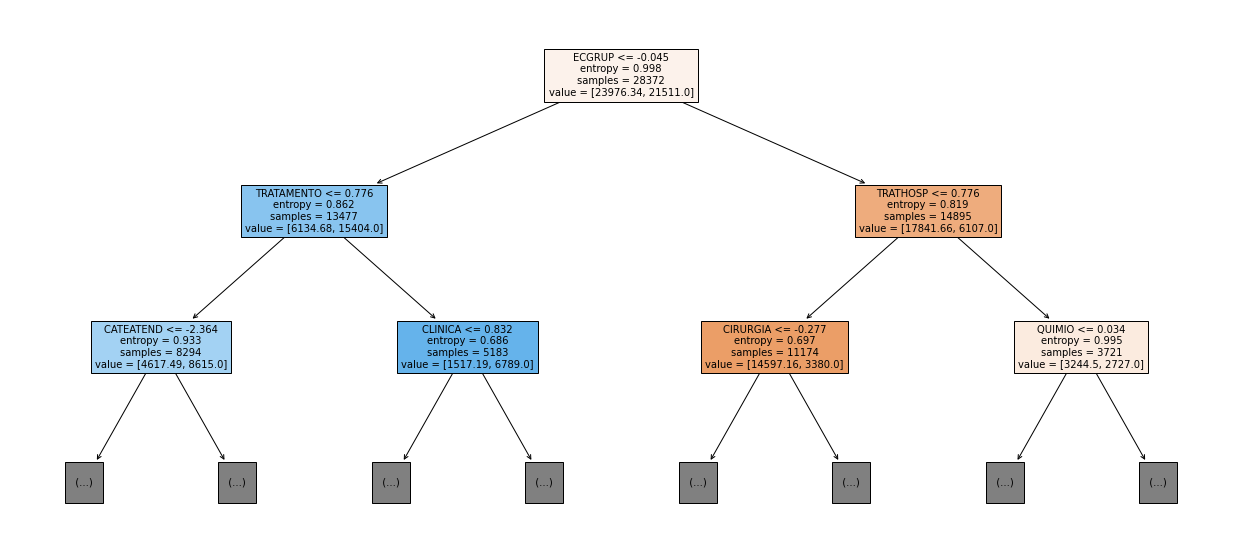

In [ ]:
show_tree(rf_sp_00_03, feat_SP_00_03, 2)

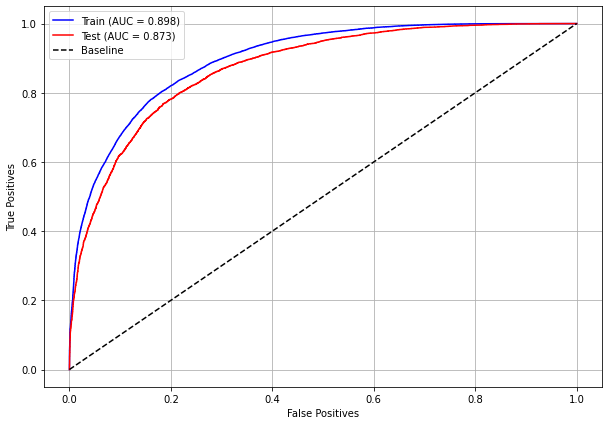

In [ ]:
plot_roc_curve(rf_sp_00_03, X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03)

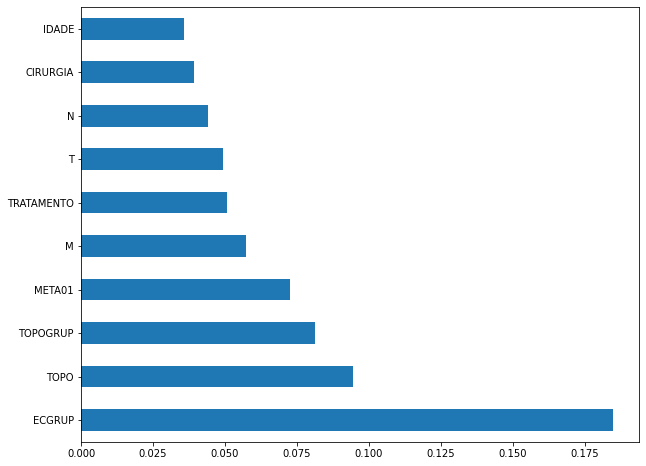

In [ ]:
plot_feat_importances(rf_sp_00_03, feat_SP_00_03)

> The four most important features in the model were `ECGRUP`, `TOPO`, `TOPOGRUP`, and `META01`. 

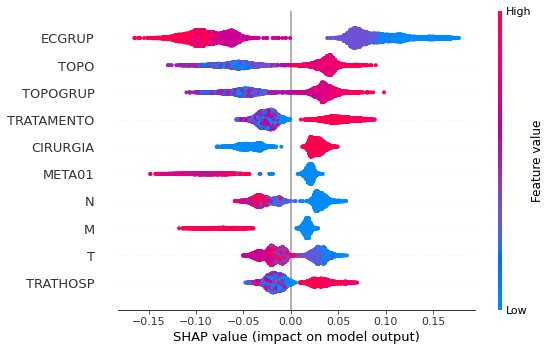

In [ ]:
plot_shap_values(rf_sp_00_03, X_testSP_00_03, feat_SP_00_03)

In [ ]:
# SP - 2004 to 2007
rf_sp_04_07 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1.2, 1:1},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_04_07.fit(X_trainSP_04_07, y_trainSP_04_07)

RandomForestClassifier(class_weight={0: 1.2, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

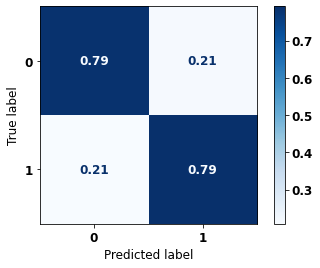

In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_04_07, y_testSP_04_07)

> The confusion matrix obtained for the Random Forest, with SP data from 2004 to 2007, shows a good performance of the model, with 79% of accuracy.

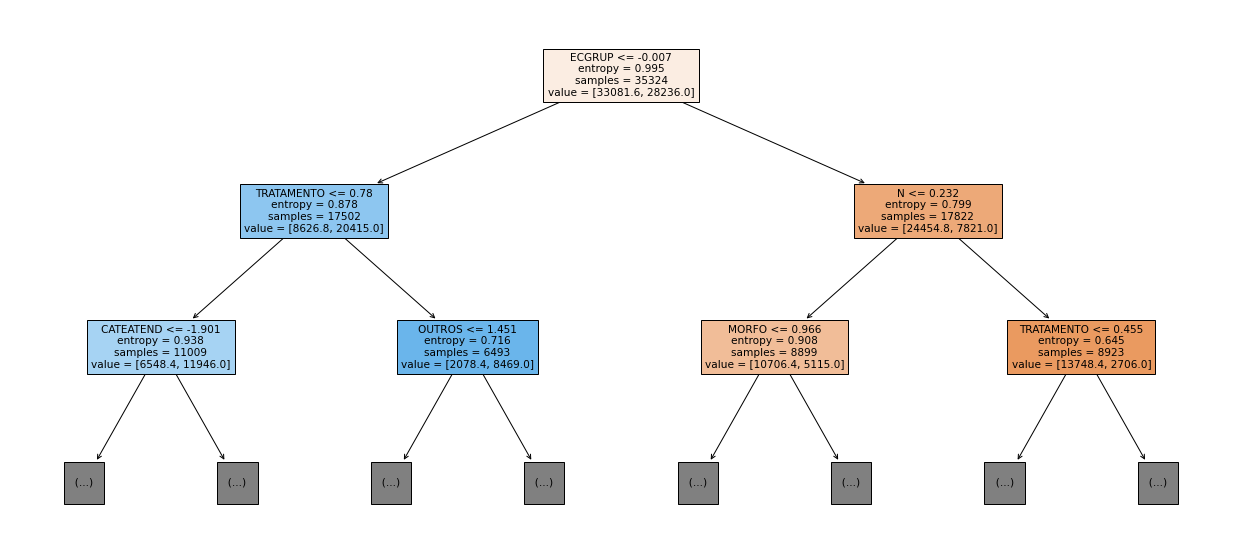

In [ ]:
show_tree(rf_sp_04_07, feat_SP_04_07, 2)

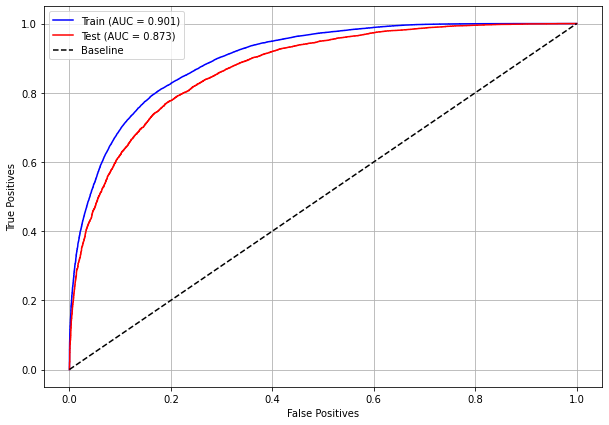

In [ ]:
plot_roc_curve(rf_sp_04_07, X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07)

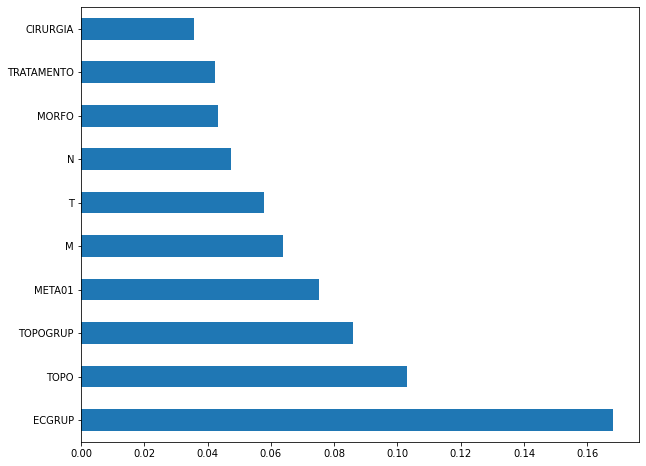

In [ ]:
plot_feat_importances(rf_sp_04_07, feat_SP_04_07)

> The four most important features in the model were `ECGRUP`, `TOPO`, `TOPOGRUP` and `META01`.

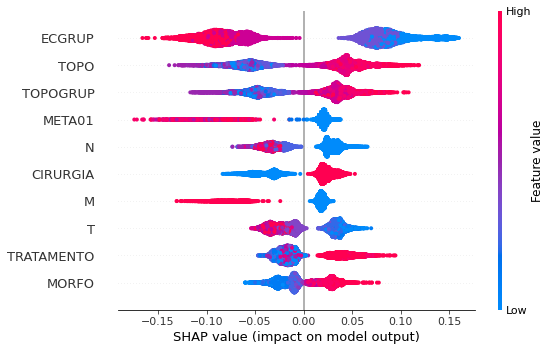

In [ ]:
plot_shap_values(rf_sp_04_07, X_testSP_04_07, feat_SP_04_07)

In [ ]:
# SP - 2008 to 2011
rf_sp_08_11 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1.3, 1:1},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_08_11.fit(X_trainSP_08_11, y_trainSP_08_11)

RandomForestClassifier(class_weight={0: 1.3, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

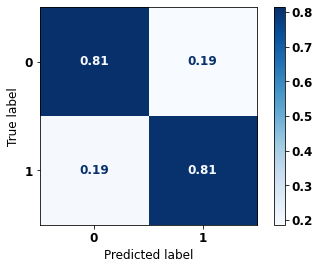

In [ ]:
display_confusion_matrix(rf_sp_08_11, X_testSP_08_11, y_testSP_08_11)

> The confusion matrix obtained for the Random Forest, with SP data from 2008 to 2011, shows a good performance of the model, with 81% of accuracy.

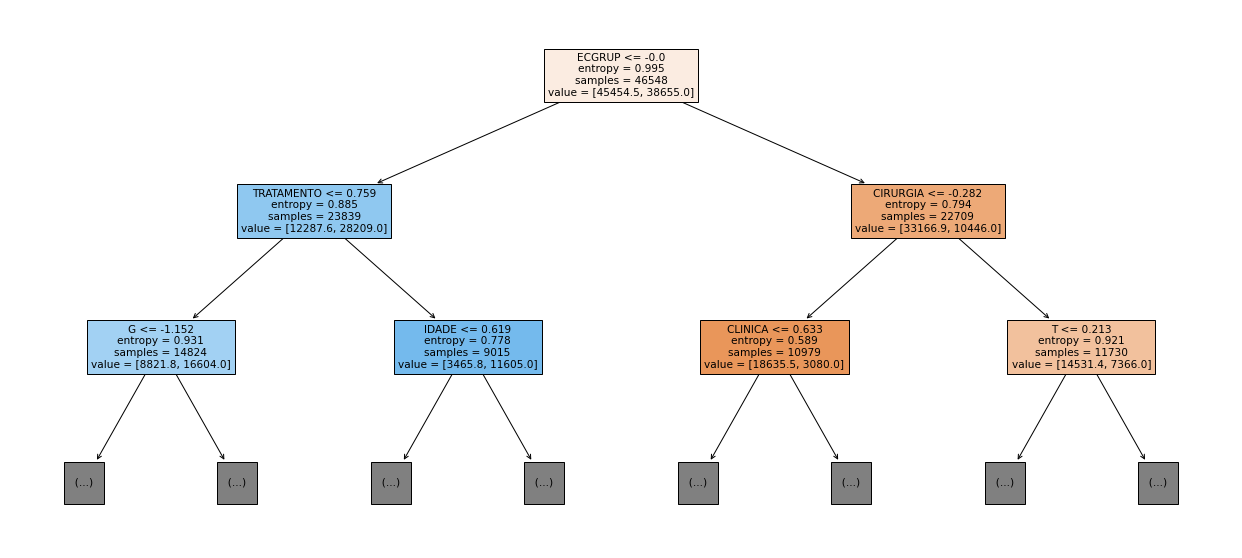

In [ ]:
show_tree(rf_sp_08_11, feat_SP_08_11, 2)

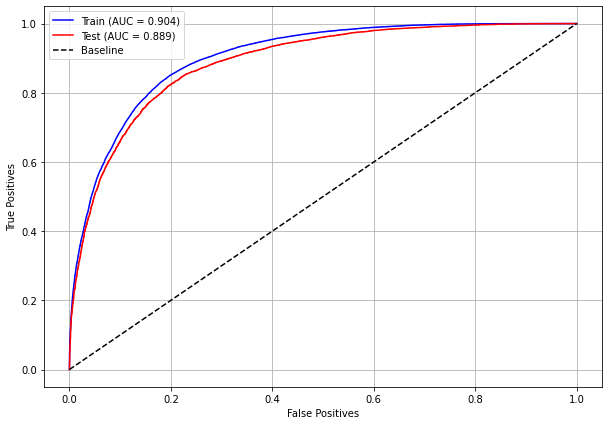

In [ ]:
plot_roc_curve(rf_sp_08_11, X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11)

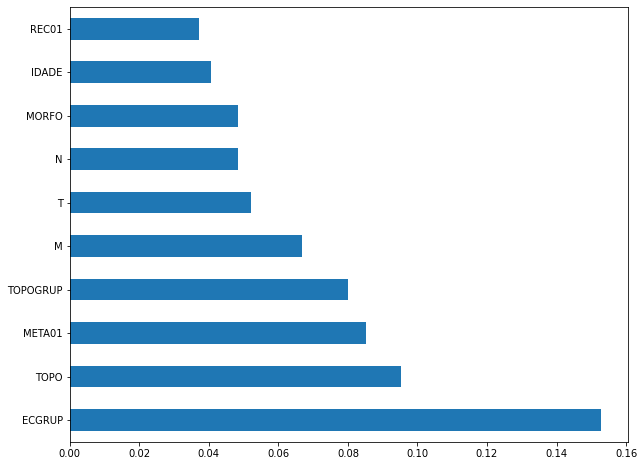

In [ ]:
plot_feat_importances(rf_sp_08_11, feat_SP_08_11)

> The four most important features in the model were `ECGRUP`, `TOPO`, `META01` and `TOPOGRUP`.

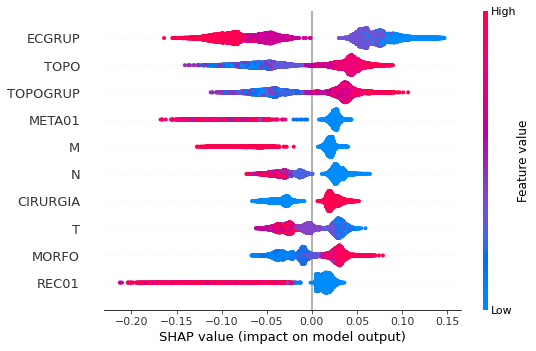

In [ ]:
plot_shap_values(rf_sp_08_11, X_testSP_08_11, feat_SP_08_11)

In [ ]:
# SP - 2012 to 2015
rf_sp_12_15 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:1.17},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_12_15.fit(X_trainSP_12_15, y_trainSP_12_15)

RandomForestClassifier(class_weight={0: 1, 1: 1.17}, criterion='entropy',
                       max_depth=10, random_state=10)

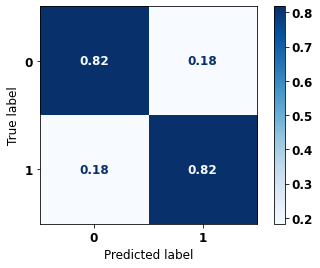

In [ ]:
display_confusion_matrix(rf_sp_12_15, X_testSP_12_15, y_testSP_12_15)

> The confusion matrix obtained for the Random Forest, with SP data from 2012 to 2015, shows a good performance of the model with 82% of accuracy.

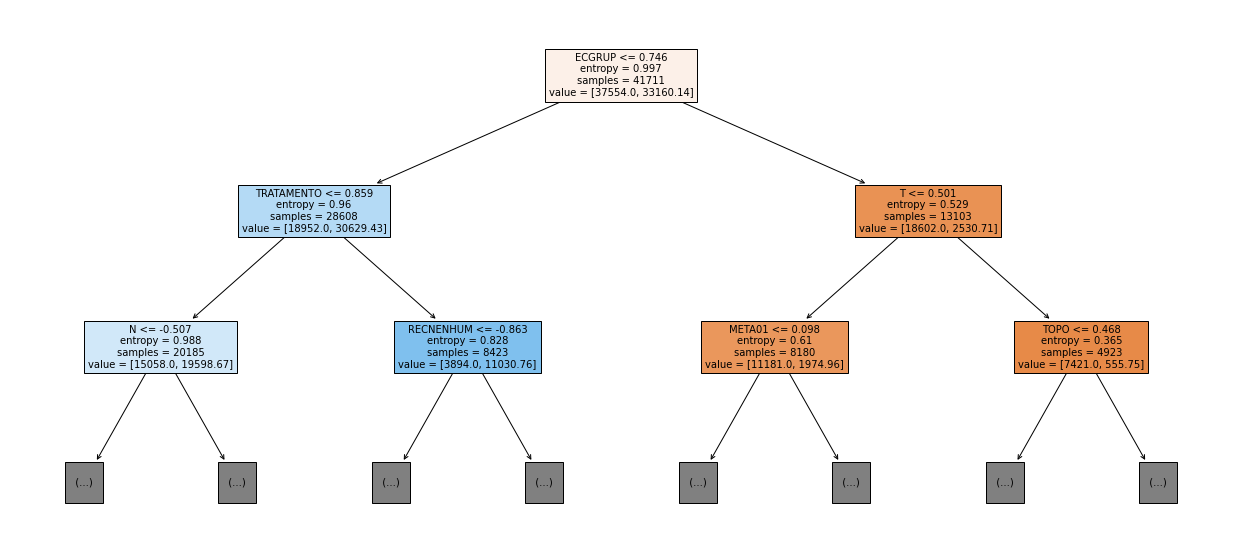

In [ ]:
show_tree(rf_sp_12_15, feat_SP_12_15, 2)

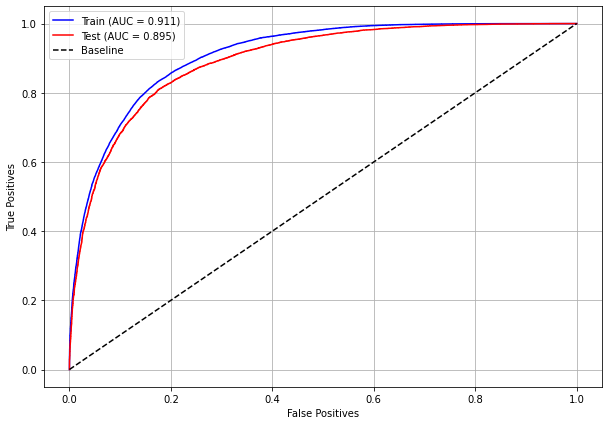

In [ ]:
plot_roc_curve(rf_sp_12_15, X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15)

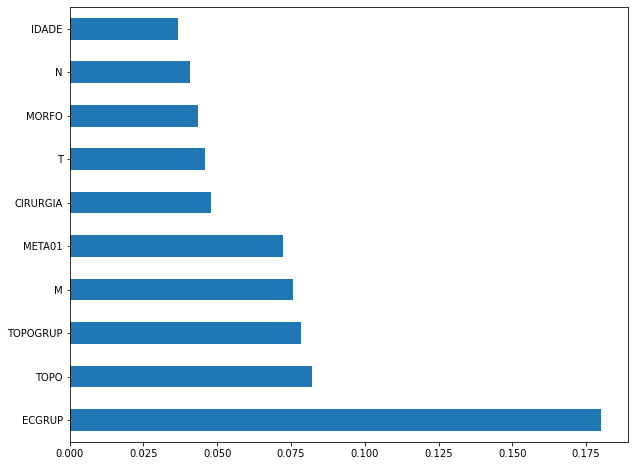

In [ ]:
plot_feat_importances(rf_sp_12_15, feat_SP_12_15)

> The four most important features in the model were `ECGRUP`, `TOPO`, `TOPOGRUP` and `M`.

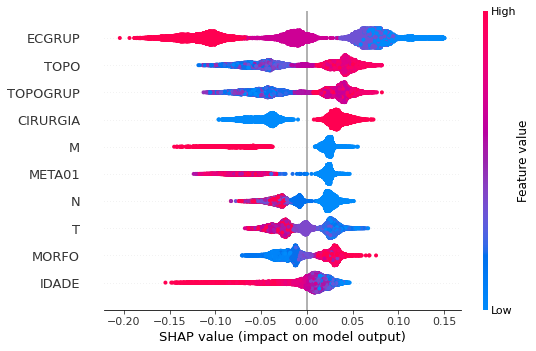

In [ ]:
plot_shap_values(rf_sp_12_15, X_testSP_12_15, feat_SP_12_15)

**Other states**

In [ ]:
# Other states - 2000 to 2003
rf_fora_00_03 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1.53, 1:1},
                                       criterion='entropy',
                                       max_depth=10)

rf_fora_00_03.fit(X_trainOS_00_03, y_trainOS_00_03)

RandomForestClassifier(class_weight={0: 1.53, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

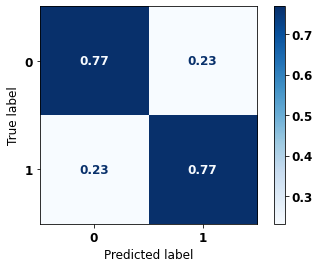

In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_00_03, y_testOS_00_03)

> The confusion matrix obtained for the Random Forest, with other states data from 2000 to 2003, also shows a good performance of the model, and we have a balanced main diagonal with 77% of accuracy.

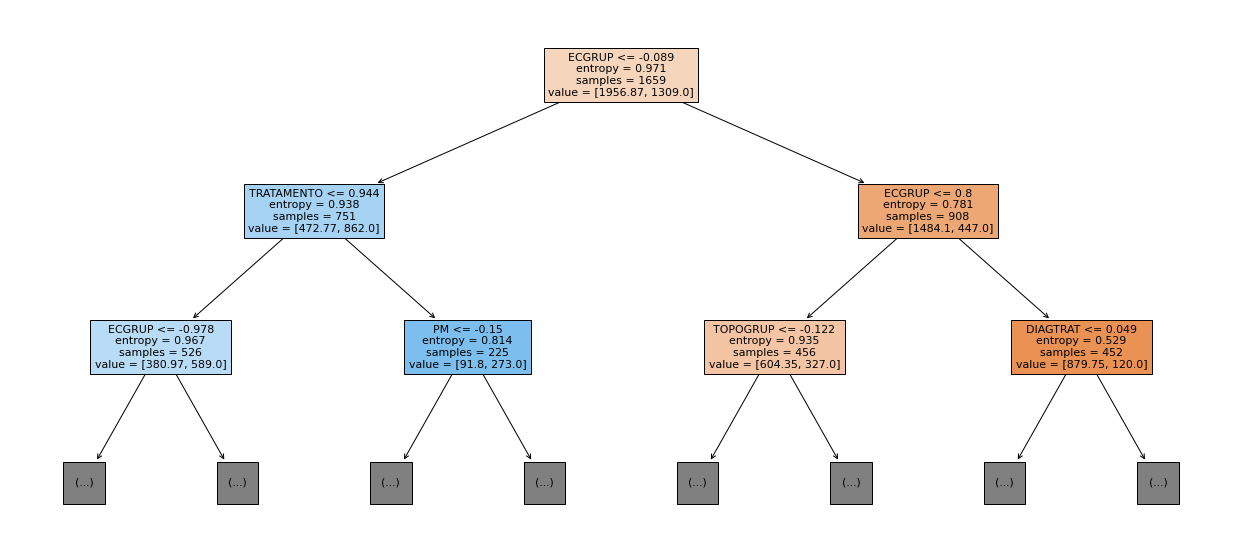

In [ ]:
show_tree(rf_fora_00_03, feat_OS_00_03, 2)

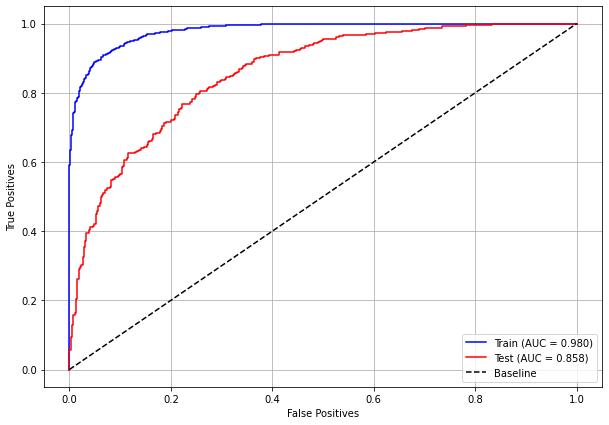

In [ ]:
plot_roc_curve(rf_fora_00_03, X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03)

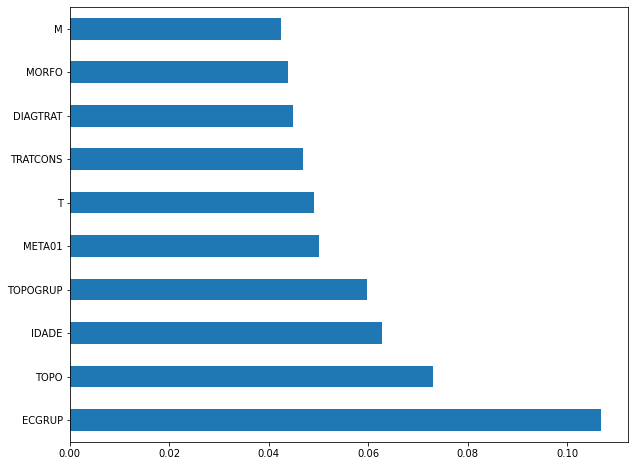

In [ ]:
plot_feat_importances(rf_fora_00_03, feat_OS_00_03)

> The four most important features in the model were `ECGRUP`, `TOPO`, `IDADE` and `TOPOGRUP`.

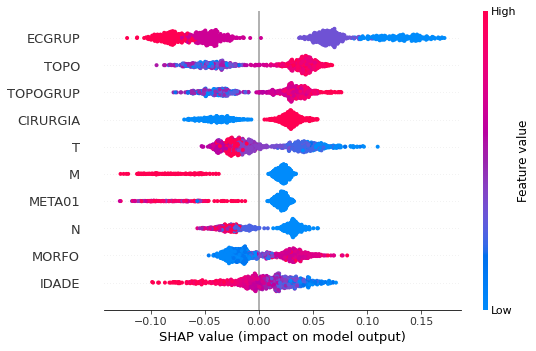

In [ ]:
plot_shap_values(rf_fora_00_03, X_testOS_00_03, feat_OS_00_03)

In [ ]:
# Other states - 2004 to 2007
rf_fora_04_07 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1.5, 1:1},
                                       criterion='entropy',
                                       max_depth=10)

rf_fora_04_07.fit(X_trainOS_04_07, y_trainOS_04_07)

RandomForestClassifier(class_weight={0: 1.5, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

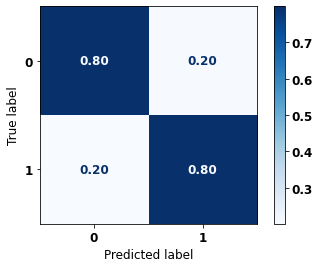

In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_04_07, y_testOS_04_07)

> The confusion matrix obtained for the Random Forest, with other states data from 2004 to 2007, also shows a good performance of the model, with 80% of accuracy.


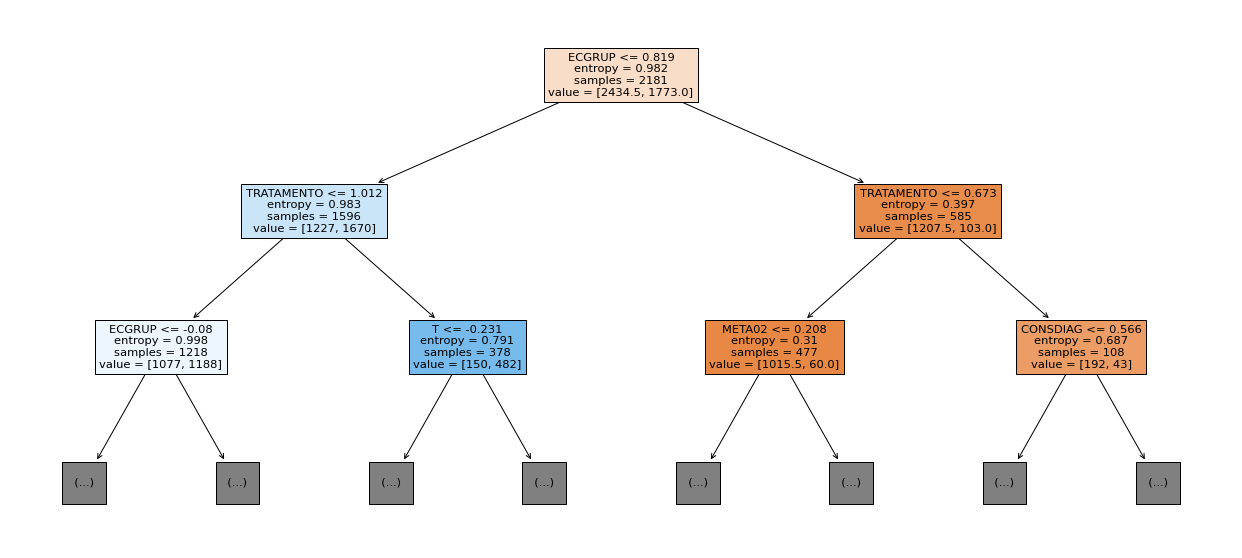

In [ ]:
show_tree(rf_fora_04_07, feat_OS_04_07, 2)

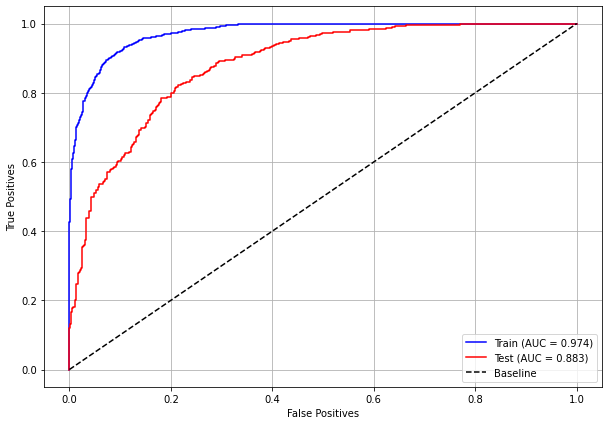

In [ ]:
plot_roc_curve(rf_fora_04_07, X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07)

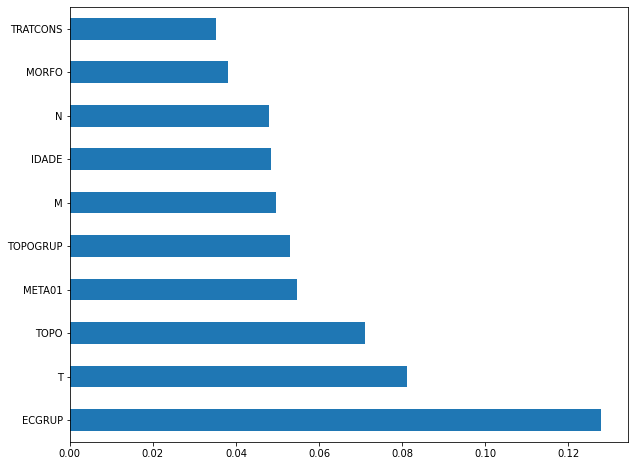

In [ ]:
plot_feat_importances(rf_fora_04_07, feat_OS_04_07)

> The four most important features in the model were `ECGRUP`, `T`, `TOPO` and `META01`.

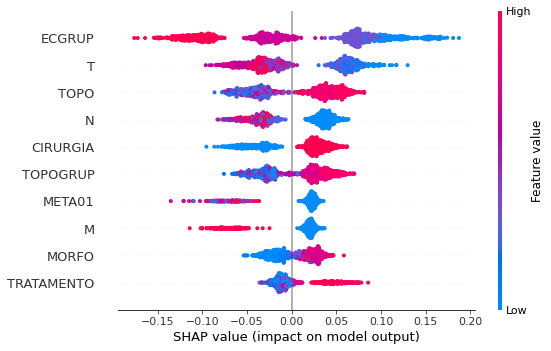

In [ ]:
plot_shap_values(rf_fora_04_07, X_testOS_04_07, feat_OS_04_07)

In [ ]:
# Other states - 2008 to 2011
rf_fora_08_11 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1.6, 1:1},
                                       criterion='entropy',
                                       max_depth=10)

rf_fora_08_11.fit(X_trainOS_08_11, y_trainOS_08_11)

RandomForestClassifier(class_weight={0: 1.6, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

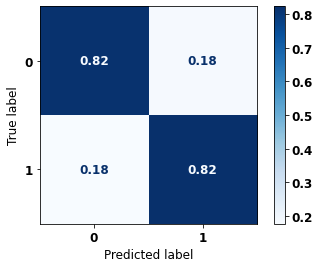

In [ ]:
display_confusion_matrix(rf_fora_08_11, X_testOS_08_11, y_testOS_08_11)

> The confusion matrix obtained for the Random Forest, with other states data from 2008 to 2011, also shows a good performance of the model, presenting 82% of accuracy.


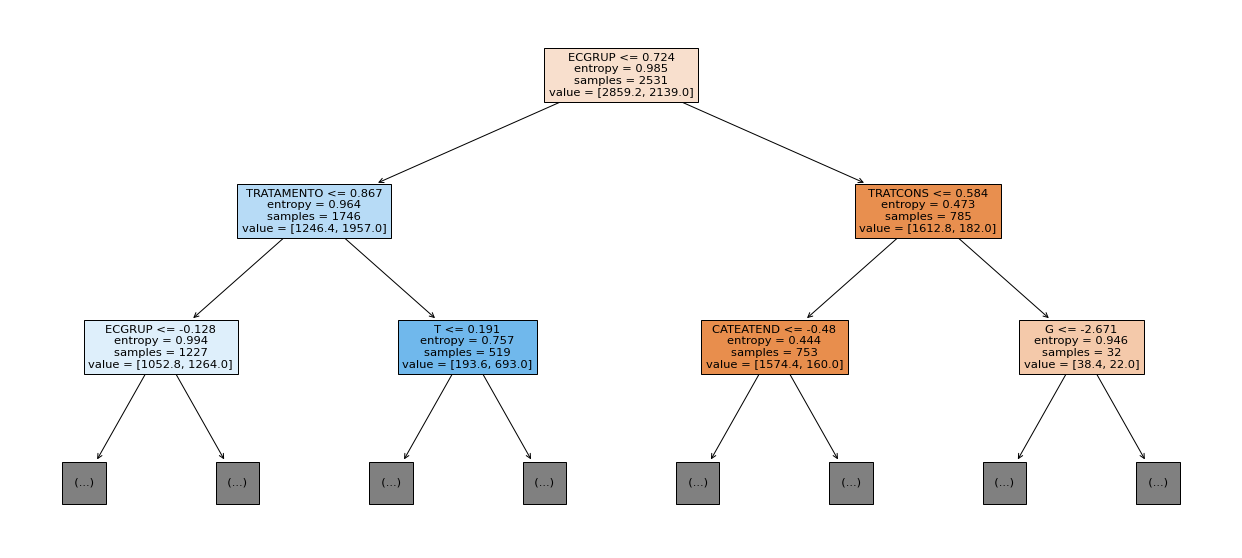

In [ ]:
show_tree(rf_fora_08_11, feat_OS_08_11, 2)

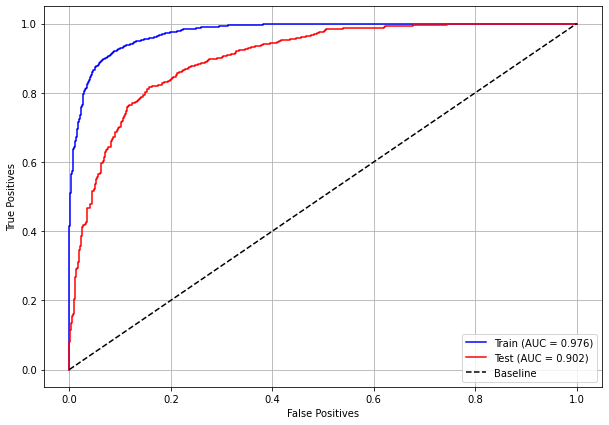

In [ ]:
plot_roc_curve(rf_fora_08_11, X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11)

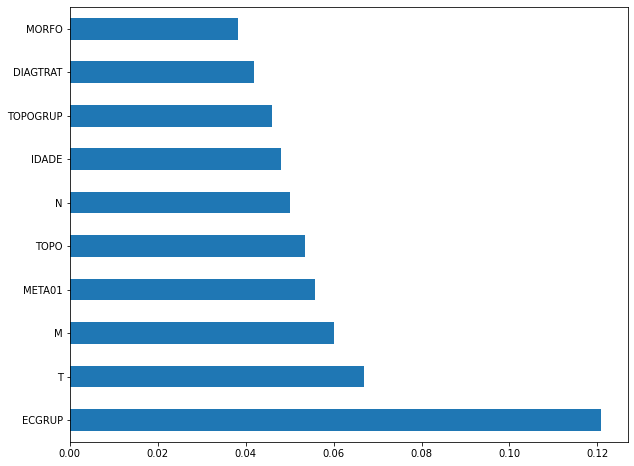

In [ ]:
plot_feat_importances(rf_fora_08_11, feat_OS_08_11)

> The four most important features in the model were `ECGRUP`, `T`, `M` and `META01`.

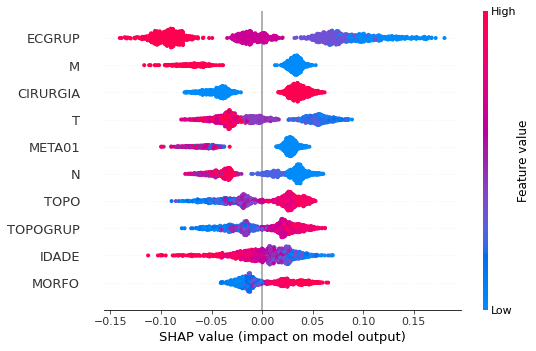

In [ ]:
plot_shap_values(rf_fora_08_11, X_testOS_08_11, feat_OS_08_11)

In [ ]:
# Other states - 2012 to 2015
rf_fora_12_15 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1.16, 1:1},
                                       criterion='entropy',
                                       max_depth=10)

rf_fora_12_15.fit(X_trainOS_12_15, y_trainOS_12_15)

RandomForestClassifier(class_weight={0: 1.16, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

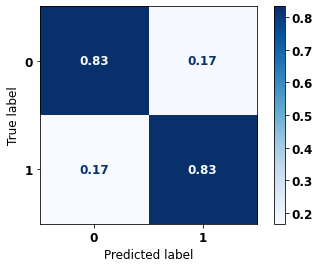

In [ ]:
display_confusion_matrix(rf_fora_12_15, X_testOS_12_15, y_testOS_12_15)

> The confusion matrix obtained for the Random Forest, with other states data from 2012 to 2015, also shows a good performance of the model, presenting 83% of accuracy.


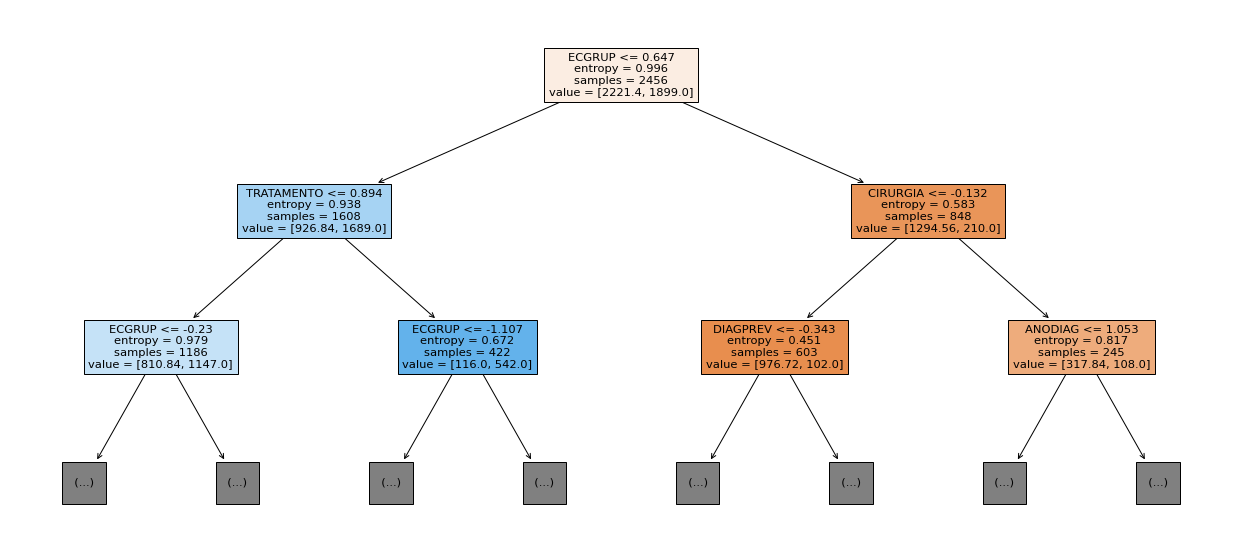

In [ ]:
show_tree(rf_fora_12_15, feat_OS_12_15, 2)

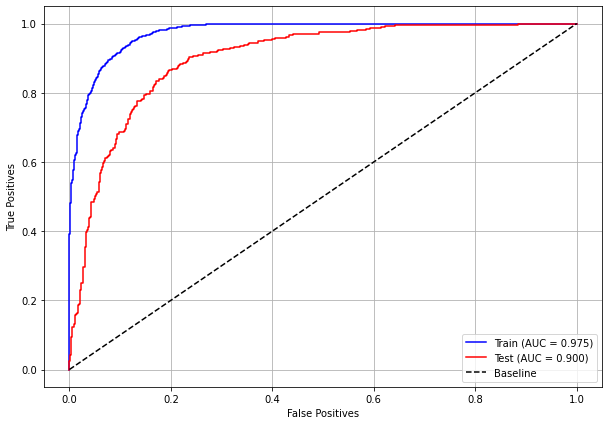

In [ ]:
plot_roc_curve(rf_fora_12_15, X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15)

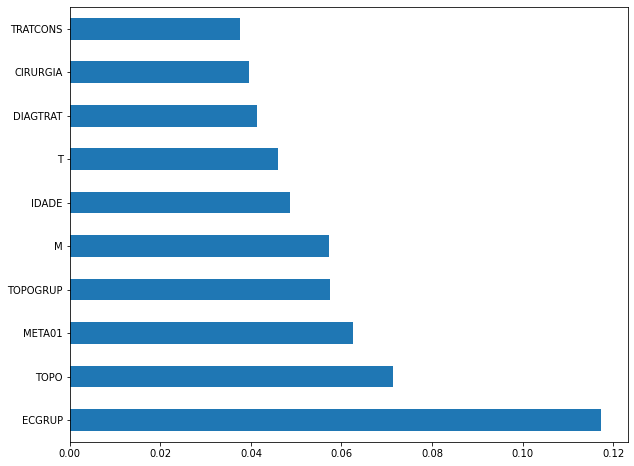

In [ ]:
plot_feat_importances(rf_fora_12_15, feat_OS_12_15)

> The four most important features in the model were `ECGRUP`, `TOPO`, `META01` and `TOPOGRUP`.

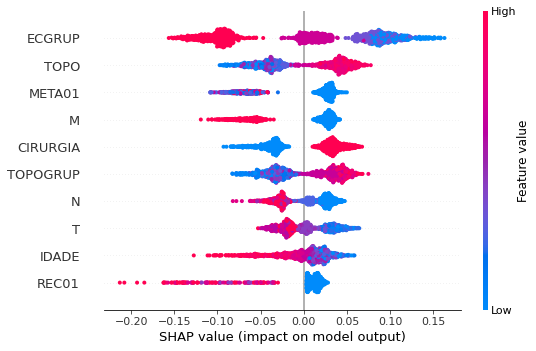

In [ ]:
plot_shap_values(rf_fora_12_15, X_testOS_12_15, feat_OS_12_15)

### **XGBoost**


The training of the XGBoost models follows the same pattern with `random_state`. The hyperparameter `scale_pos_weight` was also used in some trainings, in order to obtain a balanced main diagonal in the confusion matrix.

The hyperparameter `max_depth` was chosen as 10 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

**SP**

In [ ]:
# SP - 2000 to 2003
xgb_sp_00_03 = xgb.XGBClassifier(max_depth=10, 
                                 random_state=seed, 
                                 scale_pos_weight=1.05)

xgb_sp_00_03.fit(X_trainSP_00_03, y_trainSP_00_03)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=1.05)

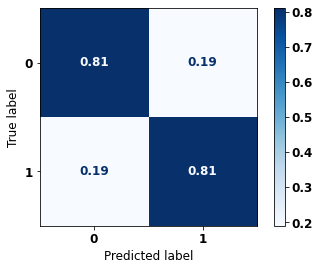

In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_00_03, y_testSP_00_03)

> The confusion matrix obtained for the XGBoost, with SP data from 2000 to 2003, shows a good performance of the model, here with 81% of accuracy.

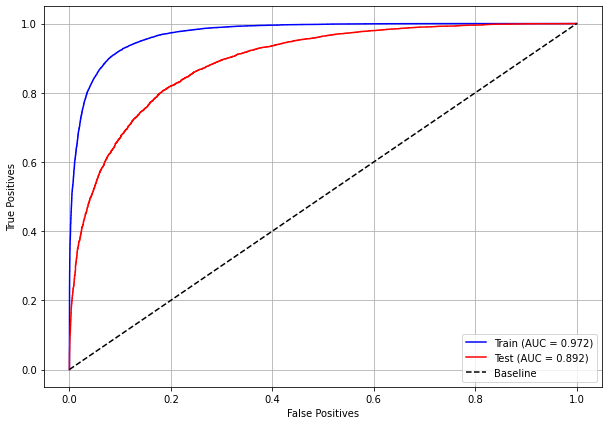

In [ ]:
plot_roc_curve(xgb_sp_00_03, X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03)

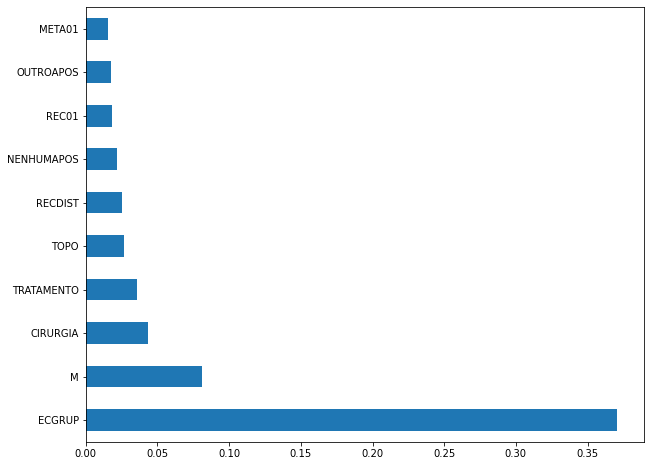

In [ ]:
plot_feat_importances(xgb_sp_00_03, feat_SP_00_03)

> Here we noticed that the most used feature was `ECGRUP`, with a lot advantage over the others. Following we have `M`, `CIRURGIA` and `TRATAMENTO`.

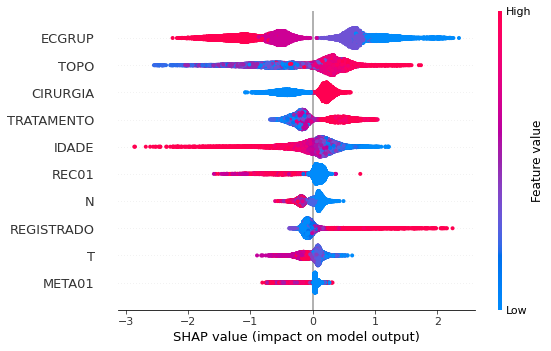

In [ ]:
plot_shap_values(xgb_sp_00_03, X_testSP_00_03, feat_SP_00_03)

In [ ]:
# SP - 2004 to 2007
xgb_sp_04_07 = xgb.XGBClassifier(max_depth=10, 
                                 random_state=seed, 
                                 scale_pos_weight=0.95)

xgb_sp_04_07.fit(X_trainSP_04_07, y_trainSP_04_07)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=0.95)

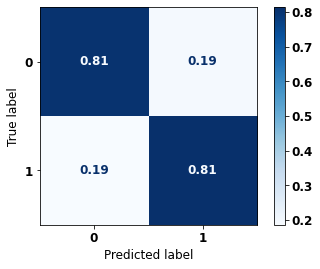

In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_04_07, y_testSP_04_07)

> The confusion matrix obtained for the XGBoost, with SP data from 2004 to 2007, shows a good performance of the model, with 81% of accuracy.


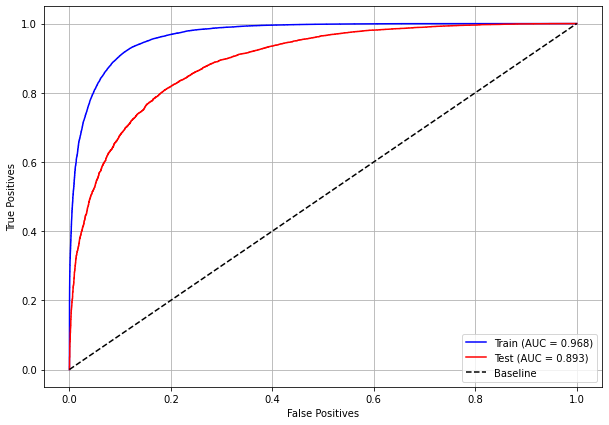

In [ ]:
plot_roc_curve(xgb_sp_04_07, X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07)

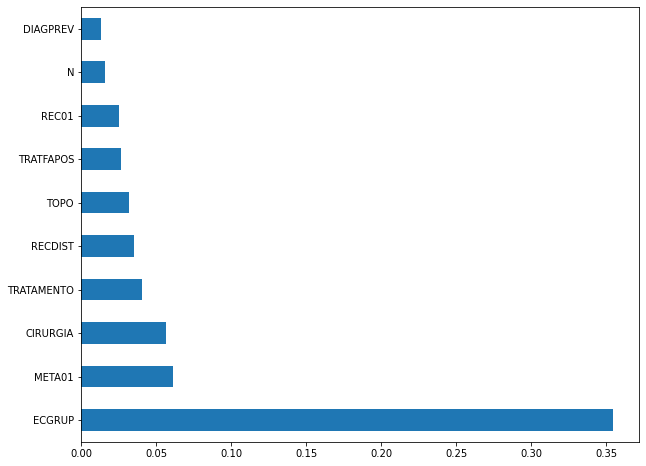

In [ ]:
plot_feat_importances(xgb_sp_04_07, feat_SP_04_07)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage over the others. Following we have `META01`, `CIRURGIA` and `TRATAMENTO`. 

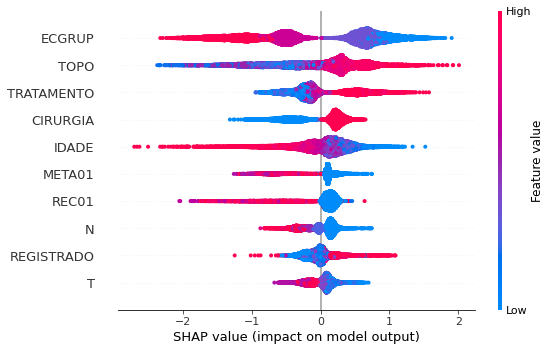

In [ ]:
plot_shap_values(xgb_sp_04_07, X_testSP_04_07, feat_SP_04_07)

In [ ]:
# SP - 2008 to 2011
xgb_sp_08_11 = xgb.XGBClassifier(max_depth=10, 
                                 scale_pos_weight=0.77,
                                 random_state=seed)

xgb_sp_08_11.fit(X_trainSP_08_11, y_trainSP_08_11)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=0.77)

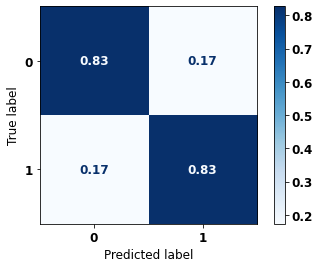

In [ ]:
display_confusion_matrix(xgb_sp_08_11, X_testSP_08_11, y_testSP_08_11)

> The confusion matrix obtained for the XGBoost, with SP data from 2008 to 2011, shows a good performance of the model, with 83% of accuracy.

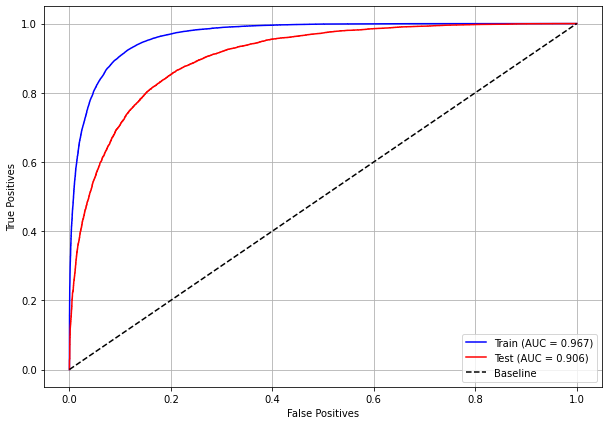

In [ ]:
plot_roc_curve(xgb_sp_08_11, X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11)

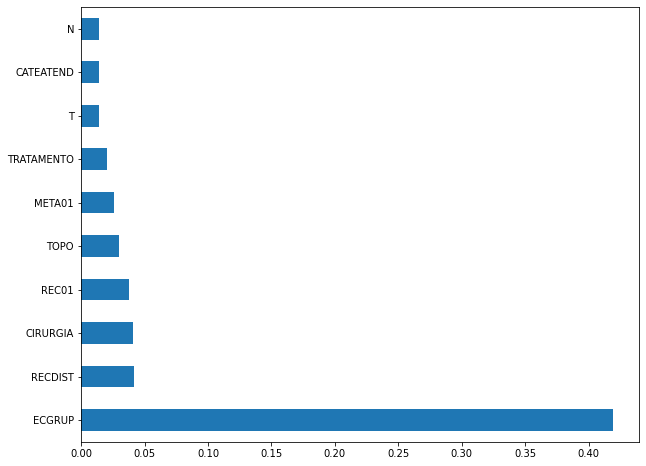

In [ ]:
plot_feat_importances(xgb_sp_08_11, feat_SP_08_11)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage over the others. Following we have `RECDIST`, `CIRURGIA` and `REC01`. 

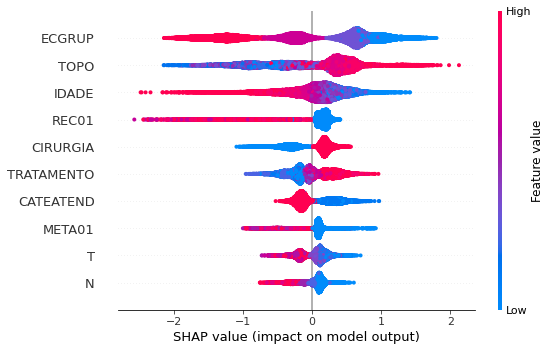

In [ ]:
plot_shap_values(xgb_sp_08_11, X_testSP_08_11, feat_SP_08_11)

In [ ]:
# SP - 2012 to 2015
xgb_sp_12_15 = xgb.XGBClassifier(max_depth=10, 
                                 random_state=seed,
                                 scale_pos_weight=1.27)

xgb_sp_12_15.fit(X_trainSP_12_15, y_trainSP_12_15)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=1.27)

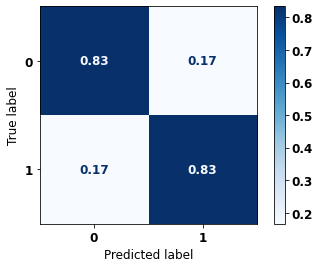

In [ ]:
display_confusion_matrix(xgb_sp_12_15, X_testSP_12_15, y_testSP_12_15)

> The confusion matrix obtained for the XGBoost, with SP data from 2012 to 2015, shows a good performance of the model, with 83% of accuracy.

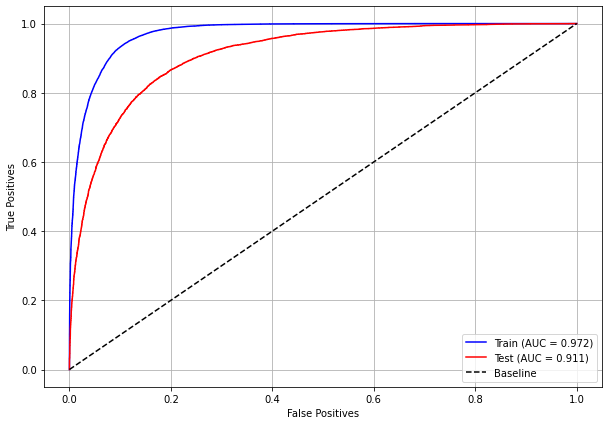

In [ ]:
plot_roc_curve(xgb_sp_12_15, X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15)

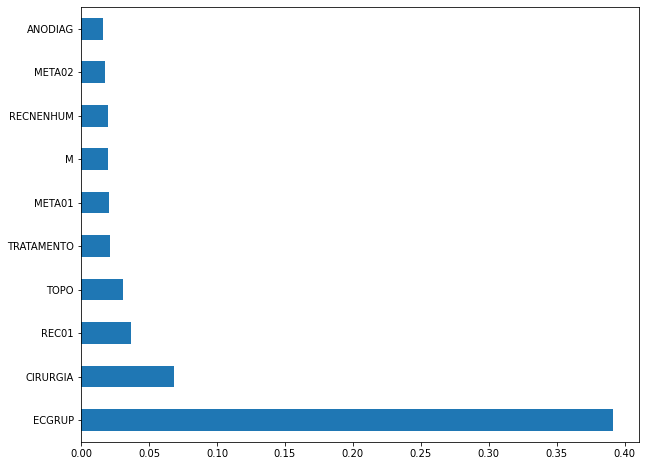

In [ ]:
plot_feat_importances(xgb_sp_12_15, feat_SP_12_15)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage. Following we have `CIRURGIA`, `REC01` and `TOPO`. 

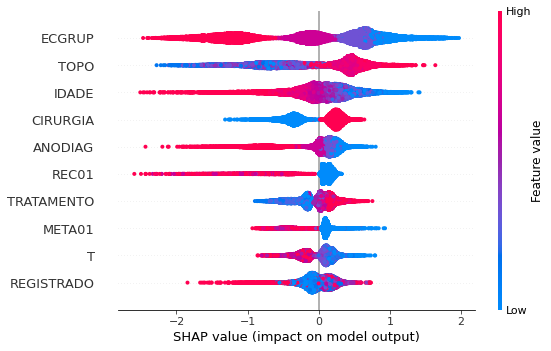

In [ ]:
plot_shap_values(xgb_sp_12_15, X_testSP_12_15, feat_SP_12_15)

**Other states**

In [ ]:
# Other states - 2000 to 2003
xgb_fora_00_03 = xgb.XGBClassifier(max_depth=10, 
                                   scale_pos_weight=0.68,
                                   random_state=seed)

xgb_fora_00_03.fit(X_trainOS_00_03, y_trainOS_00_03)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=0.68)

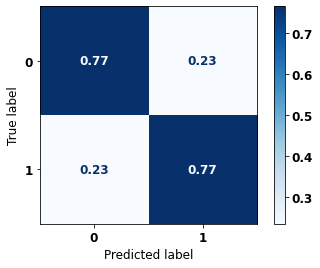

In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_00_03, y_testOS_00_03)

> The confusion matrix obtained for the XGBoost, with other states data from 2000 to 2003, also shows a good performance of the model, with 77% of accuracy.

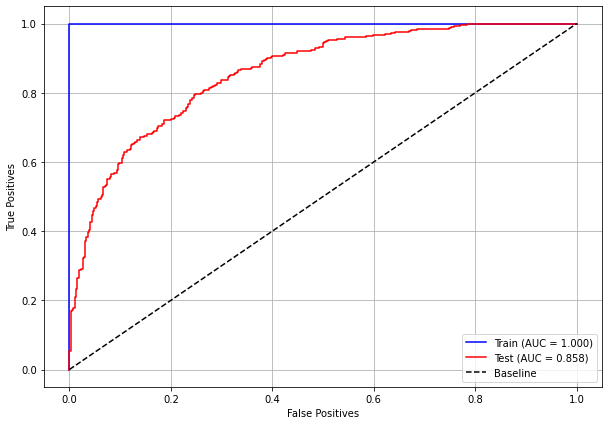

In [ ]:
plot_roc_curve(xgb_fora_00_03, X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03)

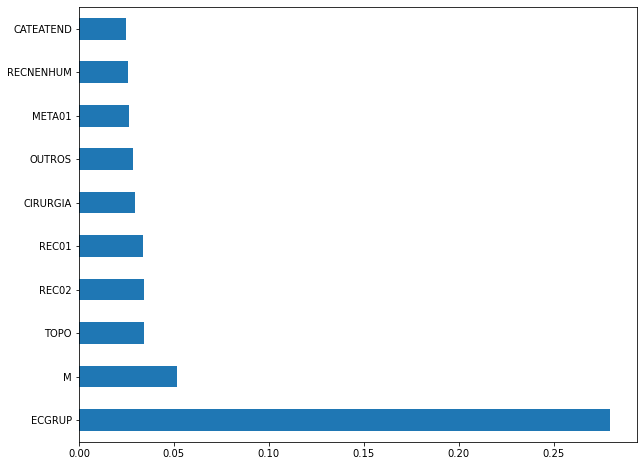

In [ ]:
plot_feat_importances(xgb_fora_00_03, feat_OS_00_03)

> Again we noticed that the most used feature was `ECGRUP`, with a good advantage. The following most important features were `M`, `TOPO` and `REC02`.

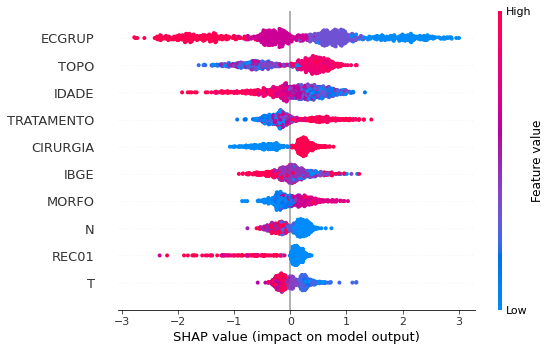

In [ ]:
plot_shap_values(xgb_fora_00_03, X_testOS_00_03, feat_OS_00_03)

In [ ]:
# Other states - 2004 to 2007
xgb_fora_04_07 = xgb.XGBClassifier(max_depth=10, 
                                   scale_pos_weight=0.7,
                                   random_state=seed)

xgb_fora_04_07.fit(X_trainOS_04_07, y_trainOS_04_07)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=0.7)

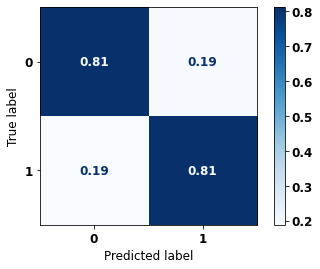

In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_04_07, y_testOS_04_07)

> The confusion matrix obtained for the XGBoost, with other states data from 2004 to 2007, also shows a good performance of the model with 81% of accuracy.

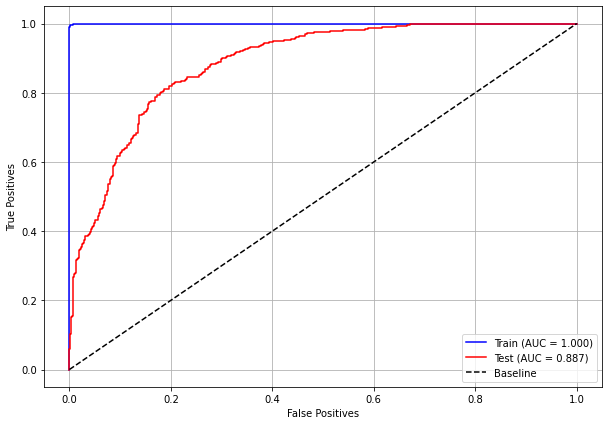

In [ ]:
plot_roc_curve(xgb_fora_04_07, X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07)

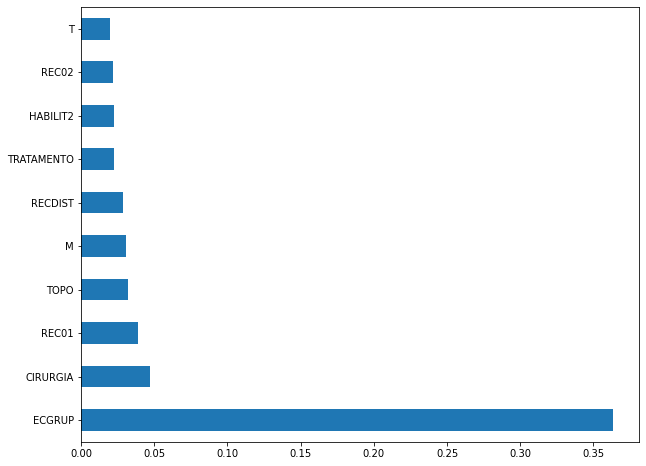

In [ ]:
plot_feat_importances(xgb_fora_04_07, feat_OS_04_07)

> Again we noticed that the most used feature was `ECGRUP`, with a good advantage. The following most important features were `CIRURGIA`, `REC01` and `TOPO`.

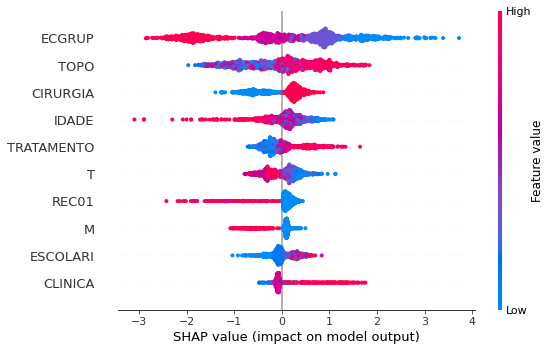

In [ ]:
plot_shap_values(xgb_fora_04_07, X_testOS_04_07, feat_OS_04_07)

In [ ]:
# Other states - 2008 to 2011
xgb_fora_08_11 = xgb.XGBClassifier(max_depth=10, 
                                   scale_pos_weight=0.62,
                                   random_state=seed)

xgb_fora_08_11.fit(X_trainOS_08_11, y_trainOS_08_11)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=0.62)

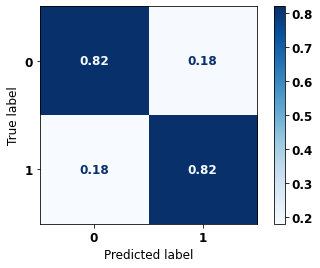

In [ ]:
display_confusion_matrix(xgb_fora_08_11, X_testOS_08_11, y_testOS_08_11)

> The confusion matrix obtained for the XGBoost, with other states data from 2008 to 2011, also shows a good performance of the model with 82% of accuracy.

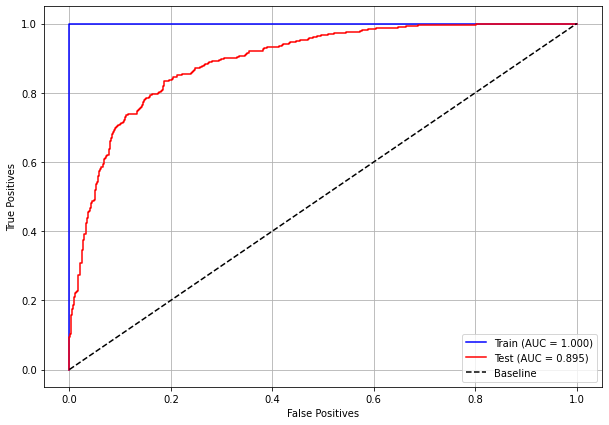

In [ ]:
plot_roc_curve(xgb_fora_08_11, X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11)

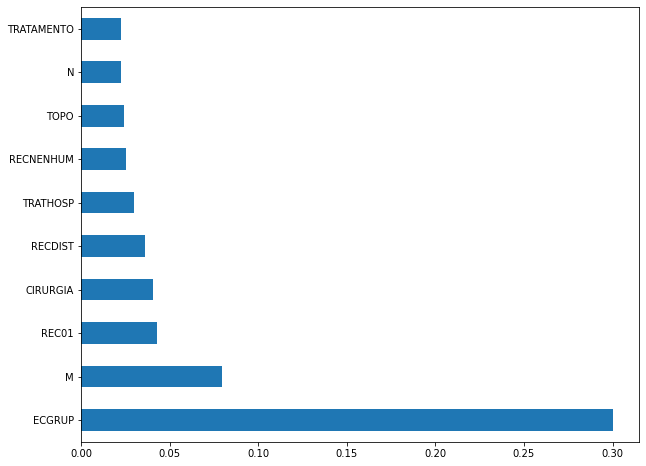

In [ ]:
plot_feat_importances(xgb_fora_08_11, feat_OS_08_11)

> Again we noticed that the most used feature was `ECGRUP`, but not with a lot of advantage. The following most important features were `M`, `REC01` and `CIRURGIA`.

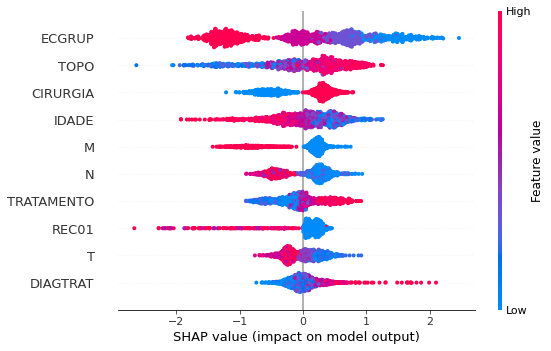

In [ ]:
plot_shap_values(xgb_fora_08_11, X_testOS_08_11, feat_OS_08_11)

In [ ]:
# Other states - 2012 to 2015
xgb_fora_12_15 = xgb.XGBClassifier(max_depth=10, 
                                   scale_pos_weight=1.05,
                                   random_state=seed)

xgb_fora_12_15.fit(X_trainOS_12_15, y_trainOS_12_15)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=1.05)

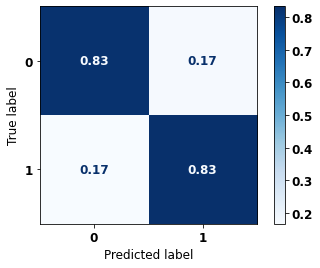

In [ ]:
display_confusion_matrix(xgb_fora_12_15, X_testOS_12_15, y_testOS_12_15)

> The confusion matrix obtained for the XGBoost, with other states data from 2012 to 2015, also shows a good performance of the model with 83% of accuracy.

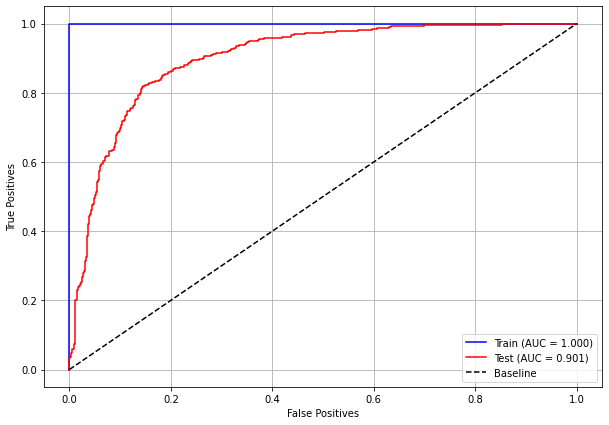

In [ ]:
plot_roc_curve(xgb_fora_12_15, X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15)

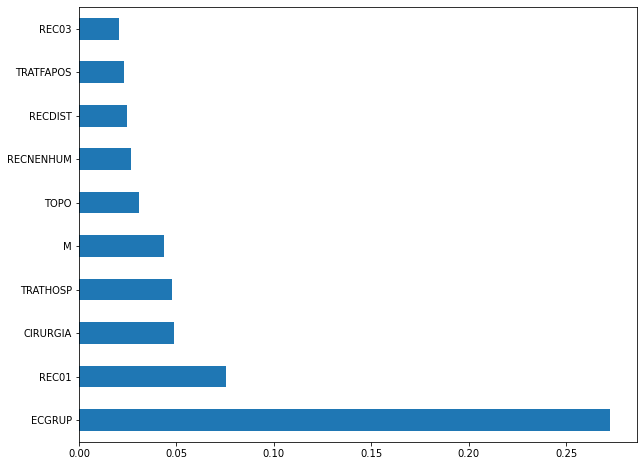

In [ ]:
plot_feat_importances(xgb_fora_12_15, feat_OS_12_15)

> The four most important features were `ECGRUP`, `REC01`, `CIRURGIA` and `TRATHOSP`.

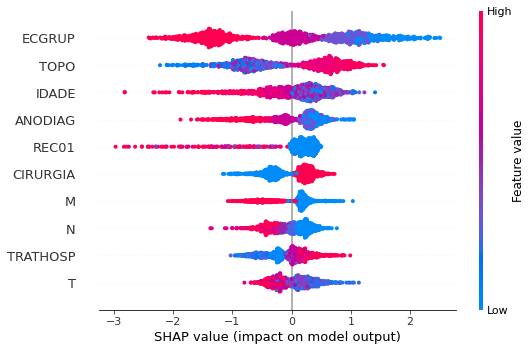

In [ ]:
plot_shap_values(xgb_fora_12_15, X_testOS_12_15, feat_OS_12_15)

## **Testing models with data from other years**

We will use test data from the following years in the trained models for each set of years grouped together.

### **Random Forest SP for years 2000 to 2003**

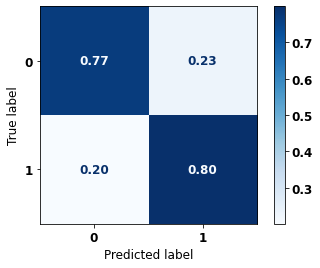

In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_04_07, y_testSP_04_07)

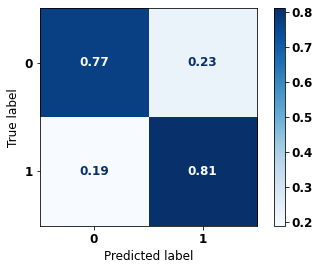

In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_08_11, y_testSP_08_11)

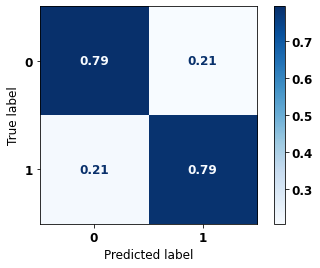

In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_12_15, y_testSP_12_15)

### **XGBoost SP for years 2000 to 2003**

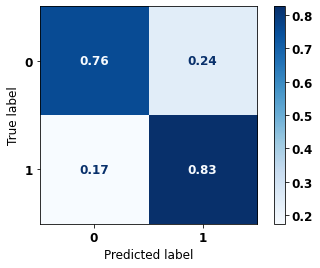

In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_04_07, y_testSP_04_07)

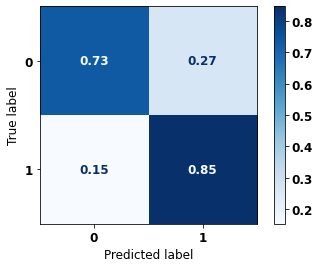

In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_08_11, y_testSP_08_11)

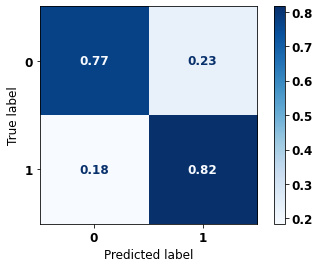

In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_12_15, y_testSP_12_15)

### **Random Forest SP for years 2004 to 2007**

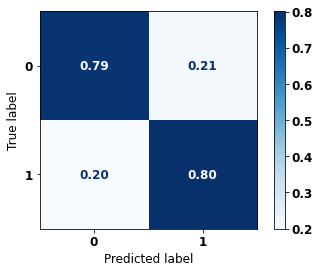

In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_08_11, y_testSP_08_11)

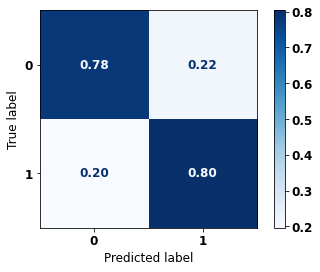

In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_12_15, y_testSP_12_15)

### **XGBoost SP for years 2004 to 2007**

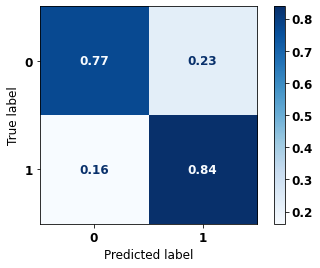

In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_08_11, y_testSP_08_11)

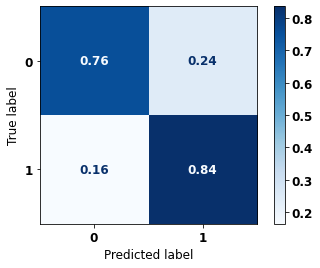

In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_12_15, y_testSP_12_15)

### **Random Forest SP for years 2008 to 2011**

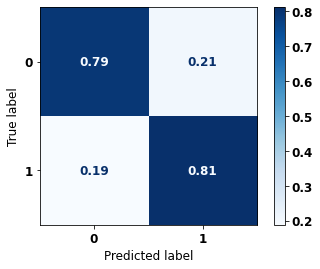

In [ ]:
display_confusion_matrix(rf_sp_08_11, X_testSP_12_15, y_testSP_12_15)

### **XGBoost SP for years 2008 to 2011**

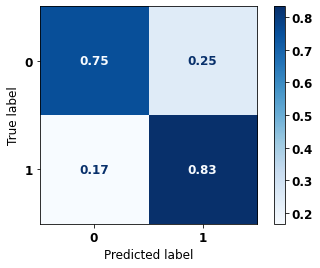

In [ ]:
display_confusion_matrix(xgb_sp_08_11, X_testSP_12_15, y_testSP_12_15)

### **Random Forest Other states for years 2000 to 2003**

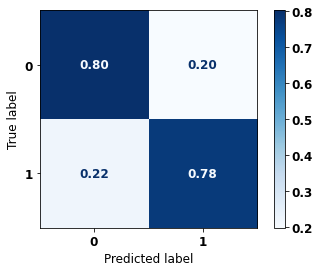

In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_04_07, y_testOS_04_07)

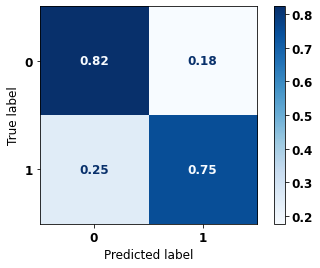

In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_08_11, y_testOS_08_11)

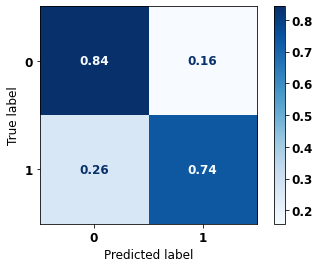

In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_12_15, y_testOS_12_15)

### **XGBoost Other states for years 2000 to 2003**

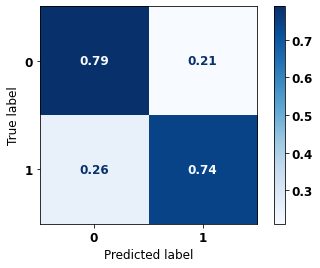

In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_04_07, y_testOS_04_07)

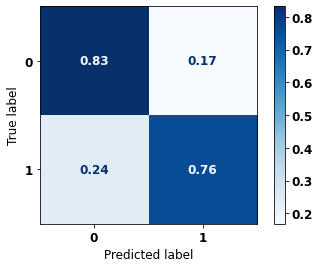

In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_08_11, y_testOS_08_11)

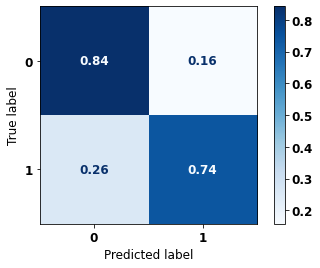

In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_12_15, y_testOS_12_15)

### **Random Forest Other states for years 2004 to 2007**

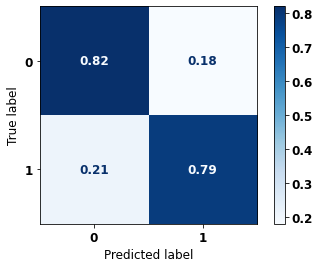

In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_08_11, y_testOS_08_11)

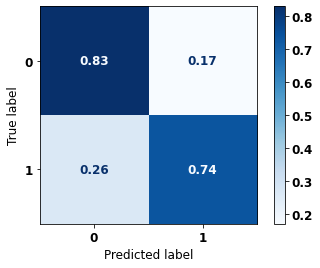

In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_12_15, y_testOS_12_15)

### **XGBoost Other states for years 2004 to 2007**

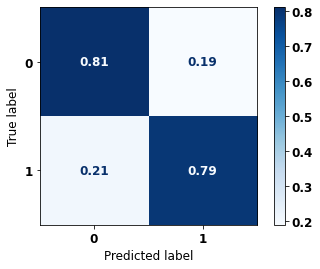

In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_08_11, y_testOS_08_11)

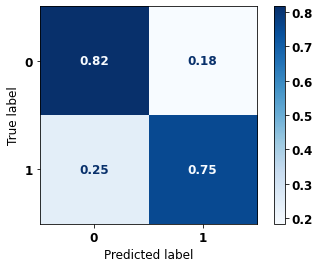

In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_12_15, y_testOS_12_15)

### **Random Forest Other states for years 2008 to 2011**

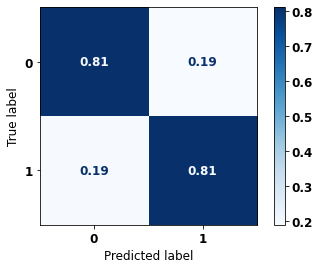

In [ ]:
display_confusion_matrix(rf_fora_08_11, X_testOS_12_15, y_testOS_12_15)

### **XGBoost Other states for years 2008 to 2011**

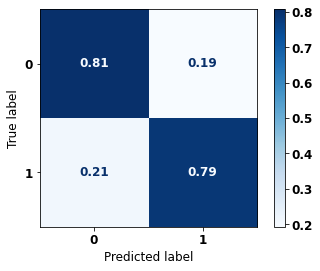

In [ ]:
display_confusion_matrix(xgb_fora_08_11, X_testOS_12_15, y_testOS_12_15)